In [ ]:
# 불러와야 되는 파일 2개 있어요
# 공유폴더에 중분류코드 종합 피클 파일 하고 상품분류 엑셀 파일 있습니다
  
# 이거 실행(설치)하고 런타임 재시작 하면 한글 출력 가능
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 새 섹션

# 새 섹션

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from datetime import datetime

from keras import layers
from keras import Sequential
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Embedding

from keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px

# 한글 폰트 출력
plt.rc('font', family='NanumBarunGothic') 
# warning 무시
warnings.filterwarnings(action='ignore')

In [ ]:
# 버블 차트 그림그리용

#랜덤 버블 그래프용 함수
import random
import matplotlib

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels ):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        color : Random RGBA
        """
        for i in range(len(self.bubbles)):
            red = random.randint(1,128) + 127
            green = random.randint(1,128) + 127
            blue = random.randint(1,128) + 127
            RGBA = '#%02x%02x%02x' % (red, green, blue)
            #RGBA = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
            circ = plt.Circle(    
                self.bubbles[i, :2], self.bubbles[i, 2], color = RGBA)
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

In [ ]:
path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/lmemdata/'

In [ ]:
purchase_tr_path = '구매상품TR.txt'
merchant_cl_path = '상품분류.txt'
compet_use_path = '경쟁사이용.txt'
cust_demo_path = '고객DEMO.txt'
channel_use_path = '채널이용.txt'
membership_path = '멤버십여부.txt'

# 파일 불러오기

In [ ]:
df_membership = pd.read_csv(path+membership_path, encoding='cp949')   # 멤버쉽이 있는 회원은 기입됨
df_channel_use = pd.read_csv(path+channel_use_path, encoding='cp949') # 멤버들이 어떤 채널로 사용하는지
df_cust_demo = pd.read_csv(path+cust_demo_path, encoding='cp949') # 멤버들의 기본 신상 정보
df_compet_use = pd.read_csv(path+compet_use_path, encoding='cp949') # 멤버들이 경쟁 회사를 사용하는지
df_merchant_cl = pd.read_csv(path+merchant_cl_path, encoding='cp949') # 상품 정보

In [ ]:
# 대용량 데이터 불러오기 (transaction은 용량이 겁나 큼)
df_purchase_tr = pd.read_csv(path+purchase_tr_path, encoding='cp949', chunksize = 1000000) #100만개 단위로 끊기, 실제 transaction 데이터
chunk = list(df_purchase_tr)

print(len(chunk)) # 몇개 chunk인지 출력

df_purchase_tr = pd.concat(chunk)  # 데이터 넣기
df_purchase_tr.shape

29


(28593030, 10)

In [ ]:
df_purchase_tr['구매일자'] = pd.to_datetime(df_purchase_tr['구매일자'],format='%Y%m%d') # 

# 멤버 정보 합치기 


- 고객번호, 성별, 연령대, 거주지역, 멤버십유무, 멤버십가입년월, 경쟁사, 경쟁사 이용연월, 제휴사(모바일/온라인), 최근3개월간 이용횟수

In [ ]:
# print(df_cust_demo.columns)
# print(df_membership.columns)
# print(df_compet_use.columns)
# print(df_channel_use.columns)
#np.unique(pd.DataFrame(df_compet_use.groupby('고객번호')['경쟁사'].count())['경쟁사'], return_counts = True)
#df_channel_use.제휴사.value_counts()

1. cust_demo  '고객DEMO.txt'



*   항목 추가



- 19383 명의 데이터
- '고객번호', '성별', '연령대', '거주지역' 정보를 담고 있음
- 고객번호, 성별, 연령대는 null값이 없음, 거주지역은 178개 null값 존재

2. compet_use  '경쟁사이용.txt'

- A, B, C, D 4개의 제휴사에 대해서 각각 A1,A2 이런식으로 경쟁사가 존재(A -> B1 이런경우 없음)
- 경쟁사는 총 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02' 9개 존재
- 5881명 / 19383 명의 고객이 경쟁사 이용한 적이 있음
- 응답한 사람들은 경쟁사 이용횟수가 1회~40회 사이로 응답

횟수 :
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 40]


인원 :
[1749,  979,  611,  487,  371,  296,  222,  185,  145,  119,  106,
          87,   97,   61,   69,   47,   43,   36,   28,   25,   16,   17,
          20,   13,   10,    4,    7,    6,   10,    7,    2,    2,    3,
           1]


3. channel_use  '채널이용.txt'

- 4개 계열사 관련 모바일/app(A.MOBILE/APP, B.MOBILE/APP, C.MOBILE/APP, D.MOBILE/APP)
- 2개 계열사 관련 온라인 쇼핑몰(B.ONLINEMALL, C.ONLINEMALL)
- 최근 3개월간 모바일/APP 로그인 횟수 , 최근 3개월간 온라인 쇼핑몰  구매 횟수

- 6766명/19383 이 모바일/온라인을 이용한 적이 있음

- B_MOBILE/APP    5170, A_MOBILE/APP    1435, C_MOBILE/APP      46, D_MOBILE/APP     227
- B_ONLINEMALL    1328, C_ONLINEMALL     618, 


4. membership  '멤버십여부.txt'

- 하이마트, 다둥이, 더원, 롭스 멤버십 중에 하나 가입한 경우 표시
- 멤버십 가입 연월일 표시
- 하이마트    4418 ,다둥이     2009, 더영       642, 롭스       387
- 멤버쉽을 가지고 있는 회원 숫자 6498명/ 19383 (약 1/3 정도)
- 그중 5601이 한개의 멤버십만을 가지고 있음, 837 이 2개, 59명이 3개, 4개 다가지고 있는 사람은 1명

In [ ]:
# 거주지역은 우편번호 코드
# 거주지역번호 -> 거주지역지명 변환 함수

def location_cat(x) :   
    cat = ''
    if x >= 10 and x < 100:
        cat = '서울'
    elif x>=100 and x < 210:
        cat = '경기'
    elif x>=210 and x < 240:
        cat = '인천'
    elif x>=240 and x < 270:
        cat = '강원'
    elif x>=270 and x < 300:
        cat = '충북'
    elif x>=300 and x <310:
        cat = '세종'
    elif x>=310 and x<340:
        cat = '충남'
    elif x>=340 and x<360:
        cat = '대전'
    elif x>=360 and x<410:
        cat = '경북'
    elif x>=410 and x<440:
        cat = '대구'
    elif x>=440 and x<460:
        cat = '울산'
    elif x>=460 and x<500:
        cat = '부산'
    elif x>=500 and x<540:
        cat = '경남'
    elif x>=540 and x<570:
        cat = '전북'
    elif x>=570 and x<610:
        cat = '전남'
    elif x>=610 and x<630:
        cat = '광주'
    elif x>=630 and x<640:
        cat = '제주'
    else :
        cat = '불명'        
    return cat

In [ ]:
df_cust_demo.거주지역= df_cust_demo.거주지역.fillna(0)
df_cust_demo['거주지역이름'] = df_cust_demo.거주지역.map(location_cat)
# print(df_cust_demo.거주지역이름.value_counts())
# print(df_cust_demo.거주지역.value_counts())

In [ ]:
df_members = pd.merge(df_cust_demo, df_membership, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_compet_use, on='고객번호', how='outer')
df_members = pd.merge(df_members, df_channel_use, on='고객번호', how='outer') 
df_members.rename(columns = {'제휴사_x': '제휴사', '제휴사_y': '사용(모바일/온라인) 채널', '가입연월': '멤버십가입연월', '이용년월':'경쟁사이용년월', '이용횟수':'채널이용횟수' }, inplace = True)
df_members.drop(columns={'제휴사'}, inplace = True)  # 이 컬럼은 지워도 됨. 어짜피 경쟁사 COLUMN에 A,B,C,D중 하나 표시됨
df_members.fillna(0)

고객번호 성별      연령대   거주지역 거주지역이름 멤버십명      가입년월  경쟁사   경쟁사이용년월  \
0          1  M    60세이상   60.0     서울    0       0.0  A01  201507.0   
1          1  M    60세이상   60.0     서울    0       0.0  A02  201504.0   
2          1  M    60세이상   60.0     서울    0       0.0  B01  201501.0   
3          1  M    60세이상   60.0     서울    0       0.0  B01  201502.0   
4          1  M    60세이상   60.0     서울    0       0.0  B01  201507.0   
...      ... ..      ...    ...    ...  ...       ...  ...       ...   
48842  19379  F  20세~24세   69.0     서울   롭스  201412.0    0       0.0   
48843  19380  F  20세~24세   39.0     서울   롭스  201412.0    0       0.0   
48844  19381  F  40세~44세  460.0     부산  다둥이  201506.0    0       0.0   
48845  19382  F  45세~49세  460.0     부산    0       0.0    0       0.0   
48846  19383  F  25세~29세  500.0     경남   롭스  201507.0    0       0.0   

      사용(모바일/온라인) 채널  채널이용횟수  
0                  0     0.0  
1                  0     0.0  
2                  0     0.0  
3                  0     0.0  
4                  0     0.0  
...              ...     ...  
48842              0     0.0  
48843   D_MOBILE/APP     1.0  
48844   B_MOBILE/APP     5.0  
48845   B_MOBILE/APP     9.0  
48846              0     0.0  

[48847 rows x 11 columns]

In [ ]:
# 간단히 분포 그려보기
#pd.DataFrame(df_members.성별.value_counts()).plot(kind = 'bar'); # 여성이 많음
# pd.DataFrame(df_members.연령대.value_counts()).plot(kind = 'bar'); # 연령 분포
# pd.DataFrame(df_members.거주지역.value_counts()).plot(kind = 'bar');  # 지역코드가 숫자로 나옴
#pd.DataFrame(df_members.멤버십명	.value_counts()).plot(kind = 'bar'); # 멤버십은 4종류 (하이마트, 더영, 다동이, 롭스)
#pd.DataFrame(df_members.사용채널.value_counts()).plot(kind = 'bar'); 

In [ ]:
#sns.jointplot(x= df_members.고객번호, y = df_members.채널이용횟수);
#sns.pairplot(df_members);  # 데이터간 관계 그려보기

# 상품 분류 살펴보기

In [ ]:
# df_merchant_cl.drop(columns={'대분류코드'},inplace = True)  # 중분류 코드안에 대분류코드가 실제로 들어잇음 예: 대분류 1 -> 중분류 101 / 따라서 대분류코드 drop해도 괜찮음

In [ ]:
# 제휴사는 4종류, 서로 분류가 완전히 다름
cat_a_df = df_merchant_cl[df_merchant_cl.제휴사 == 'A'] 
cat_b_df = df_merchant_cl[df_merchant_cl.제휴사 == 'B'] 
cat_c_df = df_merchant_cl[df_merchant_cl.제휴사 == 'C'] 
cat_d_df = df_merchant_cl[df_merchant_cl.제휴사 == 'D'] 

print('A 제휴사의 중분류: ',cat_a_df.중분류명.unique())  # 백화점?
print('\n')
print('B 제휴사의 중분류: ',cat_b_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('C 제휴사의 중분류: ',cat_c_df.중분류명.unique())  # 롯데마트? 롯데슈퍼?
print('\n')
print('D 제휴사의 중분류: ',cat_d_df.중분류명.unique())  # 롭스?

# print(cat_a_df.소분류명.unique())  # 백화점?
# print(cat_b_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_c_df.소분류명.unique())  # 롯데마트? 롯데슈퍼?
# print(cat_d_df.소분류명.unique())  # 롭스?

A 제휴사의 중분류:  ['일용잡화' '육류' '축산가공' '농산물' '수산품' '가공식품' '젓갈/반찬' '건강식품' '주류' '차/커피' '기타'
 '섬유잡화' '액세서리' '화장품' '보석' '준보석/시계' '피혁잡화' '구두' '아동' '캐주얼' '커리어' '트래디셔널'
 '시티웨어' '란제리/내의' '블라우스' '기타의류' '디자이너' '모피/피혁' '남성정장' '남성캐주얼' '교복' '셔츠'
 '남성 트랜디' '스포츠' '골프용품' '대형가전' '소형가전' '통신/컴퓨터' '악기' '전자/전기' '주방가전' '명품'
 '주방용품' '문구/팬시' '생활잡화' '식기' '가구' '침구/수예' '웨딩']


B 제휴사의 중분류:  ['열매채소' '버섯' '온라인버섯/열매채소' '조리반찬' '시즌반찬' '포장젓갈' '포장반찬' '양곡' '잡곡류' '즉석도정미'
 '가공양곡' '잎채소' '뿌리채소' '버섯류' '샐러드채소' '약초' '양념류' '식자재' '친환경채소' '김치채소'
 '온라인잎/샐러드채소' 'LOCAL잎채소' 'LOCAL김치채소' '샐러드/간편채소' '대중선어' '냉동수산물' '생선선물세트'
 '고등어/삼치' '대구' '도미/민어' '기타구색생선' '꽁치/가자미' '오징어' '조기/명태' '국산게/갈치' '선물세트'
 '즉석구이안주' '마른안주' '멸치건명태' '해조류' '특산물' '건오징어' '조미오징어' '육포' '쥐치포' '마른안주선물세트'
 'Fast Food' '편의시설' '레스토랑' '카페' '판매시설' '주유소' '브랜드조리' '베이커리' '구이' '튀김' '밥류'
 '구이찜조리' '반찬류' '대용식' '이벤트조리' '간식조리' '간편조리' '튀김조리' '피자' '냉장음료' '데일리처분'
 '흰우유' '가공우유' '요구르트' '유제품' '브랜드빵' '치즈' '디저트' '유가공' '조미료' '소스류' '장류' '식용유지'
 '조미선물세트' '가루' '향신료' '액상조미료' '복합조미료' '소금/설탕류' '수입조미' '간편조리식품' '

## 상품 분류 통합

- 가장 분류가 작은 A를 기준으로 통합, A에 일부 없는 분류는 새로 생성

In [ ]:
### 피클 파일 불러오기 ###
import pickle

path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/'

with open(path + "중분류코드_종합.pkl","rb") as f:
  new_cat_df=pickle.load(f)

# 빈 value의 경우 key값을 value값으로 받아오기
dct = {k: [k] if v == [] else v for k, v in new_cat_df.items() }

# key와 value swap
newDict = {}
for key,value in dct.items():
    for val in value:
        if val in newDict:
            newDict[val].append(key)
        else:
            newDict[val] = [key]

# A 제휴사 분류를 추가
newDict_ = {}
for i in cat_a_df.중분류명:
  newDict_[i] = i

newDict.update(newDict_)

# 빠진거 추가
newDict['전통과자'] = 'N스낵류'
newDict['간편간식'] = 'N스낵류'

#리스트(이지만 하나의 member만 가짐)를 str로 변경
prod_Dict = {}
for key,value in newDict.items():
  if type(value) == list :
    prod_Dict[key] = value[0]
  else :
    prod_Dict[key] = value

df_merchant_cl['new_mid_cat'] = df_merchant_cl['중분류명'].apply(lambda x : prod_Dict[x])

np.unique(df_merchant_cl.new_mid_cat)

array(['N냉동류', 'N냉장류', 'N도서/음반', 'N스낵류', 'N음료류', 'N자동차용품', 'N푸드코트',
       '가공식품', '가구', '건강식품', '골프용품', '교복', '구두', '기타', '기타의류', '남성 트랜디',
       '남성정장', '남성캐주얼', '농산물', '대형가전', '디자이너', '란제리/내의', '명품', '모피/피혁',
       '문구/팬시', '보석', '블라우스', '생활잡화', '섬유잡화', '셔츠', '소형가전', '수산품', '스포츠',
       '시티웨어', '식기', '아동', '악기', '액세서리', '웨딩', '육류', '일용잡화', '전자/전기',
       '젓갈/반찬', '주류', '주방가전', '주방용품', '준보석/시계', '차/커피', '축산가공', '침구/수예',
       '캐주얼', '커리어', '통신/컴퓨터', '트래디셔널', '피혁잡화', '화장품'], dtype=object)


## 상품 분류 추가

분류1: 고급/일반 - 가격이 비싼가 그렇게 비싸지 않은가

분류2: 내구재/준내구제/비내구재

내구재는 1년 이상 반복적으로 사용이 가능하고 주로 고가의 상품으로 승용차, 가전제품, 가구 등이 해당된다.

준내구재는 1년 이상 사용이 가능하지만 사용가능한 지속성이 내구재에 비해 떨어지는 상품으로 의복, 신발·가방, 운동 및 오락용품 등이 해당된다.

비내구재는 주로 이용할수 있는 기간이 짧고 반복적으로 이용이 곤란한 상품으로 음식료품, 화장품, 서적 및 문구 등이 해당된다.

분류3: 선매품/편의품/전문품

편의품은 소량으로 자주 구입하는 일용품이나 식품

선매품은 다양한 제품들을 비교하여 구매하는 패션제품이나 가전제품 등

전문품은 특별한 목적으로 구매하는 제품, 즉 전문적 지식이나 성향에 의해 구매하는 제품들. 의료기기나 스포츠 용품 등



In [ ]:
goods_cat = pd.read_excel(path + "상품분류.xlsx")

df_merchant_cl = pd.merge(df_merchant_cl,goods_cat, left_on = 'new_mid_cat', right_on= '분류')
df_merchant_cl.drop(columns='new_mid_cat', inplace = True)
df_merchant_cl

제휴사  대분류코드  중분류코드    소분류코드  중분류명   소분류명    분류 고급/일반 내구/준내구/비내구 편의/선매/전문
0      A      1    101  A010101  일용잡화   위생세제  일용잡화    일반         내구       편의
1      A      1    101  A010102  일용잡화    휴지류  일용잡화    일반         내구       편의
2      A      1    101  A010103  일용잡화   뷰티상품  일용잡화    일반         내구       편의
3      A      1    101  A010104  일용잡화   일용잡화  일용잡화    일반         내구       편의
4      A      1    101  A010105  일용잡화   세트상품  일용잡화    일반         내구       편의
...   ..    ...    ...      ...   ...    ...   ...   ...        ...      ...
4381   C     10   1004  C100406  냉동MS   냉동튀김  N냉동류    일반        비내구       편의
4382   C     10   1004  C100407  냉동MS   냉동부침  N냉동류    일반        비내구       편의
4383   C     10   1004  C100408  냉동MS  냉동국탕류  N냉동류    일반        비내구       편의
4384   C     10   1004  C100409  냉동MS  냉동디저트  N냉동류    일반        비내구       편의
4385   C     10   1004  C100410  냉동MS  냉동떡볶이  N냉동류    일반        비내구       편의

[4386 rows x 10 columns]

In [ ]:
df_merchant_cl.분류.unique()  #총 56종의 분류

array(['일용잡화', '육류', '축산가공', '농산물', '수산품', '가공식품', '젓갈/반찬', '건강식품', '주류',
       '차/커피', '기타', '섬유잡화', '액세서리', '화장품', '보석', '준보석/시계', '피혁잡화', '구두',
       '아동', '캐주얼', '커리어', '트래디셔널', '시티웨어', '란제리/내의', '블라우스', '기타의류',
       '디자이너', '모피/피혁', '남성정장', '남성캐주얼', '교복', '셔츠', '남성 트랜디', '스포츠',
       '골프용품', '대형가전', '소형가전', '통신/컴퓨터', '악기', '전자/전기', '주방가전', '명품',
       '주방용품', '문구/팬시', '생활잡화', '식기', '가구', '침구/수예', '웨딩', 'N음료류', 'N스낵류',
       'N도서/음반', 'N푸드코트', 'N자동차용품', 'N냉장류', 'N냉동류'], dtype=object)

## 분류별 매출액 시계열 그래프
- 특정 상품 or 분류에 따른 매출액 총액이 시계열에 따라 어떻게 달라지는가

In [ ]:
cat_m = df_purchase_tr[['구매일자', '제휴사','중분류코드','구매금액']].set_index('구매일자')
cat_m = cat_m.groupby(['제휴사','중분류코드']).resample('QS').구매금액.sum()
cat_m = cat_m.unstack().reset_index().fillna(0)
cat_m = pd.merge(cat_m, df_merchant_cl[['제휴사','중분류코드','분류']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
cat_m = cat_m.drop(columns ={'제휴사','중분류코드'}).groupby('분류').sum().T
cat_m.loc['합계'] = cat_m.sum()
cat_m.sort_values(by ='합계',  ascending = False, axis = 1, inplace = True)
cat_m.drop('합계', axis = 0, inplace = True)

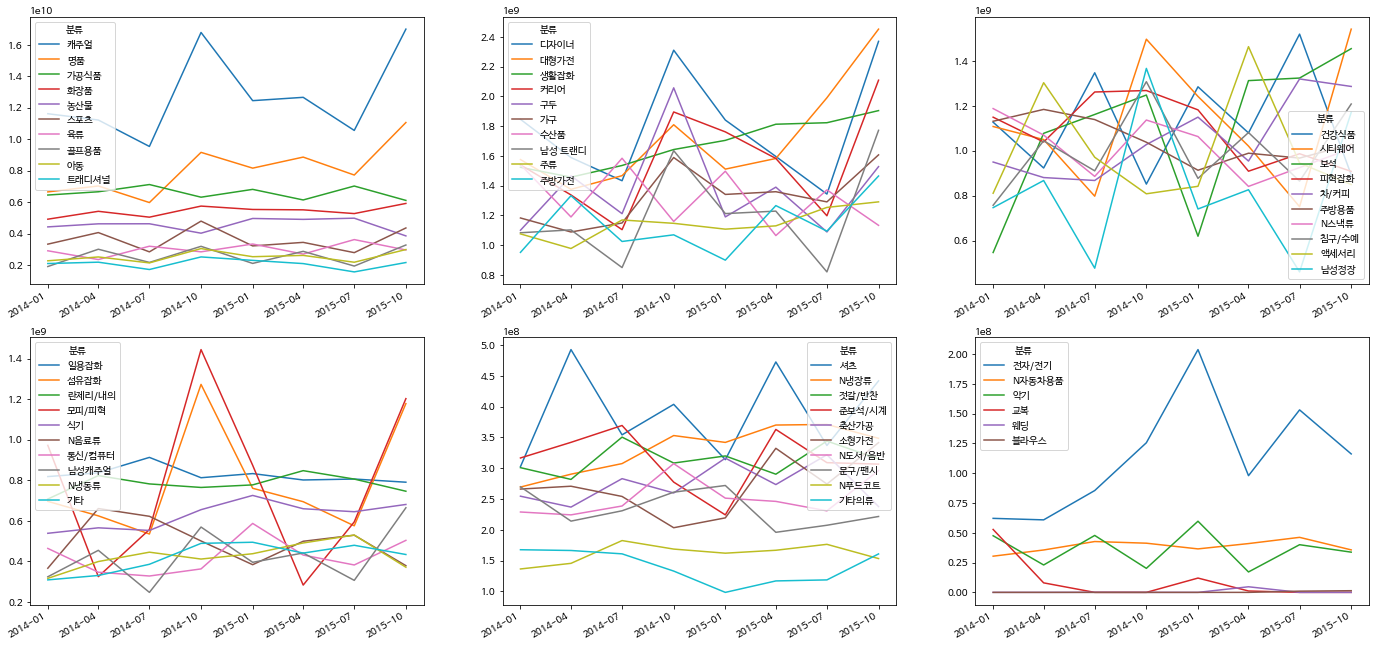

In [ ]:
#define subplot layout
w = 8; h = 6;
c = 3; r = 2;
fig, axes = plt.subplots(nrows=r, ncols=c, figsize = (w*c,h*r))

cat_m.iloc[:,:10].plot(ax=axes[0,0]);  # 개별 중분류명에 따라 시계열 매출액 합계 그래프/ 일부만 그려본것
cat_m.iloc[:,10:20].plot(ax=axes[0,1]);
cat_m.iloc[:,20:30].plot(ax=axes[0,2]);
cat_m.iloc[:,30:40].plot(ax=axes[1,0]);
cat_m.iloc[:,40:50].plot(ax=axes[1,1]);
cat_m.iloc[:,50:].plot(ax=axes[1,2]);

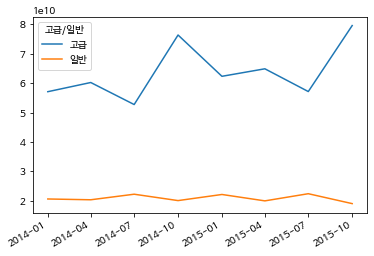

In [ ]:
exp_cheap_df = pd.merge(cat_m.T.reset_index(), df_merchant_cl[['분류', '고급/일반']].drop_duplicates(), on = '분류', how ='left').drop(columns = '분류').groupby('고급/일반').sum().T
exp_cheap_df.plot();

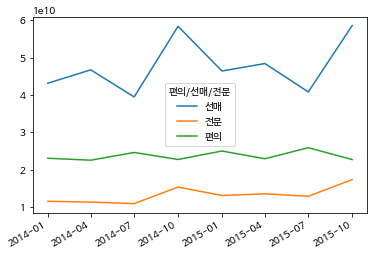

In [ ]:
conv_df = pd.merge(cat_m.T.reset_index(), df_merchant_cl[['분류', '편의/선매/전문']].drop_duplicates(), on = '분류', how ='left').drop(columns = '분류').groupby('편의/선매/전문').sum().T
conv_df.plot();

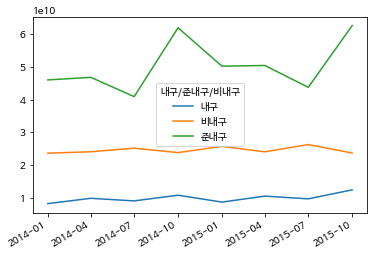

In [ ]:
dura_df = pd.merge(cat_m.T.reset_index(), df_merchant_cl[['분류', '내구/준내구/비내구']].drop_duplicates(), on = '분류', how ='left').drop(columns = '분류').groupby('내구/준내구/비내구').sum().T
dura_df.plot();

# 상품 Transaction EDA

## 전체 데이터 분포 살펴보기


### 전체 시계열 구매금액(day, month, quarter, year, weekly)

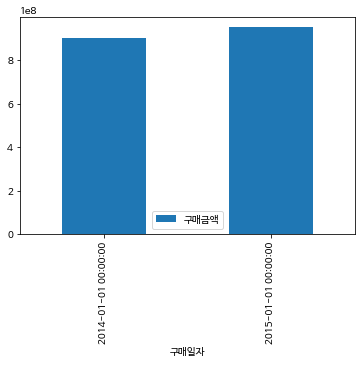

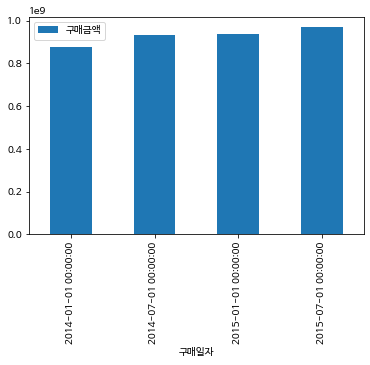

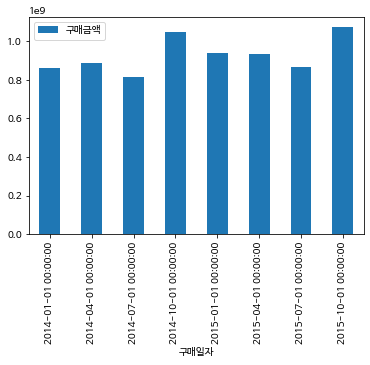

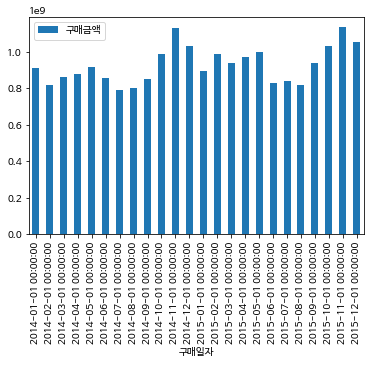

In [ ]:
# 날짜별 구매금액
sum_purchased = pd.DataFrame(df_purchase_tr.groupby('구매일자').구매금액.sum().fillna(0))

# 연도, 분기, 월별 구매금액
sum_Y_df = sum_purchased.resample('YS').mean().fillna(0)
sum_Y_df.plot(kind = 'bar');
sum_6m_df = sum_purchased.resample('2QS').mean().fillna(0)
sum_6m_df.plot(kind = 'bar');
sum_Q_df = sum_purchased.resample('QS').mean().fillna(0)
sum_Q_df.plot(kind = 'bar');
sum_m_df = sum_purchased.resample('MS').mean().fillna(0)
sum_m_df.plot(kind = 'bar');

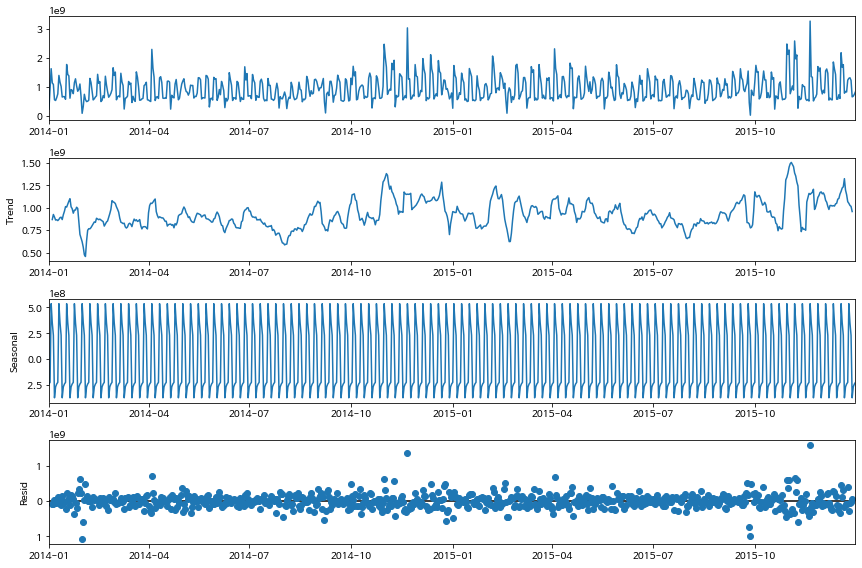

In [ ]:
# 구매금액 계절성(seasonality)
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sum_purchased, model='additive')
plt.rcParams['figure.figsize'] = [12, 8]
fig = result.plot()
plt.show()

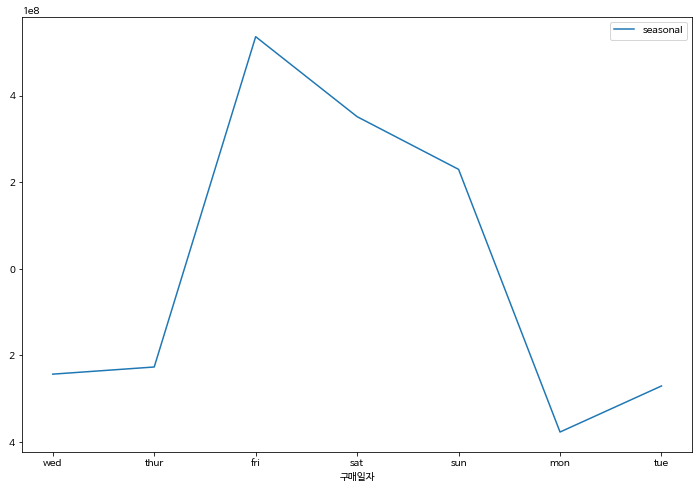

In [ ]:
week_key = {0:'mon', 1:'tue', 2:'wed', 3:'thur', 4:'fri',5:'sat', 6:'sun'}
weekly = pd.DataFrame(result.seasonal[:7])
weekly.index = weekly.index.dayofweek;
weekly.index = weekly.index.map(week_key);
weekly.plot();

- 전체 기준으로는 두드러지는 계절성은 없음
- 일주일 단위 주기성은 뚜렷, 금요일이 젤 매출이 크고 토 일요일로 갈수록 매출이 줌, 월요일이 최저 매출
- 항목별로는 계절성이 존재할 듯?

## 제휴사별 매출액

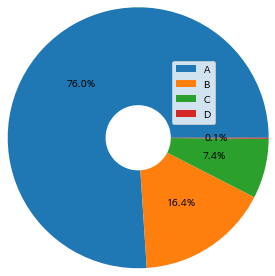

In [ ]:
# A, B, C, D 제휴사의 매출 비중

associates_df = pd.DataFrame(df_purchase_tr.groupby(['제휴사']).구매금액.sum())
associates_df = associates_df/associates_df.sum()

fig = plt.figure(figsize=(3,3))
plt.pie(associates_df, autopct='%.1f%%',labeldistance = 0.8, wedgeprops=dict(width=1.5), radius = 2);
plt.legend(associates_df.index, loc='best');

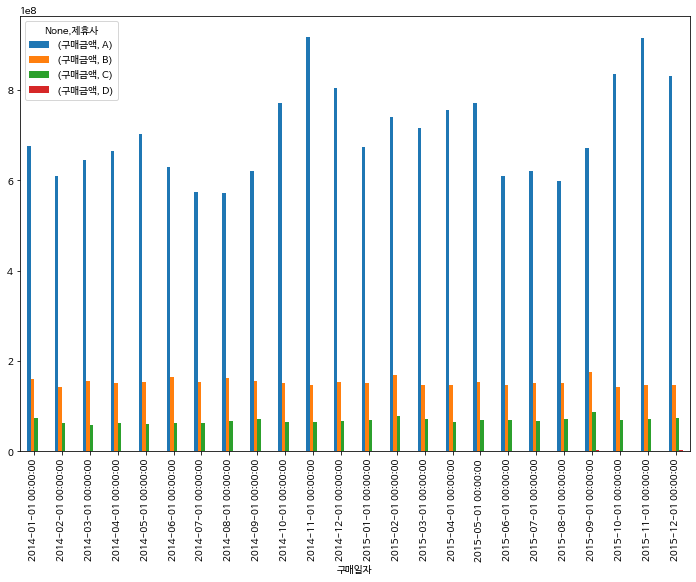

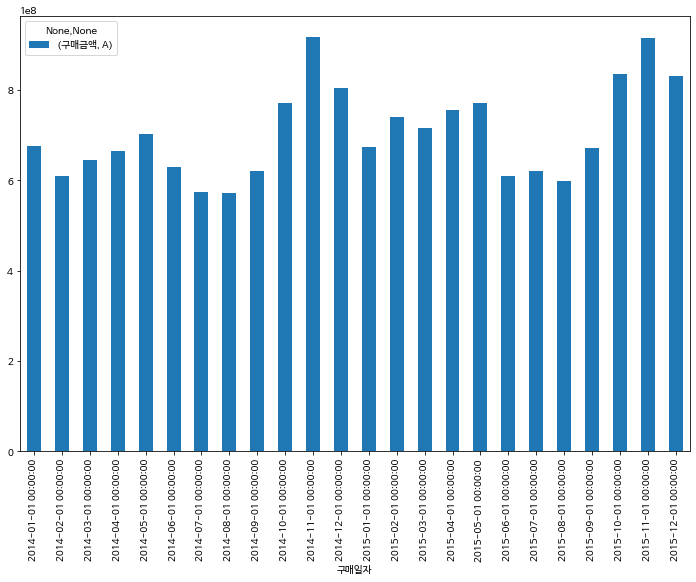

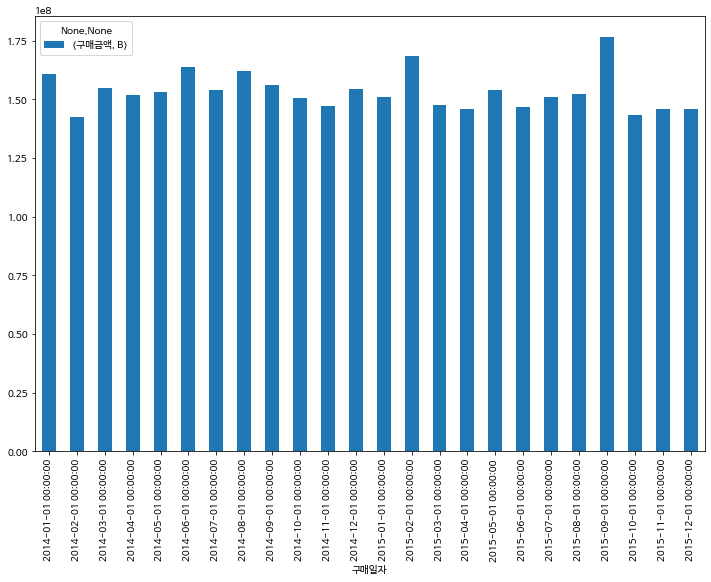

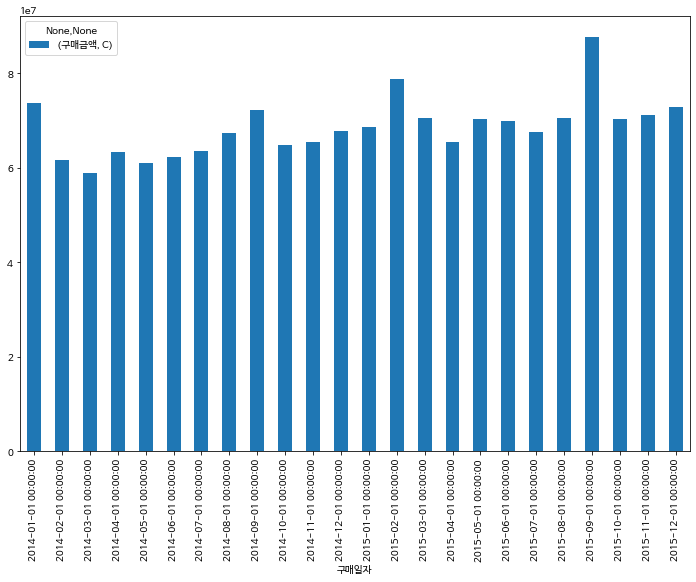

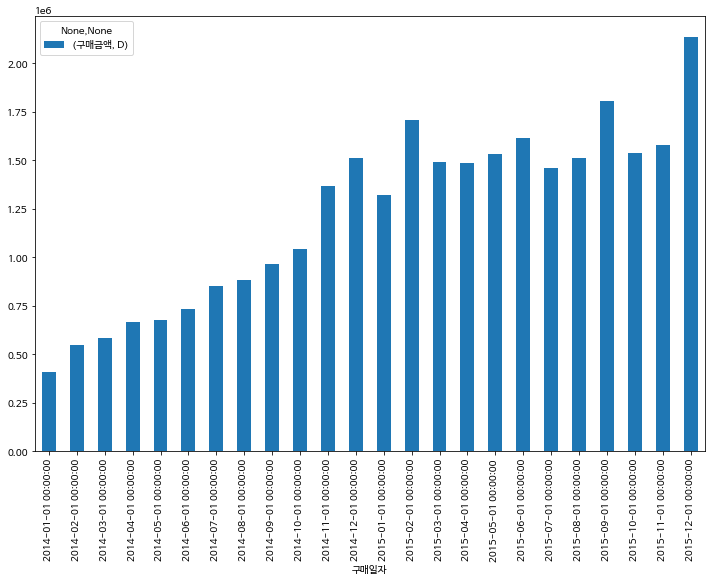

In [ ]:
assot_df = pd.DataFrame(df_purchase_tr.groupby(['구매일자','제휴사']).구매금액.sum())

assot_Y_df = assot_df.unstack().resample('YS').mean()
assot_2Q_df = assot_df.unstack().resample('2QS').mean()
assot_Q_df = assot_df.unstack().resample('QS').mean()
assot_M_df = assot_df.unstack().resample('MS').mean()

# assot_Y_df.plot(kind = 'bar');
# assot_2Q_df.plot(kind = 'bar');
# assot_Q_df.plot(kind = 'bar');
assot_M_df.plot(kind = 'bar');
pd.DataFrame(assot_M_df.iloc[:,0]).plot(kind = 'bar'); 
pd.DataFrame(assot_M_df.iloc[:,1]).plot(kind = 'bar'); 
pd.DataFrame(assot_M_df.iloc[:,2]).plot(kind = 'bar'); 
pd.DataFrame(assot_M_df.iloc[:,3]).plot(kind = 'bar'); 

- 매출의 엄청난 부분을 담당하는 롯데 백화점의 착시효과로 인하여 다른 것도 다 잘되는줄 알았는데 살펴보니 그렇지 않음

- 롯데마트는 정체 또는 감소중

- 롯데슈퍼도 살짝 늘긴 하지만 증가라고 보기 힘듬(혹시 신규매장이 생긴건가 확인 필요)
- 의외로 롭스는 매출이 늘어나고 있는데?  매장이 늘어난건가 확인 필요

### 제휴사별 중분류에 따른 매출액

In [ ]:
# 제휴사별, 중분류 코드에 따른 구매금액
jehyu_df = pd.DataFrame(df_purchase_tr.groupby(['제휴사','중분류코드']).구매금액.sum())

Text(0.5, 1.0, 'A사 중분류 구매금액 비율')

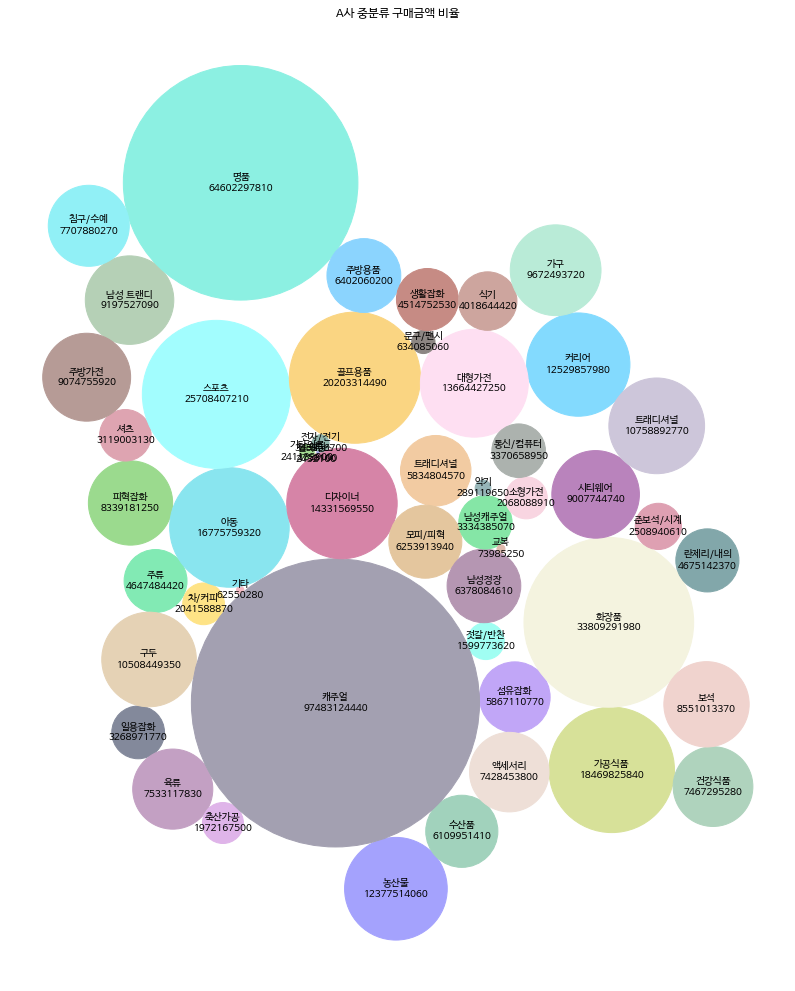

In [ ]:
# A 제휴사의 중분류별 항목 매출 비율
A_revenue_df = jehyu_df.loc['A']
A_revenue_df = pd.merge(A_revenue_df, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= A_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, A_revenue_df.중분류명+'\n'+A_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('A사 중분류 구매금액 비율')

Text(0.5, 1.0, 'B사 중분류 구매금액 비율')

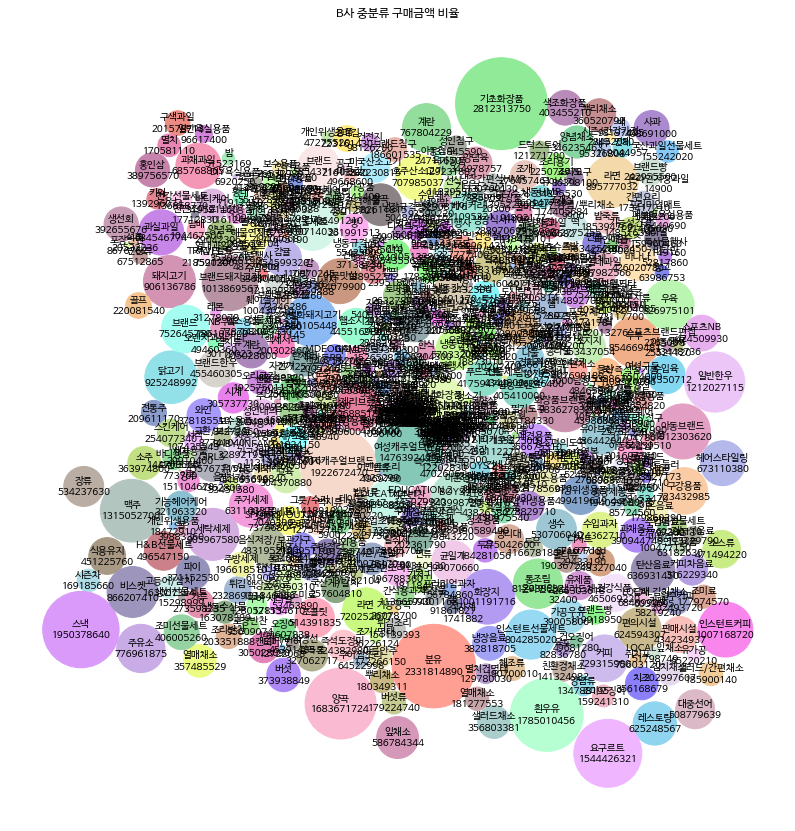

In [ ]:
# B 제휴사의 중분류별 항목 매출 비율
B_revenue_df = jehyu_df.loc['B']
B_revenue_df = pd.merge(B_revenue_df, cat_b_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= B_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, B_revenue_df.중분류명+'\n'+B_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('B사 중분류 구매금액 비율')

Text(0.5, 1.0, 'C사 중분류 구매금액 비율')

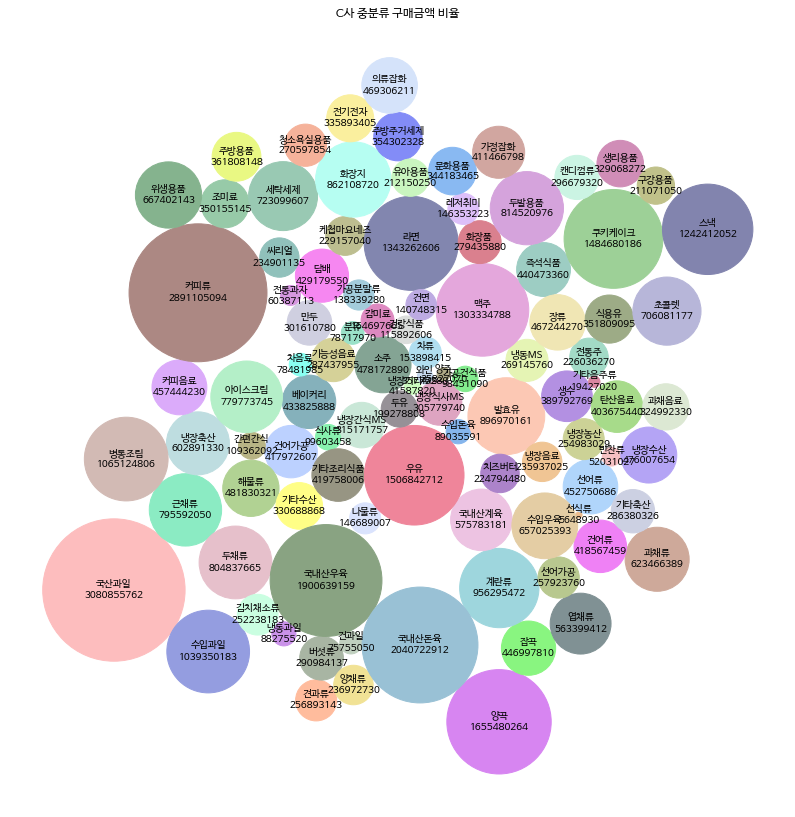

In [ ]:
# C 제휴사의 중분류별 항목 매출 비율
C_revenue_df = jehyu_df.loc['C']
C_revenue_df = pd.merge(C_revenue_df, cat_c_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= C_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, C_revenue_df.중분류명+'\n'+C_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('C사 중분류 구매금액 비율')

Text(0.5, 1.0, 'D사 중분류 구매금액 비율')

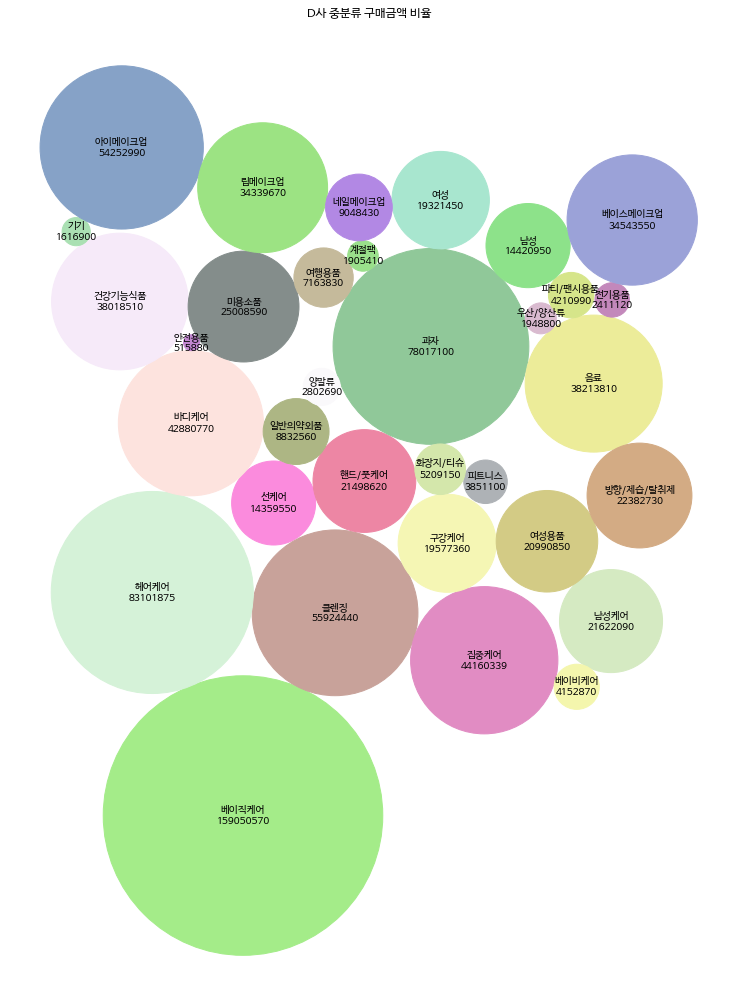

In [ ]:
# D 제휴사의 중분류별 항목 매출 비율
D_revenue_df = jehyu_df.loc['D']
D_revenue_df = pd.merge(D_revenue_df, cat_d_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

bubble_chart = BubbleChart(area= D_revenue_df['구매금액'],bubble_spacing=0.1)
bubble_chart.collapse()
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize= (14,18))
bubble_chart.plot(ax, D_revenue_df.중분류명+'\n'+D_revenue_df['구매금액'].astype(str))
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('D사 중분류 구매금액 비율')

#### 제휴사 A 중분류 매출액 시계열 분석 (상위 N개)
- 중분류 중 매출 상위 N 개 분류 시계열 분석
- 24개월간 


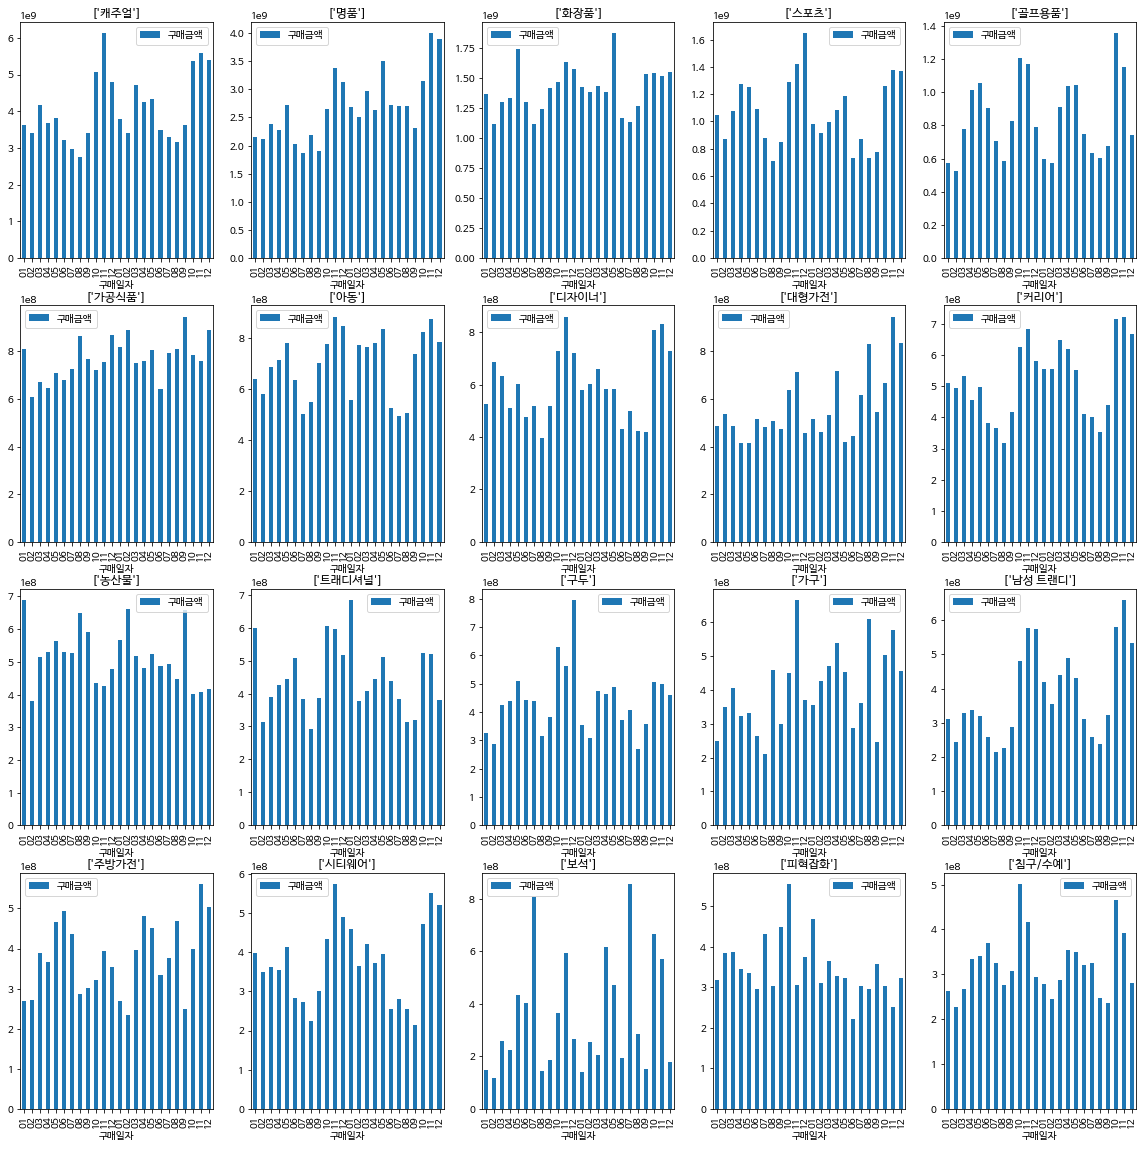

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, DayLocator

#제휴사 A 관련 데이터 
df_A = df_purchase_tr[df_purchase_tr['제휴사'] == 'A'][['구매일자','중분류코드','구매금액']]
df_A.set_index('구매일자',inplace = True) # 시간을 index로

cat_rev = df_A.groupby('중분류코드').resample('MS').sum() # 중분류코드별 기간별 구매금액 합계
cat_rev.drop(columns = '중분류코드', inplace = True)

top_10_cat = df_A.groupby('중분류코드').구매금액.sum().sort_values(ascending = False).index[:20]  # 매출액 상위 10개 품목 번호 리스트

cat_rev = cat_rev[cat_rev.index.get_level_values(0).isin(top_10_cat)]  # 탑10에 자료만 추출
#cat_rev = pd.merge(cat_rev, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

cat_name = cat_a_df[['중분류코드','중분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('중분류코드',inplace = True)

col_n = 5 
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, category  in enumerate(top_10_cat): 
  cat_rev.loc[category].plot(kind = 'bar',ax=ax[int(i/col_n),int(i%col_n)]);
  ax[int(i/col_n),int(i%col_n)].set_title(cat_name.loc[category].values)
  ax[int(i/col_n),int(i%col_n)].set_xticklabels(cat_rev.loc[category].index.format(formatter=lambda x: x.strftime('%m')) )


- 2년치 그래프
- 연말 매출이 많음, 여름도 매출액이 좀 올라감
- 대형가전 등은 결혼시즌? 관련있을듯
- 화장품은 특이하게 여름 매출이 솟을때가 있음(행사? 여름 관광객?)

#### 제휴사 B 중분류 매출액 시계열 분석(상위 N개)

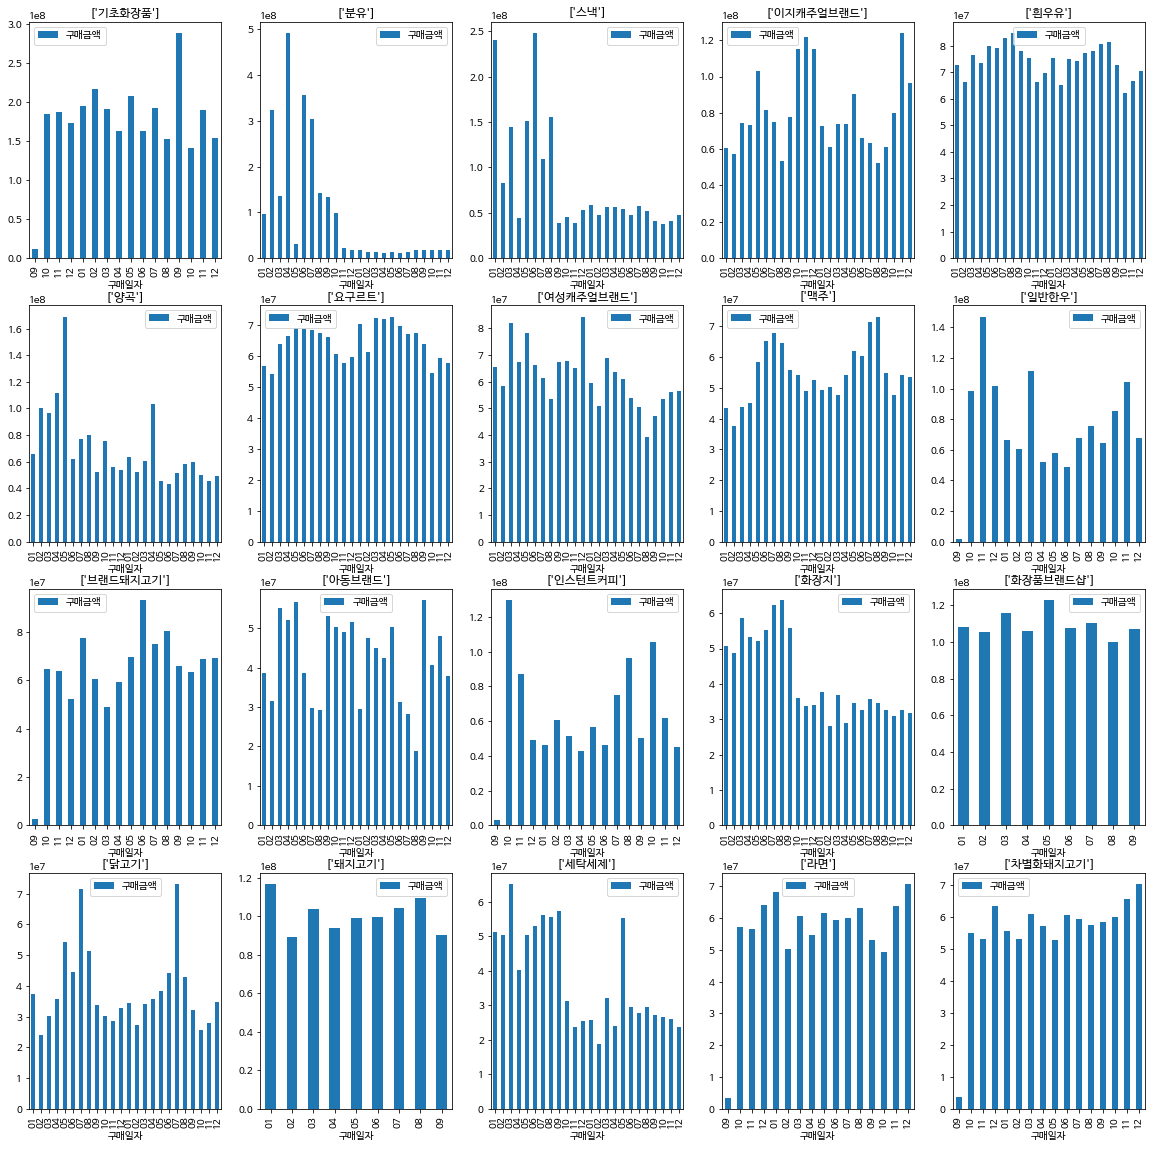

In [ ]:
#제휴사 B 관련 데이터 
df_B = df_purchase_tr[df_purchase_tr['제휴사'] == 'B'][['구매일자','중분류코드','구매금액']]
df_B.set_index('구매일자',inplace = True) # 시간을 index로

cat_rev = df_B.groupby('중분류코드').resample('M').sum().fillna(0) # 중분류코드별 기간별 구매금액 합계
cat_rev.drop(columns = '중분류코드', inplace = True)

top_10_cat = df_B.groupby('중분류코드').구매금액.sum().fillna(0).sort_values(ascending = False).index[:20]  # 매출액 상위 20개 품목 번호 리스트

cat_rev = cat_rev[cat_rev.index.get_level_values(0).isin(top_10_cat)]  # 탑10에 자료만 추출
#cat_rev = pd.merge(cat_rev, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

cat_name = cat_b_df[['중분류코드','중분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('중분류코드',inplace = True)

col_n = 5 
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, category  in enumerate(top_10_cat): 
  cat_rev.loc[category].plot(kind = 'bar',ax=ax[int(i/col_n),int(i%col_n)]);
  ax[int(i/col_n),int(i%col_n)].set_title(cat_name.loc[category].values)
  ax[int(i/col_n),int(i%col_n)].set_xticklabels(cat_rev.loc[category].index.format(formatter=lambda x: x.strftime('%m')) )


24개가 없는 데이터들은 신규 출시된 상품

- 예를 들어 돼지고기는 2015년 4월에 출시
- 차별화돼지고기는 2014년 초에 출시 이런식임

- 분유랑 스낵은 2014년에 무슨일이 있었나...엄청 잘팔렸음

#### 제휴사 C 중분류 매출액 시계열 분석(상위N개)

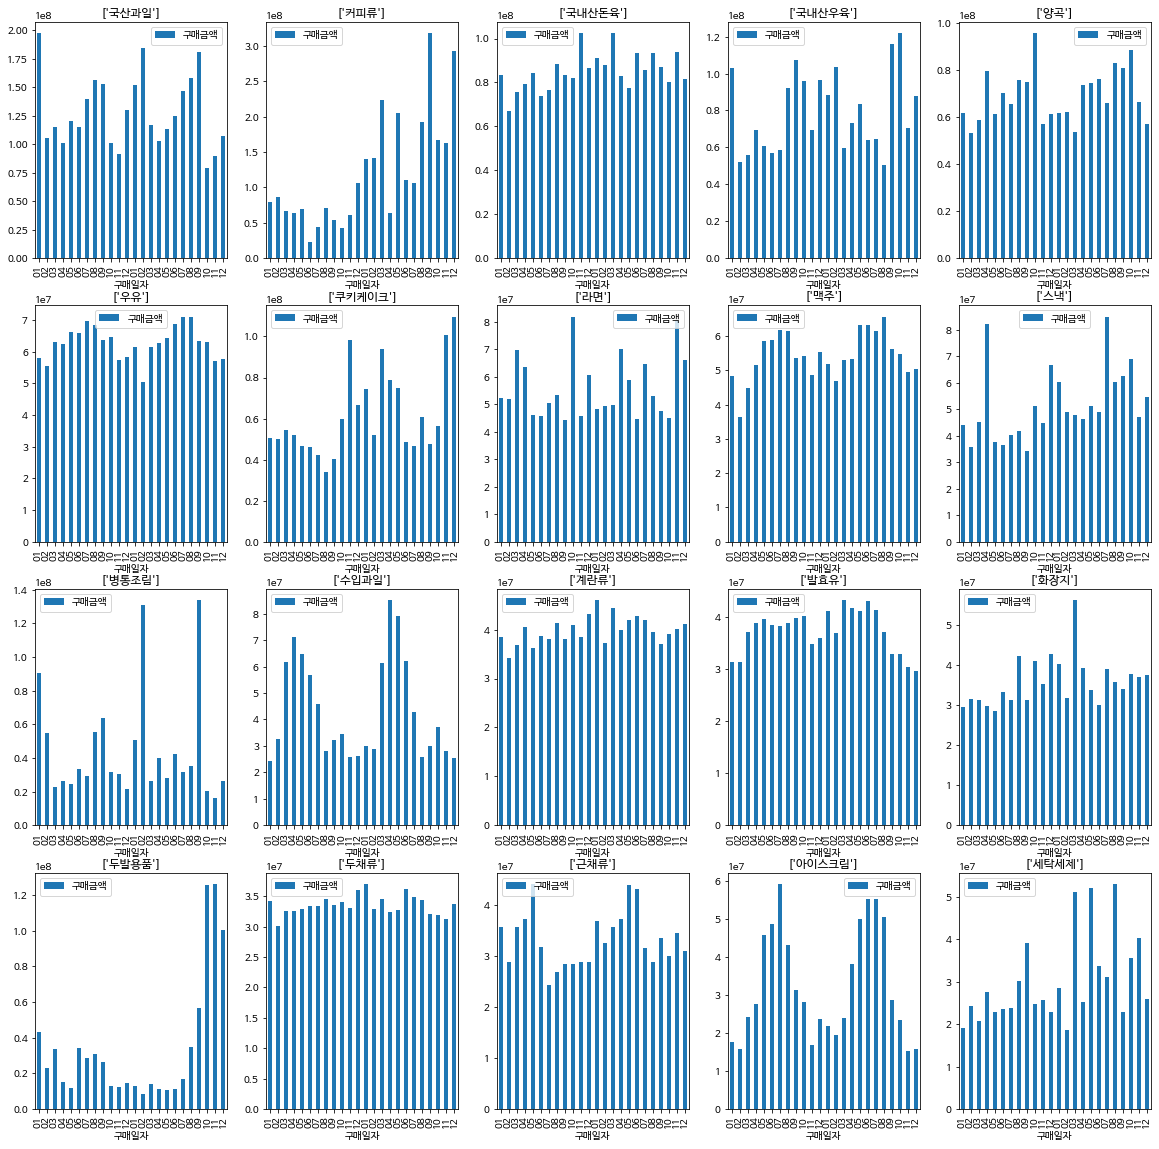

In [ ]:
#제휴사 C 관련 데이터 
df_C = df_purchase_tr[df_purchase_tr['제휴사'] == 'C'][['구매일자','중분류코드','구매금액']]
df_C.set_index('구매일자',inplace = True) # 시간을 index로

cat_rev = df_C.groupby('중분류코드').resample('M').sum() # 중분류코드별 기간별 구매금액 합계
cat_rev.drop(columns = '중분류코드', inplace = True)

top_10_cat = df_C.groupby('중분류코드').구매금액.sum().sort_values(ascending = False).index[:20]  # 매출액 상위 10개 품목 번호 리스트

cat_rev = cat_rev[cat_rev.index.get_level_values(0).isin(top_10_cat)]  # 탑10에 자료만 추출
#cat_rev = pd.merge(cat_rev, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

cat_name = cat_c_df[['중분류코드','중분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('중분류코드',inplace = True)

col_n = 5 
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, category  in enumerate(top_10_cat): 
  cat_rev.loc[category].plot(kind = 'bar',ax=ax[int(i/col_n),int(i%col_n)]);
  ax[int(i/col_n),int(i%col_n)].set_title(cat_name.loc[category].values)
  ax[int(i/col_n),int(i%col_n)].set_xticklabels(cat_rev.loc[category].index.format(formatter=lambda x: x.strftime('%m')) )

#### 제휴사 D 중분류 매출액 시계열 분석(상위 N개)

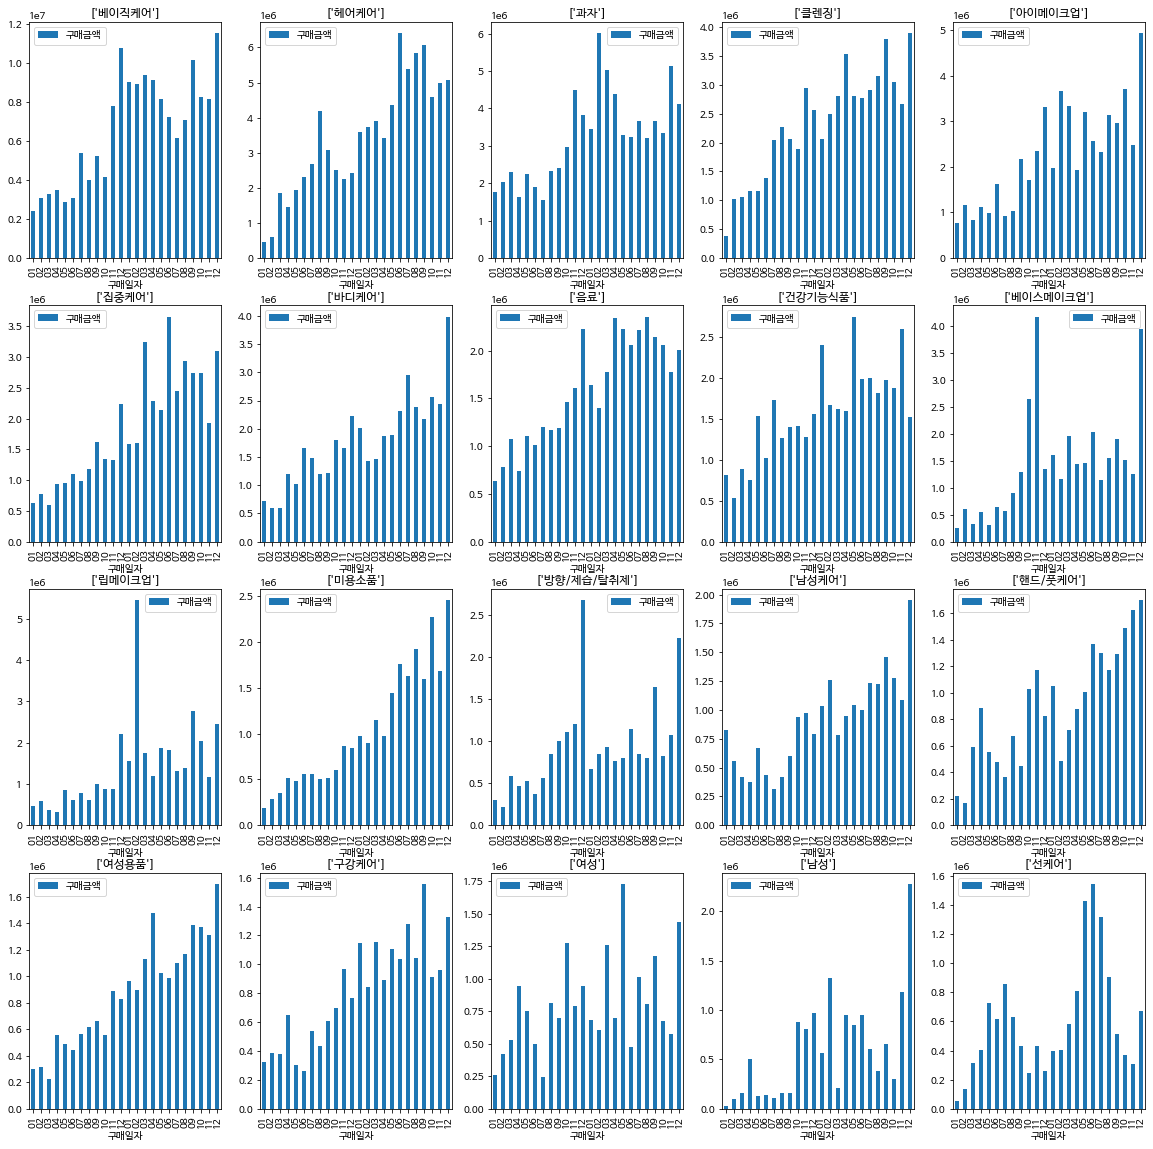

In [ ]:
#제휴사 D 관련 데이터 
df_D = df_purchase_tr[df_purchase_tr['제휴사'] == 'D'][['구매일자','중분류코드','구매금액']]
df_D.set_index('구매일자',inplace = True) # 시간을 index로

cat_rev = df_D.groupby('중분류코드').resample('M').sum() # 중분류코드별 기간별 구매금액 합계
cat_rev.drop(columns = '중분류코드', inplace = True)

top_10_cat = df_D.groupby('중분류코드').구매금액.sum().sort_values(ascending = False).index[:20]  # 매출액 상위 10개 품목 번호 리스트

cat_rev = cat_rev[cat_rev.index.get_level_values(0).isin(top_10_cat)]  # 탑10에 자료만 추출
#cat_rev = pd.merge(cat_rev, cat_a_df[['중분류코드','중분류명']].drop_duplicates(), on=['중분류코드'], how='left')

cat_name = cat_d_df[['중분류코드','중분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('중분류코드',inplace = True)

col_n = 5 
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, category  in enumerate(top_10_cat): 
  cat_rev.loc[category].plot(kind = 'bar',ax=ax[int(i/col_n),int(i%col_n)]);
  ax[int(i/col_n),int(i%col_n)].set_title(cat_name.loc[category].values)
  ax[int(i/col_n),int(i%col_n)].set_xticklabels(cat_rev.loc[category].index.format(formatter=lambda x: x.strftime('%m')) )

## 지점별 분석



### 지점별 합계 매출액 비중

In [ ]:
branch_df = pd.DataFrame(df_purchase_tr.groupby(['제휴사','점포코드']).구매금액.sum())
branch_df.reset_index(inplace = True)
branch_df.구매금액 = branch_df.구매금액/branch_df.구매금액.sum()
branch_df.구매금액 = (100*branch_df.구매금액).round(3)

# treemap 
fig = px.treemap(branch_df, path=['제휴사','점포코드','구매금액'], values = '구매금액')
fig.show()

In [ ]:
branch_df = pd.DataFrame(df_purchase_tr.groupby(['구매일자','제휴사','점포코드']).구매금액.sum())
branch_df.reset_index(inplace = True)
branch_df['점포'] = branch_df.제휴사.astype(str).str.cat(branch_df.점포코드.astype(str))
branch_df.drop(columns={'제휴사','점포코드'},inplace = True)
branch_df  =branch_df.pivot(index = '구매일자', columns = '점포', values = '구매금액' ).fillna(0)
branch_df

점포                   A1         A10         A11         A12         A13  \
구매일자                                                                      
2014-01-01      36200.0         0.0         0.0         0.0         0.0   
2014-01-02   63360920.0  15882570.0   9902280.0  21322130.0   7824900.0   
2014-01-03  107174590.0  68820320.0  36532960.0  79492320.0  14792160.0   
2014-01-04   53608260.0  51648300.0   7792410.0  45118050.0   4219480.0   
2014-01-05   67075120.0  24287770.0  13774070.0  42555330.0   2921470.0   
...                 ...         ...         ...         ...         ...   
2015-12-27  160012620.0  39988070.0  16969820.0  36044330.0   5145710.0   
2015-12-28   34023300.0   5978100.0   1736630.0   8958280.0   3446900.0   
2015-12-29   33707100.0   9029000.0   1448890.0  18069010.0   1517660.0   
2015-12-30   65745880.0  20452980.0   2681740.0  32129920.0   2995300.0   
2015-12-31   77595310.0  16292450.0   3344150.0  23228080.0   6516970.0   

점포                 A14         A15         A16         A17         A18  ...  \
구매일자                                                                    ...   
2014-01-01         0.0         0.0     10100.0         0.0         0.0  ...   
2014-01-02  10387040.0   8003600.0  30282960.0   4988940.0   9193110.0  ...   
2014-01-03  24114330.0  38544960.0  58840880.0  10921700.0  10581430.0  ...   
2014-01-04  18486930.0  12200180.0  40702590.0  11081950.0  16663740.0  ...   
2014-01-05  14242060.0  19429180.0  44584850.0  24004040.0   9611080.0  ...   
...                ...         ...         ...         ...         ...  ...   
2015-12-27  18545340.0  23901310.0  29599840.0   4629600.0   5977620.0  ...   
2015-12-28   9031150.0   1927540.0  12235620.0   2283210.0   1388460.0  ...   
2015-12-29   6098200.0   4684940.0  17680100.0   1995810.0   3084360.0  ...   
2015-12-30   8975480.0   3953610.0  12076230.0   5536140.0   2008650.0  ...   
2015-12-31   5942650.0   5522770.0  14930970.0   3238090.0  10403580.0  ...   

점포              D49       D5       D50      D51       D52      D53        D6  \
구매일자                                                                           
2014-01-01      0.0      0.0       0.0      0.0       0.0      0.0   25200.0   
2014-01-02      0.0  17580.0       0.0      0.0       0.0      0.0    3800.0   
2014-01-03      0.0  85000.0       0.0      0.0       0.0      0.0  121900.0   
2014-01-04      0.0  27650.0       0.0      0.0       0.0      0.0   20900.0   
2014-01-05      0.0   3200.0       0.0      0.0       0.0      0.0   13500.0   
...             ...      ...       ...      ...       ...      ...       ...   
2015-12-27  90400.0      0.0   12150.0    900.0       0.0      0.0   92250.0   
2015-12-28  10000.0   8900.0       0.0  26200.0       0.0      0.0    7350.0   
2015-12-29  25200.0  83600.0  109500.0  70080.0       0.0  95700.0   54620.0   
2015-12-30  10000.0   4580.0   31400.0  27720.0  165980.0  47760.0   16700.0   
2015-12-31  25800.0  29100.0       0.0  66100.0       0.0  51300.0  162350.0   

점포               D7       D8        D9  
구매일자                                    
2014-01-01  54400.0      0.0   48940.0  
2014-01-02  35390.0  22800.0   86380.0  
2014-01-03  37800.0   4280.0   55600.0  
2014-01-04  20700.0   2500.0   14600.0  
2014-01-05  25000.0      0.0   18000.0  
...             ...      ...       ...  
2015-12-27  53350.0  11300.0   49990.0  
2015-12-28  84850.0   2500.0   35400.0  
2015-12-29  48300.0   9000.0   50500.0  
2015-12-30   9000.0   2000.0  109230.0  
2015-12-31  36950.0      0.0   31550.0  

[730 rows x 832 columns]

### 점포 지역 파악

In [ ]:
location_df = pd.merge(df_purchase_tr[['고객번호','제휴사','점포코드']],df_members[['고객번호','거주지역','거주지역이름']].drop_duplicates(subset = '고객번호'), on = '고객번호',how = 'left')
location_df= location_df.groupby(['제휴사','점포코드'])[['거주지역','거주지역이름']].agg(lambda x:x.mode())
location_df = location_df.reset_index()
location_df['점포'] = location_df.제휴사.astype(str).str.cat(location_df.점포코드.astype(str))
location_df.drop(columns=['제휴사','점포코드'],inplace =True)
location_df

거주지역 거주지역이름   점포
0    100.0     서울   A1
1     55.0     서울   A2
2     24.0     서울   A3
3    460.0     부산   A4
4     69.0     서울   A5
..     ...    ...  ...
827  100.0     경기  D49
828  100.0     경기  D50
829  100.0     경기  D51
830   33.0     서울  D52
831  100.0     경기  D53

[832 rows x 3 columns]

- 지점 갯수: 백화점 51개, 롯데마트 135개, 롯데슈퍼 593개, 롭스 53개
- 각각의 매출 비중 및 시계열 분석
- 매출이 증가/ 감소 하는지, 신규매장인지, 가능하다면 어느지역인지 분석

### 지점별 시계열

#### 백화점 지점별 분석 (51개 지점)

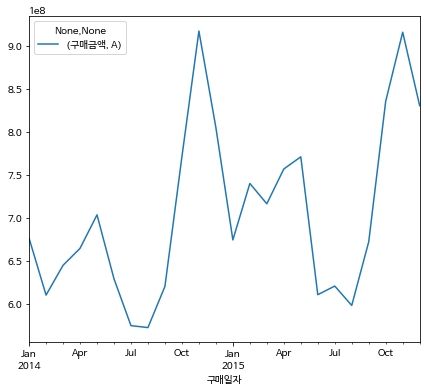

In [ ]:
# 백화점 전체 매출 시계열
pd.DataFrame(assot_M_df.iloc[:,0]).plot(figsize = (7,6)); 

In [ ]:
# 백화점 데이터 가져오기
branchA_df = branch_df.iloc[:,:51].copy()
branchA_df = branchA_df.resample('MS').mean()

In [ ]:
# 신규매장/수리매장/폐점매장 및 운영 개월 수
branchA_df.loc['신규'] = branchA_df.apply(lambda x : len(x[x == 0]))
new_br = branchA_df.loc[:,branchA_df.loc['신규'] != 0]
for new, count in zip(new_br.columns, 24-new_br.loc['신규'].astype(int)):
  print(new,':', count, '개월 운영')
print('\n',len(new_br.T),'개 매장 신규/수리/폐점')
branchA_df.drop(new_br.columns, axis = 1,inplace = True)   # 신규매장을 제외할 것인가? 말것인가?
branchA_df.drop('신규', axis = 0,inplace = True)

A42 : 15 개월 운영
A43 : 15 개월 운영
A44 : 14 개월 운영
A45 : 13 개월 운영
A46 : 13 개월 운영
A47 : 13 개월 운영
A48 : 8 개월 운영
A49 : 5 개월 운영
A50 : 4 개월 운영
A51 : 1 개월 운영

 10 개 매장 신규/수리/폐점


In [ ]:
# 매출액 순서로 정렬
branchA_df.loc['합계'] = branchA_df.sum()
branchA_df= branchA_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

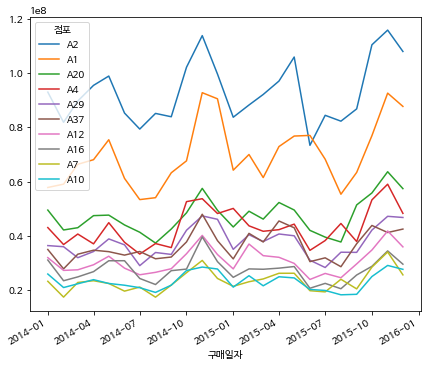

In [ ]:
branchA_df.iloc[:,:10].plot(figsize = (7,6)); # 백화점 매출 상위 10개사 매출액 그래프

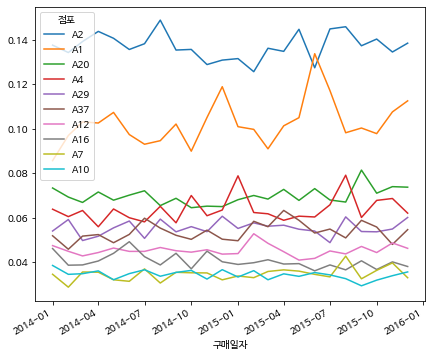

In [ ]:
# 평활화 후 상위 10개사  상대 매출
branchA_df.iloc[:,:10].div(branchA_df.sum(axis = 1),axis = 0).plot(figsize = (7,6));  

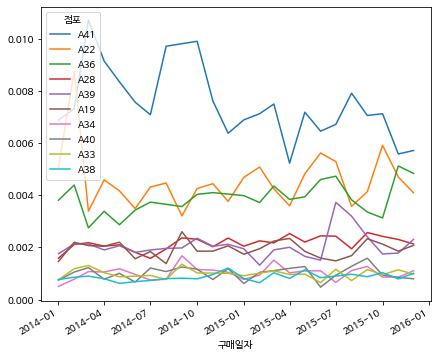

In [ ]:
# 매출액 하위 10개 지점 평활화 후 상대 매출액
branchA_df.iloc[:,-10:].div(branchA_df.sum(axis = 1),axis = 0).plot(figsize = (7,6));  

- 일부 매장에서 심각한 매출 감소가 보임 : 이런 매장들 위주로 분석해보면 solution이 보일것 같습니다

#### 마트 지점별 분석(135개 지점)


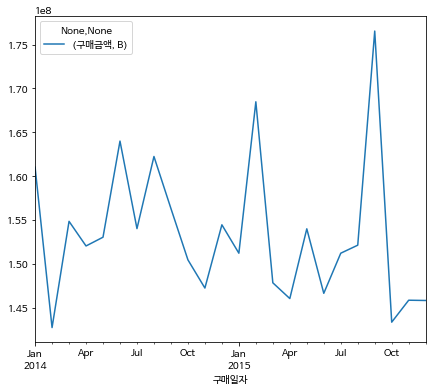

In [ ]:
# 마트 전체 매출 시계열
pd.DataFrame(assot_M_df.iloc[:,1]).plot(figsize = (7,6)); 

In [ ]:
# 마트 데이터 가져오기
branchB_df = branch_df.iloc[:,51:186].copy()
branchB_df = branchB_df.resample('MS').mean()

In [ ]:
# 신규매장/수리매장/폐점매장 및 운영 개월 수
branchB_df.loc['신규'] = branchB_df.apply(lambda x : len(x[x == 0]))
new_br = branchB_df.loc[:,branchB_df.loc['신규'] != 0]
for new, count in zip(new_br.columns, 24-new_br.loc['신규'].astype(int)):
  print(new,':', count, '개월 운영')
print('\n',len(new_br.T),'개 매장 신규/수리/폐점')
branchB_df.drop(new_br.columns, axis = 1,inplace = True)   # 신규매장을 제외할 것인가? 말것인가?
branchB_df.drop('신규', axis = 0,inplace = True)

B103 : 1 개월 운영
B104 : 11 개월 운영
B105 : 14 개월 운영
B107 : 17 개월 운영
B108 : 13 개월 운영
B124 : 18 개월 운영
B131 : 20 개월 운영
B134 : 19 개월 운영
B135 : 21 개월 운영
B16 : 15 개월 운영
B17 : 17 개월 운영
B35 : 13 개월 운영
B37 : 10 개월 운영
B5 : 15 개월 운영
B50 : 14 개월 운영
B51 : 9 개월 운영
B55 : 13 개월 운영
B61 : 21 개월 운영
B62 : 13 개월 운영
B63 : 10 개월 운영
B64 : 9 개월 운영

 21 개 매장 신규/수리/폐점


In [ ]:
# 매출액 순서로 정렬
branchB_df.loc['합계'] = branchB_df.sum()
branchB_df= branchB_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

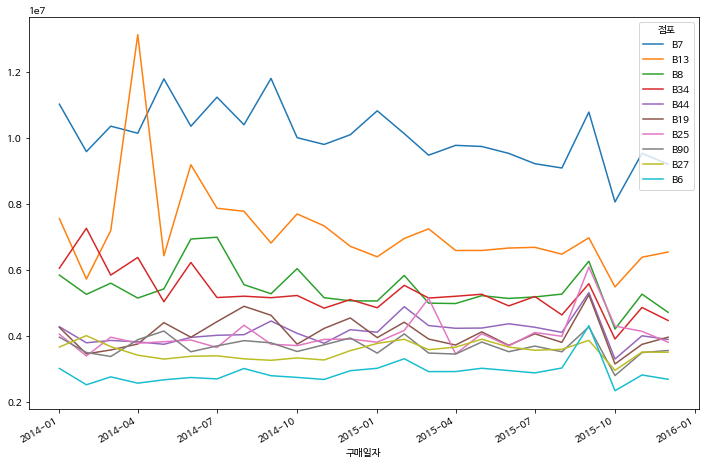

In [ ]:
branchB_df.iloc[:,:10].plot(); # 매출 상위 10개 지점 그래프

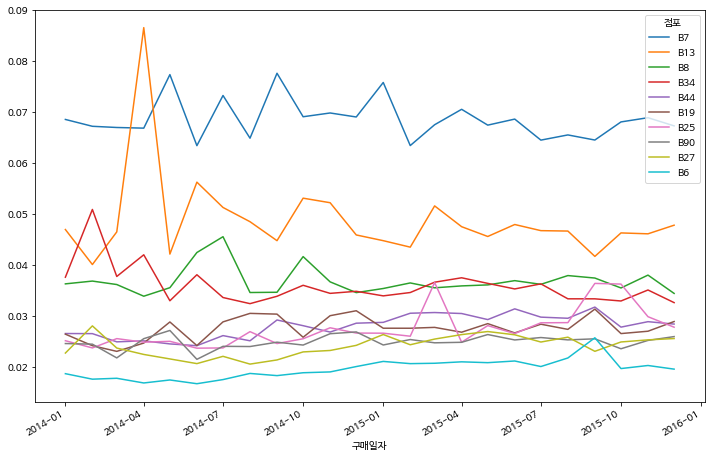

In [ ]:
# 평활화 후 상위 10개사  상대 매출
branchB_df.iloc[:,:10].div(branchB_df.sum(axis = 1),axis = 0).plot();  

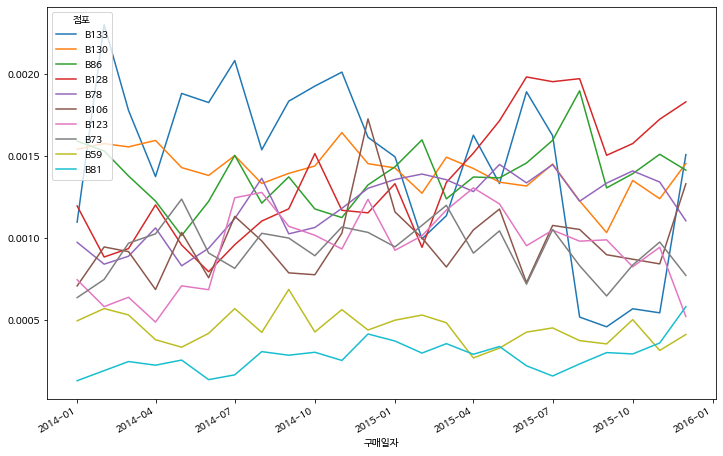

In [ ]:
# 매출액 하위 10개 지점 평활화 후 상대 매출액
branchB_df.iloc[:,-10:].div(branchB_df.sum(axis = 1),axis = 0).plot();  

#### 슈퍼 지점별 분석 (593개 지점)

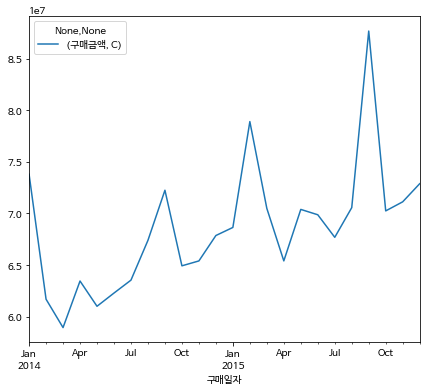

In [ ]:
# 마트 전체 매출 시계열
pd.DataFrame(assot_M_df.iloc[:,2]).plot(figsize = (7,6)); 

In [ ]:
# 마트 데이터 가져오기
branchC_df = branch_df.iloc[:,186:779].copy()
branchC_df = branchC_df.resample('MS').mean()

In [ ]:
# 신규매장/수리매장/폐점매장 및 운영 개월 수
branchC_df.loc['신규'] = branchC_df.apply(lambda x : len(x[x == 0]))
new_br = branchC_df.loc[:,branchC_df.loc['신규'] != 0]
for new, count in zip(new_br.columns, 24-new_br.loc['신규'].astype(int)):
  print(new,':', count, '개월 운영')
print('\n',len(new_br.T),'개 매장 신규/수리/폐점')
branchC_df.drop(new_br.columns, axis = 1,inplace = True)   # 신규매장을 제외할 것인가? 말것인가?
branchC_df.drop('신규', axis = 0,inplace = True)

C106 : 2 개월 운영
C112 : 18 개월 운영
C117 : 6 개월 운영
C135 : 6 개월 운영
C137 : 6 개월 운영
C138 : 11 개월 운영
C157 : 12 개월 운영
C161 : 19 개월 운영
C172 : 1 개월 운영
C198 : 16 개월 운영
C199 : 18 개월 운영
C200 : 15 개월 운영
C201 : 8 개월 운영
C204 : 21 개월 운영
C216 : 10 개월 운영
C247 : 22 개월 운영
C250 : 17 개월 운영
C256 : 21 개월 운영
C280 : 12 개월 운영
C296 : 15 개월 운영
C304 : 20 개월 운영
C313 : 16 개월 운영
C326 : 1 개월 운영
C348 : 23 개월 운영
C359 : 23 개월 운영
C360 : 22 개월 운영
C361 : 22 개월 운영
C362 : 20 개월 운영
C363 : 20 개월 운영
C364 : 20 개월 운영
C365 : 19 개월 운영
C366 : 18 개월 운영
C367 : 18 개월 운영
C368 : 18 개월 운영
C369 : 17 개월 운영
C370 : 16 개월 운영
C371 : 16 개월 운영
C372 : 15 개월 운영
C373 : 15 개월 운영
C374 : 15 개월 운영
C375 : 14 개월 운영
C376 : 14 개월 운영
C377 : 14 개월 운영
C378 : 13 개월 운영
C379 : 11 개월 운영
C380 : 12 개월 운영
C381 : 10 개월 운영
C382 : 9 개월 운영
C383 : 8 개월 운영
C384 : 8 개월 운영
C385 : 7 개월 운영
C386 : 6 개월 운영
C387 : 6 개월 운영
C388 : 6 개월 운영
C389 : 6 개월 운영
C390 : 5 개월 운영
C391 : 5 개월 운영
C392 : 5 개월 운영
C393 : 4 개월 운영
C394 : 4 개월 운영
C395 : 3 개월 운영
C396 : 3 개월 운영
C397 : 3 개월 운영
C398 : 1 개월 운영


In [ ]:
# 매출액 순서로 정렬
branchC_df.loc['합계'] = branchC_df.sum()
branchC_df= branchC_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

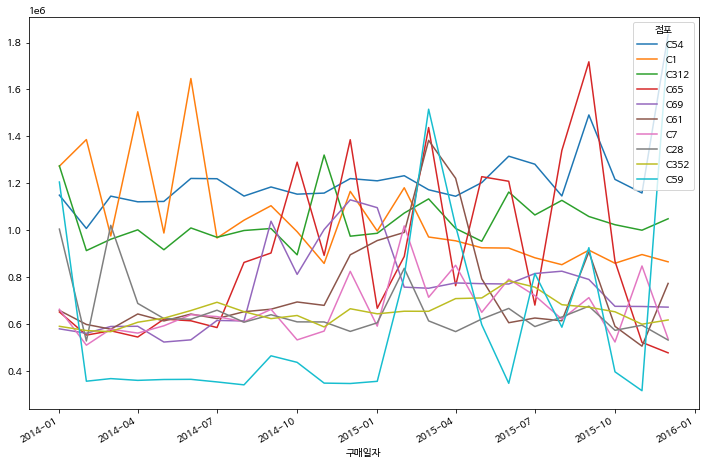

In [ ]:
branchC_df.iloc[:,:10].plot(); # 매출 상위 10개 지점 그래프

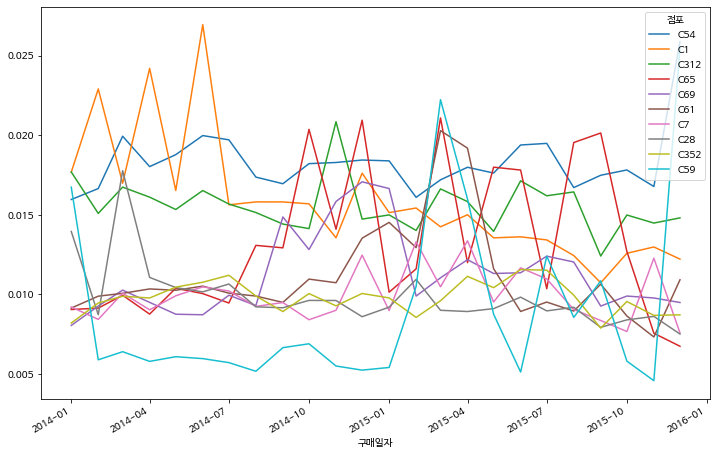

In [ ]:
# 평활화 후 상대 순위
branchC_df.iloc[:,:10].div(branchC_df.sum(axis = 1),axis = 0).plot();  

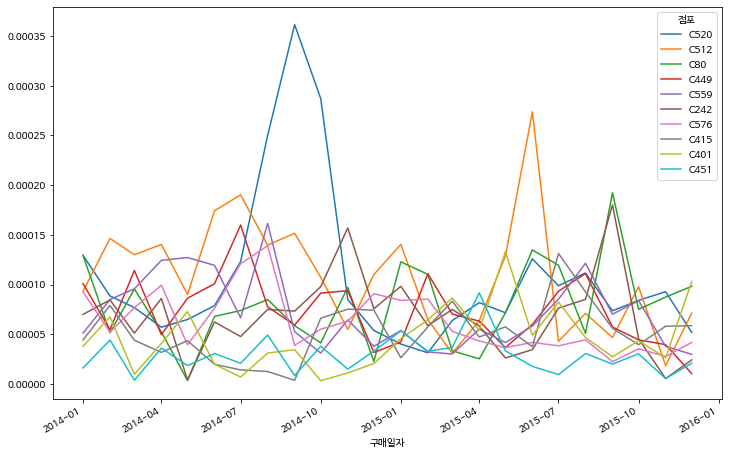

In [ ]:
# 매출액 하위 10개 지점 평활화 후 상대 매출액
branchC_df.iloc[:,-10:].div(branchC_df.sum(axis = 1),axis = 0).plot();  

#### 롭스 지점별 분석(53개 지점)

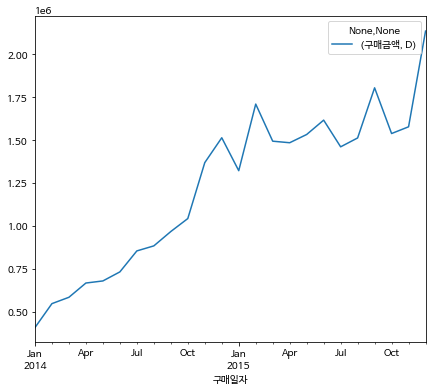

In [ ]:
# 롭스 전체 매출 시계열
pd.DataFrame(assot_M_df.iloc[:,3]).plot(figsize = (7,6)); 

In [ ]:
# 마트 데이터 가져오기
branchD_df = branch_df.iloc[:,779:].copy()
branchD_df = branchD_df.resample('MS').mean()

In [ ]:
# 신규매장/수리매장/폐점매장 및 운영 개월 수
branchD_df.loc['신규'] = branchD_df.apply(lambda x : len(x[x == 0]))
new_br = branchD_df.loc[:,branchD_df.loc['신규'] != 0]
for new, count in zip(new_br.columns, 24-new_br.loc['신규'].astype(int)):
  print(new,':', count, '개월 운영')
print('\n',len(new_br.T),'개 매장 신규/수리/폐점')
branchD_df.drop(new_br.columns, axis = 1,inplace = True)   # 신규매장을 제외할 것인가? 말것인가?
branchD_df.drop('신규', axis = 0,inplace = True)

D12 : 23 개월 운영
D13 : 22 개월 운영
D14 : 21 개월 운영
D15 : 21 개월 운영
D16 : 20 개월 운영
D17 : 18 개월 운영
D18 : 17 개월 운영
D19 : 17 개월 운영
D20 : 15 개월 운영
D21 : 15 개월 운영
D22 : 15 개월 운영
D23 : 15 개월 운영
D24 : 15 개월 운영
D25 : 14 개월 운영
D26 : 14 개월 운영
D27 : 13 개월 운영
D28 : 13 개월 운영
D29 : 13 개월 운영
D30 : 13 개월 운영
D31 : 12 개월 운영
D32 : 11 개월 운영
D33 : 11 개월 운영
D34 : 3 개월 운영
D35 : 8 개월 운영
D36 : 7 개월 운영
D37 : 6 개월 운영
D38 : 6 개월 운영
D39 : 6 개월 운영
D40 : 5 개월 운영
D41 : 5 개월 운영
D42 : 4 개월 운영
D43 : 4 개월 운영
D44 : 2 개월 운영
D45 : 3 개월 운영
D46 : 3 개월 운영
D47 : 2 개월 운영
D48 : 2 개월 운영
D49 : 2 개월 운영
D50 : 2 개월 운영
D51 : 1 개월 운영
D52 : 1 개월 운영
D53 : 1 개월 운영

 42 개 매장 신규/수리/폐점


In [ ]:
# 매출액 순서로 정렬
branchD_df.loc['합계'] = branchD_df.sum()
branchD_df= branchD_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

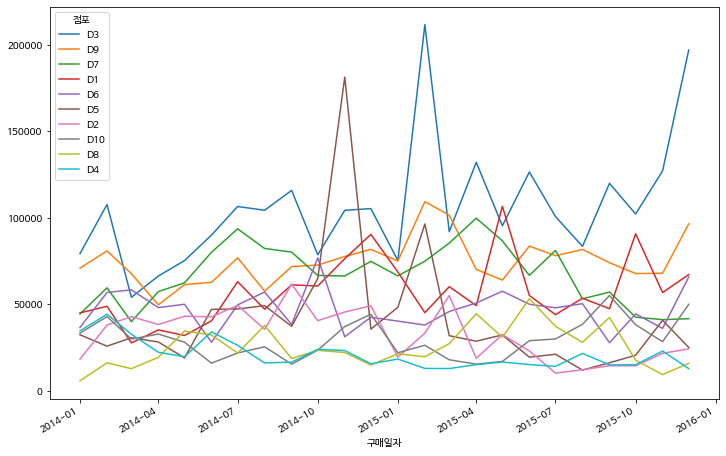

In [ ]:
branchD_df.iloc[:,:10].plot(); # 롭스

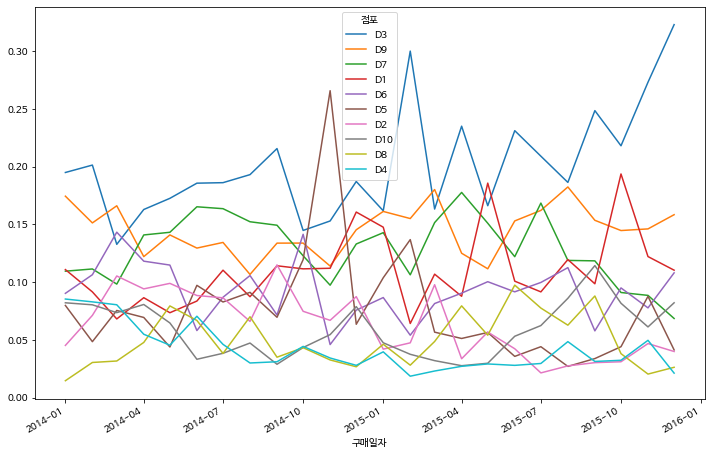

In [ ]:
# 평활화 후 상대 순위
branchD_df.iloc[:,:10].div(branchD_df.sum(axis = 1),axis = 0).plot();  

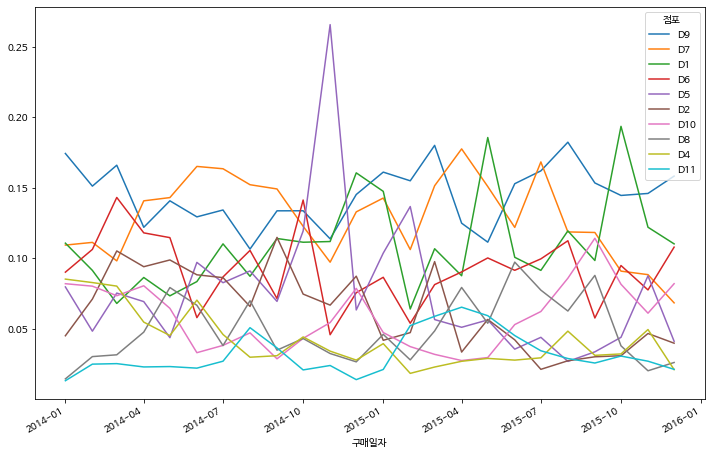

In [ ]:
# 매출액 하위 10개 지점 평활화 후 상대 매출액
branchD_df.iloc[:,-10:].div(branchD_df.sum(axis = 1),axis = 0).plot();  

### 개별 지점 분석(물품, 고객, 지역 등 상세 feature 위주로)

#### 마트 분석

- 실제로 마트가 가장 심각한 매출 감소, 고객 이탈을 보여주고 있기때문에 선정

In [ ]:
# 연간, 반기, 분기 모두 매출이 감소하는 매장
# 문제가 있을확률이 높음.
# 매출 감소 매장이 특정지역에 쏠려서 있는 것은 아님
# branchBB_cat = branchB_cat[(branchB_cat.분기매출증가 == 0) & (branchB_cat.반기매출증가 == 0) &	(branchB_cat.연간매출증가== 0)].reset_index()
# branchBB_cat= pd.merge(branchBB_cat, location_df, on ='점포', how = 'left')
# branchBB_cat.거주지역이름.value_counts()

In [ ]:
# # 연간/반기/분기 연속 매출 감소 매장 숫자
# len(branchBB_cat)

##### B7 매장 분석

- 연간/반기/분기별로 매출액이 감소하고 있는 매장 중에 매출액이 가장 큰 매장

In [ ]:
# 서울에 위치한 매장임
# branchBB_cat[branchBB_cat.점포 =='B7'].거주지역이름

In [ ]:
# 매출 기록중에 B7 점포 관련 데이터만 추출
branchB7_df = df_purchase_tr[(df_purchase_tr.제휴사 == 'B') & (df_purchase_tr.점포코드 == 7)]

In [ ]:
# 분류별 매출
branchB7_df = pd.merge(branchB7_df, df_merchant_cl[['제휴사','중분류코드',	'분류']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
branchB7seq_df= branchB7_df.groupby(['구매일자','분류']).구매금액.sum().unstack().fillna(0).resample('MS').sum()
branchB7seq_df.loc['합계'] = branchB7seq_df.sum()
branchB7seq_df = branchB7seq_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

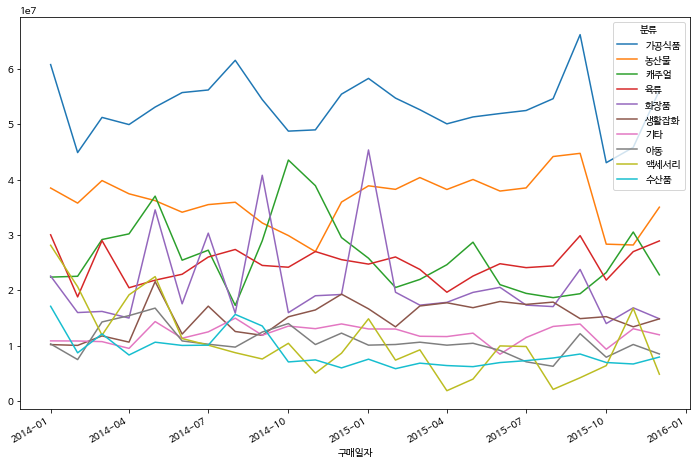

In [ ]:
# branchB7seq_df : 분류별 시계열 매출액 합계
branchB7seq_df.iloc[:,:10].plot();  # 매출액 상위 10개 품목 시계열 그래프
# 전반적으로 매출이 감소하고 있음을 알 수 있음
# 매출 항목은 주로 일상용품이 대다수

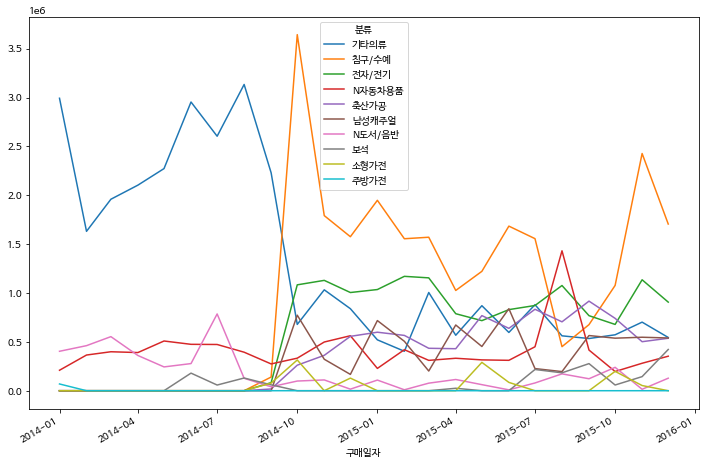

In [ ]:
# 하위 매출 10개 품목 시계열 그래프
branchB7seq_df.iloc[:,-10:].plot();

##### B89 매장 분석

- 연간/반기/분기별로 매출액이 감소하고 있는 매장 중에 매출액이 가장 작은 매장 중에 하나

In [ ]:
# 경남에 위치한 매장임
# branchBB_cat[branchBB_cat.점포 =='B89'].거주지역이름

In [ ]:
# 매출 기록중에 B89 점포 관련 데이터만 추출
branchB89_df = df_purchase_tr[(df_purchase_tr.제휴사 == 'B') & (df_purchase_tr.점포코드 == 89)]

In [ ]:
# 분류별 매출
branchB89_df = pd.merge(branchB89_df, df_merchant_cl[['제휴사','중분류코드',	'분류']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
branchB89seq_df= branchB89_df.groupby(['구매일자','분류']).구매금액.sum().unstack().fillna(0).resample('MS').sum()
branchB89seq_df.loc['합계'] = branchB89seq_df.sum()
branchB89seq_df = branchB89seq_df.T.sort_values(by = '합계',ascending = False).drop(columns = '합계').T

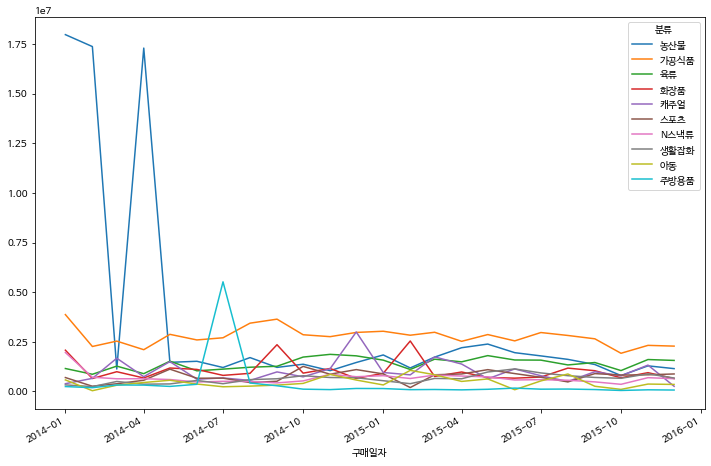

In [ ]:
#89번이면 비교적 최근에 문을 연 매장임
# branchB89seq_df : 분류별 시계열 매출액 합계
branchB89seq_df.iloc[:,:10].plot();  # 매출액 상위 10개 품목 시계열 그래프
# 전반적으로 매출이 감소하고 있음을 알 수 있음
# 매출 항목은 주로 일상용품이 대다수

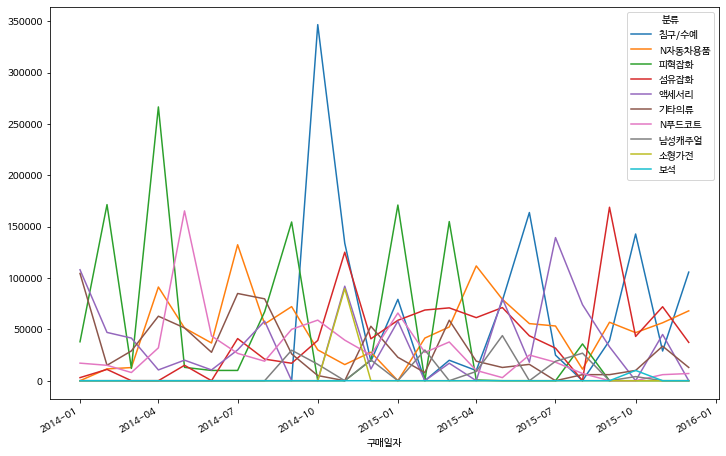

In [ ]:
# 하위 매출 10개 품목 시계열 그래프
branchB89seq_df.iloc[:,-10:].plot();

## 고객 개인별 분석


### 시계열 개인 거래금액 (Monthly)

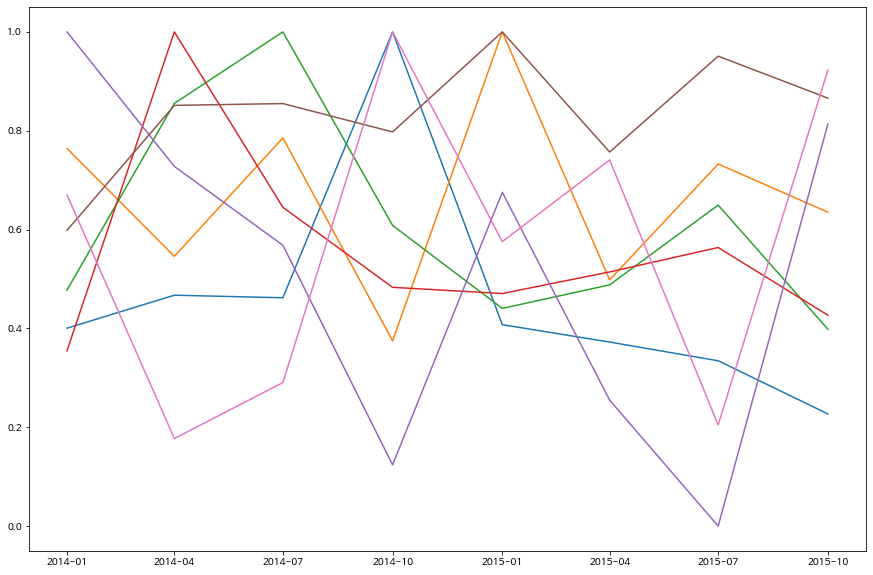

In [ ]:
# 고객별 구매금액

user_df = pd.DataFrame(df_purchase_tr.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df = user_df.unstack()['구매금액'].fillna(0).T
user_df1 = user_df.resample('QS').mean().fillna(0)
#user_df = user_df.unstack().fillna(0).resample('M').mean().fillna(0)   # 개별 고객의 월별 구매금액 평균


user_df1 = user_df1/user_df1.max()
# 1번 10번까지 고객의 매달 구매금액 합계 그래프
plt.figure(figsize = (15,10))
for i in range (7) :
  plt.plot(user_df1[i+1]);

### RFM 분석

https://www.datarian.io/blog/what-is-rfm

In [ ]:
# 구매금액이 큰 고객 분류
user_rev_sum = user_df.sum()
user_rev_sum.sort_values(ascending = False, inplace = True)
user_rev_sum = pd.DataFrame(user_rev_sum)
# 구매횟수, 최근 구매일자 구하기
user_freq_recency = df_purchase_tr[['제휴사','고객번호','구매일자']].drop_duplicates()
# 영수증번호를 기준으로 frequency를 찾아도 되지만 한 제휴사에서 여러군데 쇼핑한 경우가 있어서 다른 방식으로 함
# df_purchase_tr[['고객번호','영수증번호']].drop_duplicates().groupby('고객번호').영수증번호.count() 
user_freq = pd.DataFrame(user_freq_recency.groupby('고객번호').구매일자.count())
user_recency = pd.DataFrame(user_freq_recency.groupby('고객번호').구매일자.max())

user_freq.rename(columns = {'구매일자':'Frequency'}, inplace = True)
user_recency.rename(columns = {'구매일자':'Recency'}, inplace = True)
user_rev_sum.rename(columns = {0:'Monetary'}, inplace = True)

In [ ]:
user_rfm = pd.merge(user_recency, user_freq,left_index=True, right_index=True,how='left')
user_rfm = pd.merge(user_rfm, user_rev_sum,left_index=True, right_index=True,how='left')

d1 = datetime(2013, 12, 31)
user_rfm['Recency']  = user_rfm['Recency'].apply(lambda x : (x-d1).days) 

- 제휴사별 RFM


In [ ]:
# 제휴사별 Recency
jehyu_recency = user_freq_recency.groupby(['고객번호','제휴사']).구매일자.max().unstack()
jehyu_recency =jehyu_recency.apply(lambda x: pd.to_datetime(x))
d1 = datetime(2013, 12, 31)
jehyu_recency = jehyu_recency.applymap(lambda x : (x-d1).days).fillna(0)   # None 값을 2000으로, 오래 안갔을수록 숫자가 크므로 한번도 안갔으면 매우 큰값을 줘 보기로 함
jehyu_recency = jehyu_recency.div(jehyu_recency.sum(axis = 1), axis = 0)
jehyu_recency.columns = ['A_recency','B_recency','C_recency','D_recency']

In [ ]:
# 제휴사별 Frequency
jehyu_frequency = user_freq_recency.groupby(['고객번호','제휴사']).구매일자.count().unstack().fillna(0)
jehyu_frequency = jehyu_frequency.div(jehyu_frequency.sum(axis = 1), axis = 0)
jehyu_frequency.columns = ['A_frequency','B_frequency','C_frequency','D_frequency']

In [ ]:
# 제휴사별 Monetary
jehyu_Monetary = df_purchase_tr.groupby(['고객번호','제휴사']).구매금액.sum().unstack().fillna(0)
jehyu_Monetary = jehyu_Monetary.div(jehyu_Monetary.sum(axis = 1), axis = 0)
jehyu_Monetary.columns = ['A_Monetary_비율','B_Monetary_비율','C_Monetary_비율','D_Monetary_비율']

In [ ]:
# 가장 돈많이 쓴 10명 및 금액
#pd.options.display.float_format = '{:.0f}'.format

user_rfm.sort_values('Monetary', ascending = False)[:10]

Recency  Frequency      Monetary
고객번호                                   
15999      730        205  3.571832e+09
14599      728        234  2.640330e+09
7957       642        169  2.134909e+09
16406      730        213  1.881645e+09
6207       728        260  1.721008e+09
8079       729        166  1.489527e+09
6200       730        288  1.258798e+09
13376      730        283  1.106456e+09
2348       674        146  1.066755e+09
3833       730        185  1.012258e+09

In [ ]:
# 가장 자주 방문한 10명
user_rfm.sort_values('Frequency', ascending = False)[:10]

Recency  Frequency     Monetary
고객번호                                  
3975       730       1039   28890669.0
15142      730        977   46758904.0
457        730        963  153767286.0
16772      730        947  156773046.0
5308       730        899  292233536.0
11315      730        890   17199856.0
928        730        865  118650621.0
7178       730        844   58788724.0
503        730        840   94925854.0
15194      730        817   18255893.0

In [ ]:
# 방문횟수 별 몇명인가?
# 1번 10명 2번 6명 등등
user_rfm.Frequency.value_counts().sort_index()

1       10
2        6
3        6
4        3
5        8
        ..
899      1
947      1
963      1
977      1
1039     1
Name: Frequency, Length: 715, dtype: int64

In [ ]:
# 가장 방문한 날짜가 오래된 10명 
user_rfm.sort_values('Recency', ascending = False)[:10]

Recency  Frequency     Monetary
고객번호                                  
9692       730        153   56695208.0
10929      730         99    4342920.0
10887      730        521   23332897.0
10889      730        295    7903889.0
10890      730        368  199610177.0
10891      730        333    7246084.0
10892      730        211   63426514.0
10897      730        351    9133343.0
10901      730        458   12968293.0
10902      730        457    7529856.0

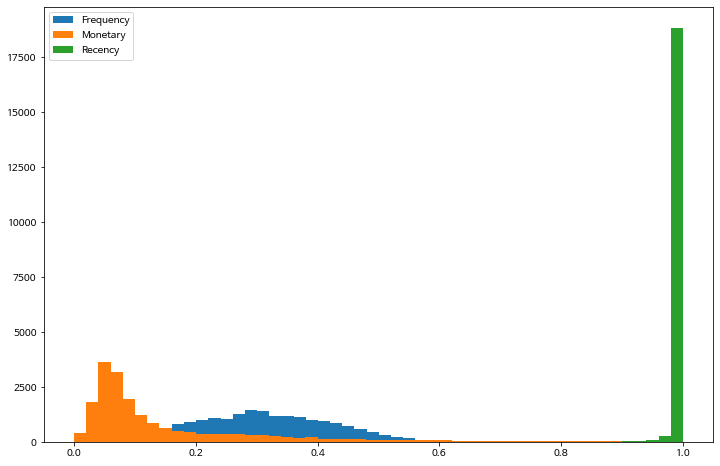

In [ ]:
# RFM histogram  
test_user_rfm = user_rfm.copy()
test_user_rfm.Monetary = test_user_rfm.Monetary.clip(0,200000000) # 2년간 구매금액 2억 기준으로 clipping
test_user_rfm = test_user_rfm/test_user_rfm.max()
plt.hist(test_user_rfm.Frequency, bins = 50,label = 'Frequency');
plt.hist(test_user_rfm.Monetary, bins = 50,label = 'Monetary');
plt.hist(test_user_rfm.Recency, bins = 50,label = 'Recency');
plt.legend();

In [ ]:
# 각 데이터의 중간값
user_rfm.median()

Recency           729.0
Frequency         323.0
Monetary     17176238.0
dtype: float64

- 최근 방문 날짜의 중간값이 2일인것으로 보아 이 데이터는 충성도가 매우 높은 고객들 위주로 편성된 데이터
- 방문횟수의 중간값 역시 308회로 매우 자주 방문하는 충성 고객들임
- 2년간 합계 구매액 중간값은 1700만원 정도임


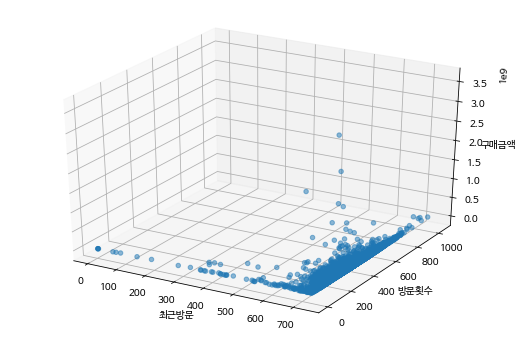

In [ ]:
  # 3차원 RFM 산점도
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure(figsize=(9, 6))
  ax = fig.add_subplot(111, projection='3d')

  # RFM 3차원 scatter 그래프
  ax.scatter(user_rfm.iloc[:,0], user_rfm.iloc[:,1], user_rfm.iloc[:,2], alpha = 0.5);
  ax.set_xlabel('최근방문');
  ax.set_ylabel('방문횟수');
  ax.set_zlabel('구매금액');

Recency  Frequency  Monetary
Recency    1.000000   0.194266  0.009834
Frequency  0.194266   1.000000 -0.176745
Monetary   0.009834  -0.176745  1.000000

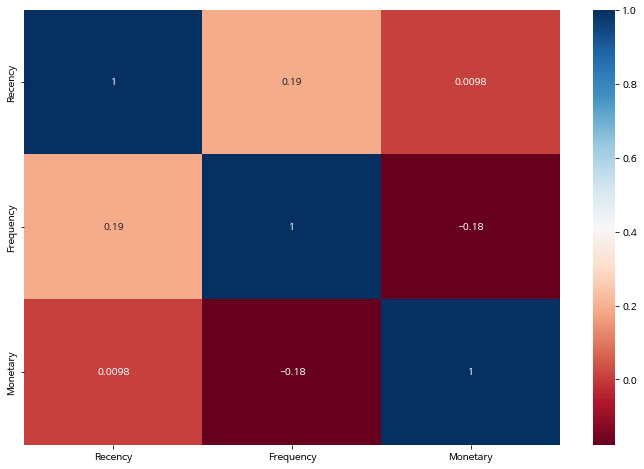

In [ ]:
# RFM  correlation and heatmap
cor = user_rfm.corr()
sns.heatmap(cor, annot = True, cmap = 'RdBu');
cor

### 주 이용 제휴사 기준으로 고객 분류 (이용금액 기준)

In [ ]:
main_cat_df = df_purchase_tr.groupby(['고객번호','제휴사']).구매금액.sum().unstack().fillna(0)
main_cat_df['구매금액이큰제휴사'] = main_cat_df.apply(lambda x: np.argmax(x),axis = 1)
map_ = {0:'A',1:'B',2:'C',3:'D'}
main_cat_df['구매금액이큰제휴사'] = main_cat_df['구매금액이큰제휴사'].map(map_)

In [ ]:
main_cat_df.columns = ['A_Monetary_실제지출','B_Monetary_실제지출','C_Monetary_실제지출','D_Monetary_실제지출','구매금액이큰제휴사']

In [ ]:
main_cat_df.구매금액이큰제휴사.value_counts()
# 구매금액 제휴사 기준 고객 분류

A    8933
B    6604
C    3663
D     183
Name: 구매금액이큰제휴사, dtype: int64

- 자주가는 제휴사 위주로 분포를 살펴보면 확실히 백화점을 가시는 고객은 매출 변동이 심하지만 증가하고 있음
- B, C ,D를 주로 가는 고객들인데 매출액도 낮고 매출액이 정체/감소 하고 있음
- 이들이 이탈고객이라고 볼 수 있음


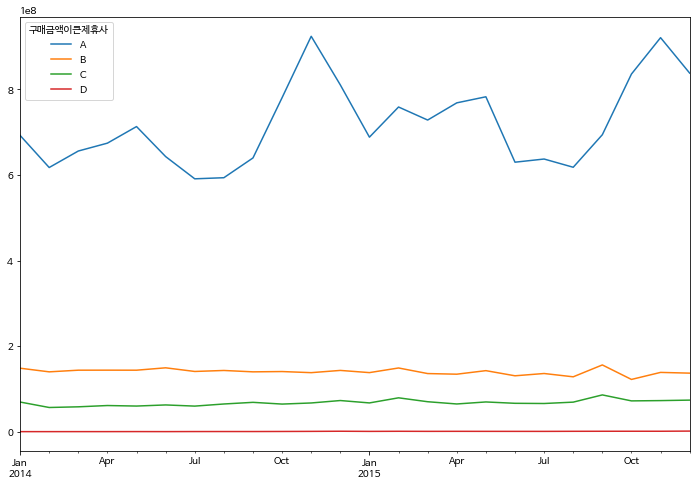

In [ ]:
cust_by_main_cat_df = df_purchase_tr.groupby(['구매일자','고객번호']).구매금액.sum().unstack().fillna(0)
cust_by_main_cat_df = pd.merge(cust_by_main_cat_df.T, main_cat_df[['구매금액이큰제휴사']],  left_index=True, right_index=True, how='left')
cust_by_main_cat_df = cust_by_main_cat_df.groupby('구매금액이큰제휴사').sum().T
cust_by_main_cat_df.index = pd.to_datetime(cust_by_main_cat_df.index,format='%Y%m%d') # 
cust_by_main_cat_df.resample('MS').mean().plot();

- 고객을 주로 이용하는 고객사에 따라 분류해보면 결국 제휴사 시계열 그래프와 비슷하게 나옴
- 약간의 smoothing은 존재
- 이것으로 알 수 있는 점은 결국 편의품, 비내구제 등 일상용품을 사는 마트 이용 고객들이 전반적으로 이탈중임을 알 수 있음

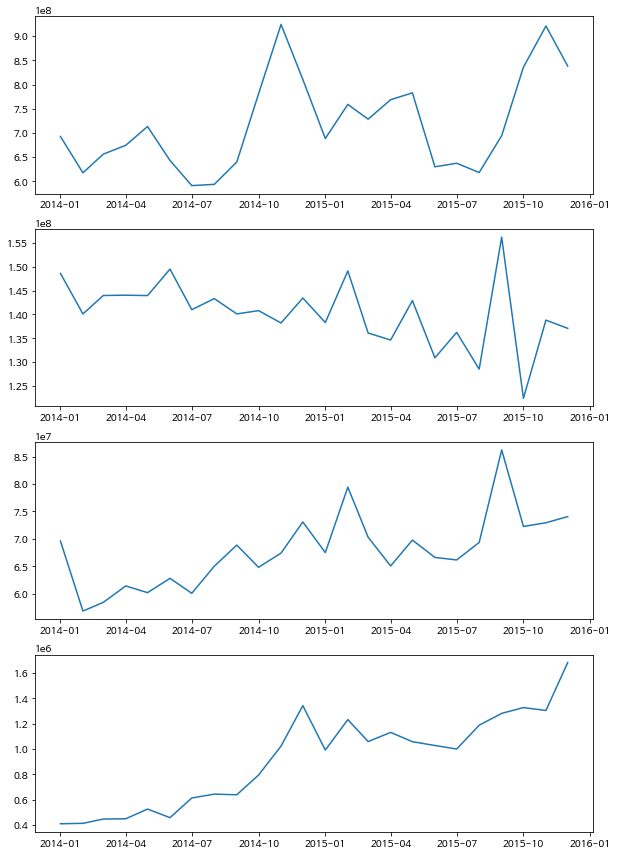

In [ ]:
plt.figure(figsize = (10,15))
plt.subplot(4,1,1)
plt.plot(cust_by_main_cat_df.resample('MS').mean().iloc[:,0]); # A를 주로 이용하는 고객들의 매출액 시계열
plt.subplot(4,1,2)
plt.plot(cust_by_main_cat_df.resample('MS').mean().iloc[:,1]); # B를 주로 이용하는 고객들의 매출액 시계열
plt.subplot(4,1,3)
plt.plot(cust_by_main_cat_df.resample('MS').mean().iloc[:,2]); # C를 주로 이용하는 고객들의 매출액 시계열
plt.subplot(4,1,4)
plt.plot(cust_by_main_cat_df.resample('MS').mean().iloc[:,3]); # D를 주로 이용하는 고객들의 매출액 시계열

### 주 이용 제휴사 기준으로 고객 분류 (방문빈도 기준)

In [ ]:
freq_jehyu_df = pd.DataFrame(user_freq_recency.groupby(['제휴사','고객번호']).구매일자.count().unstack().fillna(0).idxmax(axis = 0), columns = ['방문빈도가높은제휴사'])

### 개별 고객 분석

- 매출액 상위 고객은 어떤 물건을 구매했는가

In [ ]:
cat_name = df_merchant_cl[['소분류코드','소분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('소분류코드',inplace = True)

vip_index = user_rfm.sort_values('Monetary', ascending = False)[:20].index
vip_index

for i in vip_index:
  print(i, '고객님')
  temp_df = pd.DataFrame(df_purchase_tr[df_purchase_tr.고객번호== i].groupby('소분류코드').구매금액.sum())
  temp_df = pd.merge(temp_df, cat_name, on= '소분류코드',how = 'left')
  temp_df.sort_values('구매금액', ascending = False, inplace = True)
  temp_df.set_index('소분류명',inplace = True)
  print(temp_df.to_dict())

15999 고객님
{'구매금액': {'영 캐릭터': 1691125540, '캐릭터캐주얼': 648403830, '영캐주얼': 353554660, '영밸류 캐주얼': 114071100, '영 트렌디': 101997730, '스포츠화': 88048760, '수입캐릭터': 61553800, '네셔널': 41274440, '아이웨어': 40000000, '스포츠의류': 37564200, '4대 B/D': 37014960, '컬처캐주얼': 36809150, '헤지스상품군': 33189100, '트랜디': 28046200, '어반캐주얼': 27116600, '스트리트': 25856060, 'L/C 아웃도어': 25168100, '빈폴상품군': 21000400, '영 컨템포러리': 20001600, '컨템포러리': 19000000, '진캐주얼': 16200000, 'L/C 아동복': 12845700, '토들러': 12600000, '기초 화장품': 10472100, '밸류커리어': 6515960, '유아복': 6464400, '커리어': 5427000, '수입브릿지': 5166780, '명품잡화': 5080000, '14K': 5000000, 'GR-8': 4500000, '네파': 4500000, '이지캐주얼': 4042910, '타미힐피거상품군': 3751000, 'N/B 아동복': 3600000, '수입주방': 2217520, '쿨캐주얼': 1800000, '한실침구': 1778400, '비지니스군': 1216000, '선글라스(특정)': 879450, 'global SPA': 857000, '가방': 539000, '수입도자기': 532640, '국산도자기': 364500, 'Taste5.1': 342000, '수입 아동복': 340000, '캐릭터 여화': 327080, '건강식품(홍삼)': 282000, '수입ACC': 267000, '수영복': 264350, '식당가 한식': 175000, '란제리': 163000, '내의': 131400, '아디다스의류': 

- 일부 고가품을 사는 고객도 있으나 대부분 B2B고객으로 보임

-  구매금액 중간 층 고객은 무엇을 사는가? 

In [ ]:
cat_name = df_merchant_cl[['중분류코드','중분류명']].drop_duplicates() # 중분류 숫자로 된거 품목으로 변경
cat_name.set_index('중분류코드',inplace = True)

median_index = user_rfm.sort_values('Monetary', ascending = False)[9680:9700].index # 하드코딩 중간번호 넣음
  
for i in median_index:
  print(i, '고객님')
  temp_df = pd.DataFrame(df_purchase_tr[df_purchase_tr.고객번호== i].groupby('중분류코드').구매금액.sum())
  temp_df = pd.merge(temp_df, cat_name, on= '중분류코드',how = 'left')
  temp_df.sort_values('구매금액', ascending = False, inplace = True)
  temp_df.set_index('중분류명',inplace = True)
  print(temp_df.to_dict())

3949 고객님
{'구매금액': {'여성캐주얼브랜드': 745100, '드럭스토어': 688150, '피혁잡화': 664700, '애견용품': 660580, '시티캐주얼': 646000, '브랜드': 140000, '냉동수산물': 599650, '양말류': 599650, '간편간식': 599650, '골프용품': 599650, '동물병원': 459100, '홍인삼': 324000, '기타음주류': 308850, '통조림': 308850, '미용소품': 3000, '대중선어': 304000, '반찬류': 304000, '스포츠': 304000, '세탁세제': 134530, '소주': 271030, '요구르트': 215250, '딸기': 212800, '계란': 85800, '냉장축산': 202700, '립메이크업': 202700, '레스토랑': 202700, '과채음료': 35330, '장류': 109360, '커튼류': 191490, '커리어': 189000, '건어류': 189000, '즉석도정미': 189000, '라면': 8770, '조미김': 163130, '화장지': 15300, '맥주': 89410, '남아': 160200, '스킨케어': 149000, '냉동간식': 142390, '주방용품': 134530, '쥐치포': 134000, 'NB구두': 128000, '원두커피': 127110, '건강식품': 127110, '모피/피혁': 127000, '인스턴트커피': 124150, '차류': 124150, '병통조림': 123680, '커피': 123680, '가공건식품': 121370, '시즌차': 121370, '여성위생용품': 120500, '즉석참기름': 119400, '식용유': 118150, '비스켓': 118150, '잡화멀티샵': 117000, '과자': 116600, '선어류': 116600, '양곡': 70000, '스타킹': 115300, '복숭아': 112600, '성인내의': 112200, '스낵': 27760, '냉장기타MS

- 일반 고객들(매출액 중간정도)의 구매는 다양한 편임
- 이런식으로 특정 조건을 걸고 그 타겟층 고객들이 무엇을 사는지 걸러서 나중에 추천 system에 쓰면 좋을듯

## 하루 24시간 시간대별 매출액 

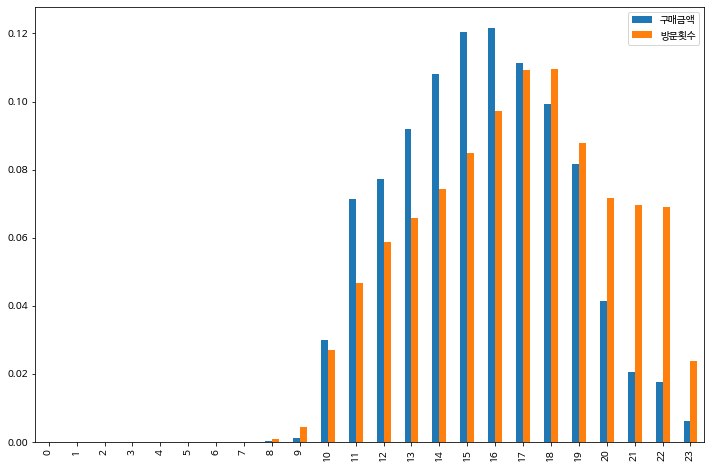

In [ ]:
#시간별 구매금액, 시간별 방문인원
visit_count_df = pd.DataFrame(df_purchase_tr['구매시간'].value_counts())
visit_count_df.rename(columns = {'구매시간':'방문횟수'},inplace = True)

purchase_time_df = pd.DataFrame(df_purchase_tr.groupby(['구매시간']).구매금액.sum())
purchase_time_df = pd.concat((purchase_time_df, visit_count_df), axis = 1)
purchase_time_df = (purchase_time_df/purchase_time_df.sum())
purchase_time_df.plot(kind = 'bar',figsize=(12,8));

- 특이할 만한 사항: 20시 이후 방문 고객은 방문횟수는 많으나 구매금액은 낮음
- 마감세일? 밤늦게 오는 사람들은 저가(생필품) 위주 구매인가?

### 시간대별 매출액 시계열
- 비슷한 경향이 있지만 시간대별 매출액이 약간씩 바뀌긴 함
- 여름에 더 늦은시간에 쇼핑을 많이 하지 않을까?

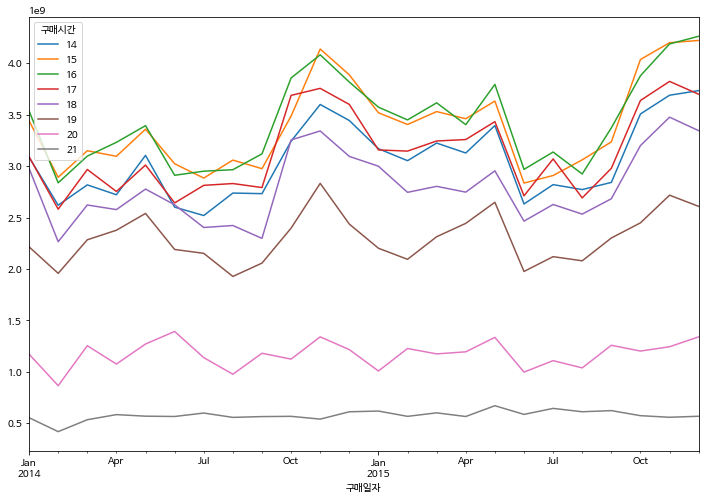

In [ ]:
# 구매시간에 따른 매출 시계열 분포

purchase_time_df = pd.DataFrame(df_purchase_tr.groupby(['구매시간','구매일자']).구매금액.sum()).fillna(0)
purchase_time_df = purchase_time_df.unstack()['구매금액'].fillna(0).T
purchase_time_df = purchase_time_df.resample('MS').sum().fillna(0)
purchase_time_df.iloc[:,14:22].plot(); # 오후 2시부터 저녁 9시까지

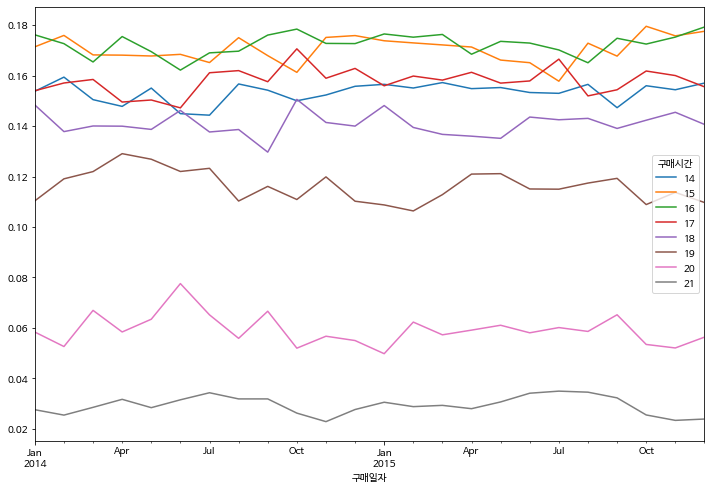

In [ ]:
#평활화 후 비율 표시
purchase_time_df.iloc[:,14:22].div(purchase_time_df.iloc[:,14:22].sum(axis = 1),axis = 0).plot();

## 성별 
- 1인당 평균 매출액, 합계 매출액, 인원 순으로 추출

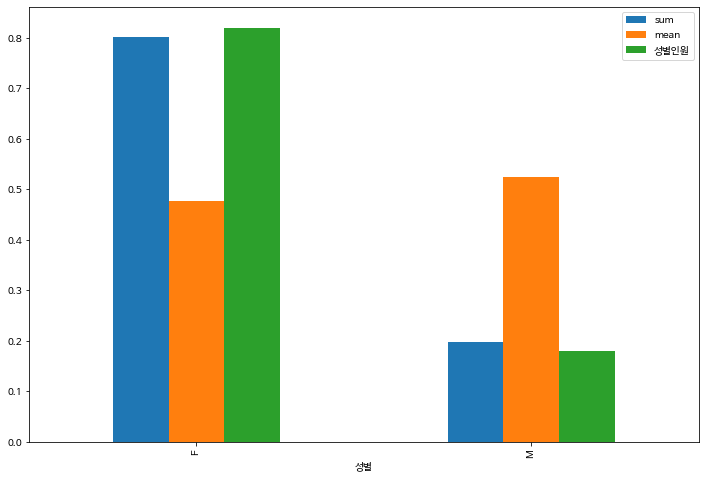

In [ ]:
# 성별 1인당 매출액, 합계매출액, 인원
gender = df_members[['고객번호','성별']].drop_duplicates(subset=['고객번호'])
gender_hist = pd.DataFrame(gender.성별.value_counts())
gender_hist.reset_index(inplace = True)

gender_hist.rename(columns = {'index': '성별', '성별':'성별인원'},inplace = True)

gender = pd.merge(gender,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
gender = gender.groupby('성별').구매금액.agg(['sum','mean'])
gender = pd.merge( gender,gender_hist, on='성별', how='left')
gender.set_index('성별',inplace = True)


# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
gender = (gender/gender.sum())
gender.plot(kind = 'bar',figsize=(12,8));

* 의외로 남자가 1인당 구매금액이 더 많음
* 근데 이게 진짜 남자인가 아니면 카드(멤버십) 명의만 남자인가?

### 성별 시계열
- 큰 변동없이 비슷한것 같음

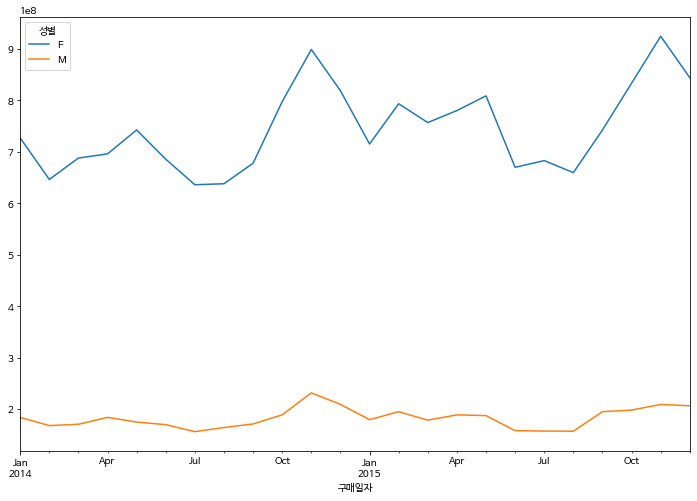

In [ ]:
# 성별에 따른 매출 시계열 분포

gender = df_members[['고객번호','성별']].drop_duplicates(subset=['고객번호'])
gender = pd.merge(gender,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
gender.drop(columns ='고객번호',inplace = True)
gender = pd.DataFrame(gender.groupby(['성별','구매일자']).구매금액.sum()).fillna(0)
gender = gender.unstack()['구매금액'].fillna(0).T
gender = gender.resample('MS').mean().fillna(0)
gender.plot();

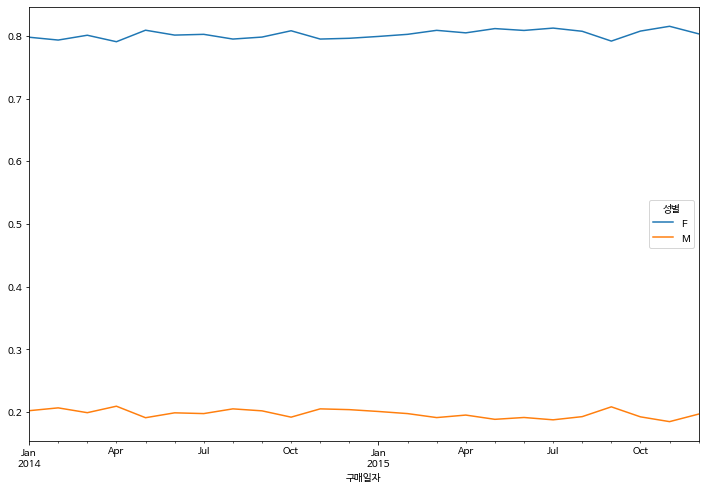

In [ ]:
#평활화 후 비율 표시
gender.div(gender.sum(axis = 1),axis = 0).plot();

## 거주지역별

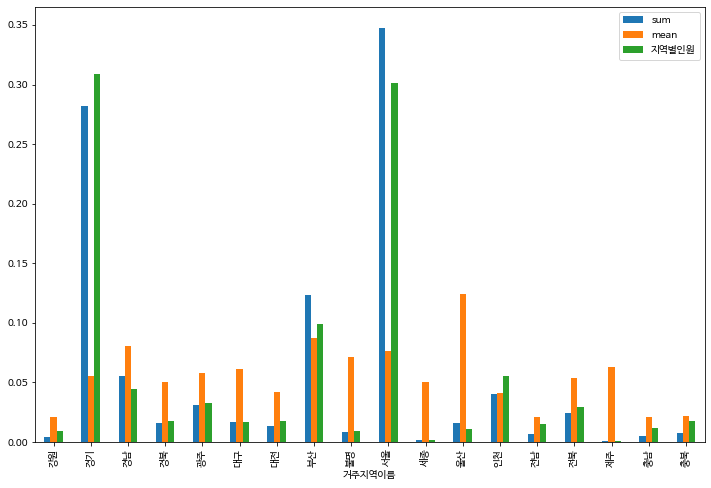

In [ ]:
# 거주지역별 1인당 매출액, 합계매출액, 인원

location = df_members[['고객번호','거주지역이름']].drop_duplicates(subset=['고객번호'])
#location = location.fillna(0)  # 거주지역이 null인 인원이 일부 있음 (178명)지역을 0로 셋팅
location_hist = pd.DataFrame(location.거주지역이름.value_counts())
location_hist.reset_index(inplace = True)
location_hist.rename(columns = {'index': '거주지역이름', '거주지역이름':'지역별인원'},inplace = True)
location = pd.merge( location,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
location = location.groupby('거주지역이름').구매금액.agg(['sum','mean'])
location = pd.merge( location,location_hist, on='거주지역이름', how='left')
location.set_index('거주지역이름',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
location = (location/location.sum())
location.plot(kind = 'bar',figsize=(12,8));

- 고객 숫자/ 매출액 부문에서 서울, 경기, 부산 순으로 높음
- 특이하게 울산은 구매력이 매우 높음을 알 수 있음

### 거주지역별 시계열 
- 경기지역이 상대적으로 매출이 증가하는것 같음
- 일부 지역에서 특정 계절에 매출이 늘어나는 경향이 있음

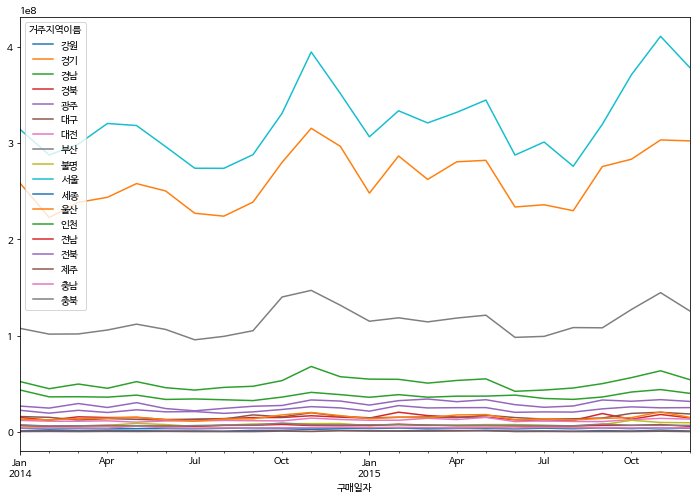

In [ ]:
# 지역에 따른 매출 시계열 분포

location = df_members[['고객번호','거주지역이름']].drop_duplicates(subset=['고객번호'])
location = pd.merge(location,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
location.drop(columns ='고객번호',inplace = True)
location = pd.DataFrame(location.groupby(['거주지역이름','구매일자']).구매금액.sum()).fillna(0)
location = location.unstack()['구매금액'].fillna(0).T
location = location.resample('MS').mean().fillna(0)
location.plot();

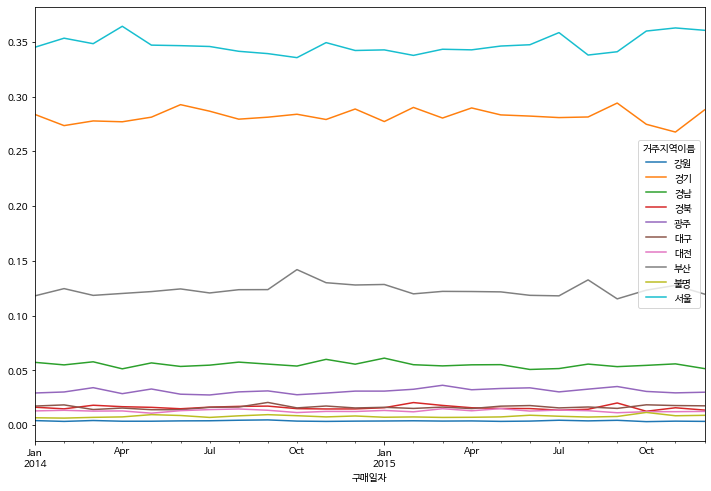

In [ ]:
#평활화 후 비율 표시
location.div(location.sum(axis = 1),axis = 0).iloc[:,:10].plot();

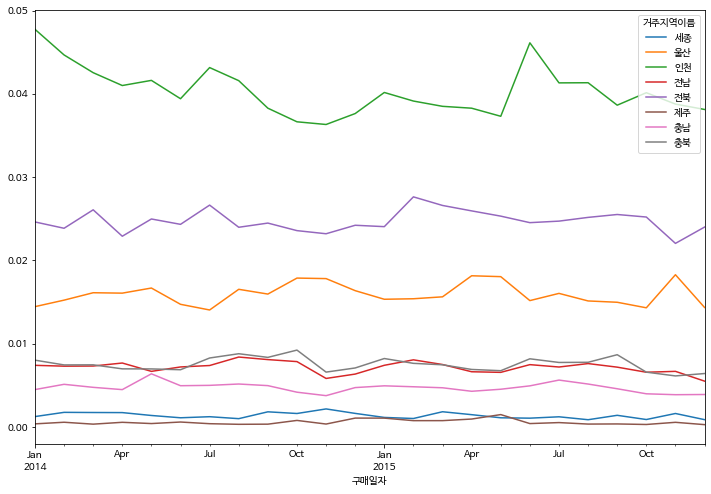

In [ ]:
#평활화 후 비율 표시
location.div(location.sum(axis = 1),axis = 0).iloc[:,10:].plot();

## 연령대별

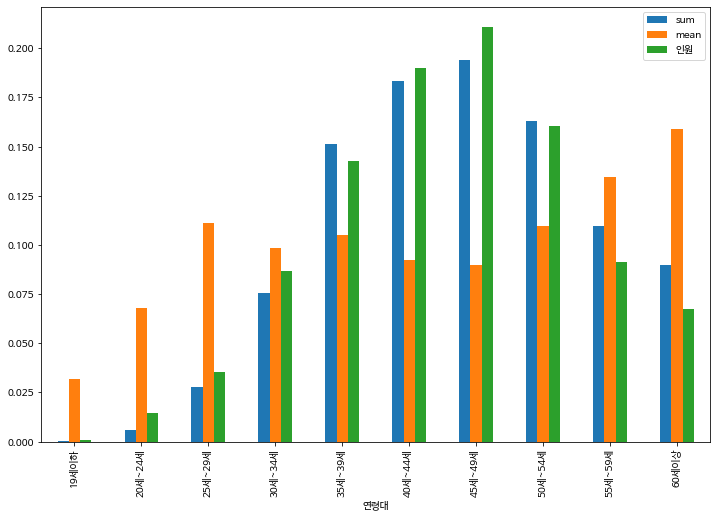

In [ ]:
# 연령별 1인당 매출액, 합계매출액, 인원

age = df_members[['고객번호','연령대']].drop_duplicates(subset=['고객번호'])
age = age.fillna(0)  # null값 존재시 채우기
age_hist = pd.DataFrame(age.연령대.value_counts())
age_hist.reset_index(inplace = True)
age_hist.rename(columns = {'index': '연령대', '연령대':'인원'},inplace = True)
age = pd.merge( age,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
age = age.groupby('연령대').구매금액.agg(['sum','mean'])
age = pd.merge( age,age_hist, on='연령대', how='left')
age.set_index('연령대',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
age = (age/age.sum())
age.plot(kind = 'bar',figsize=(12,8));

객단가는 60대, 50대 20대 순이고
매출액은 40대 50대 30대가 많음
인원은 45~49세를 peak를 찍고 있음

### 연령별 시계열

- 뚜렷한 경향성 보기 어려움

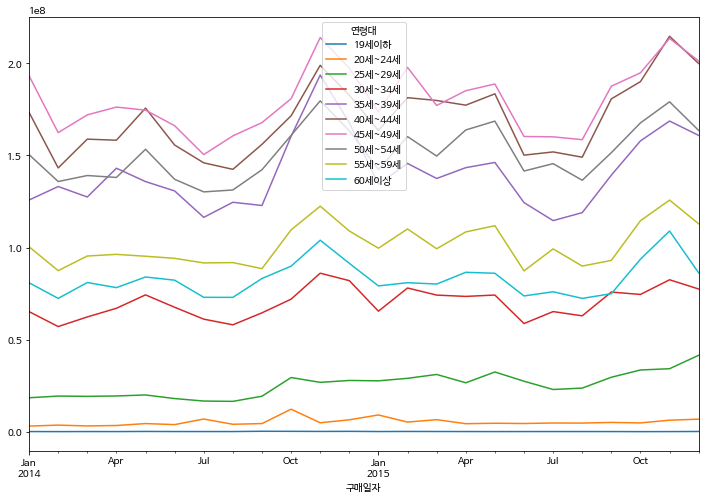

In [ ]:
# 연령에 따른 매출 시계열 분포

age = df_members[['고객번호','연령대']].drop_duplicates(subset=['고객번호'])
age = pd.merge(age,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
age.drop(columns ='고객번호',inplace = True)
age = pd.DataFrame(age.groupby(['연령대','구매일자']).구매금액.sum()).fillna(0)
age = age.unstack()['구매금액'].fillna(0).T
age = age.resample('MS').mean().fillna(0)
age.plot(); 

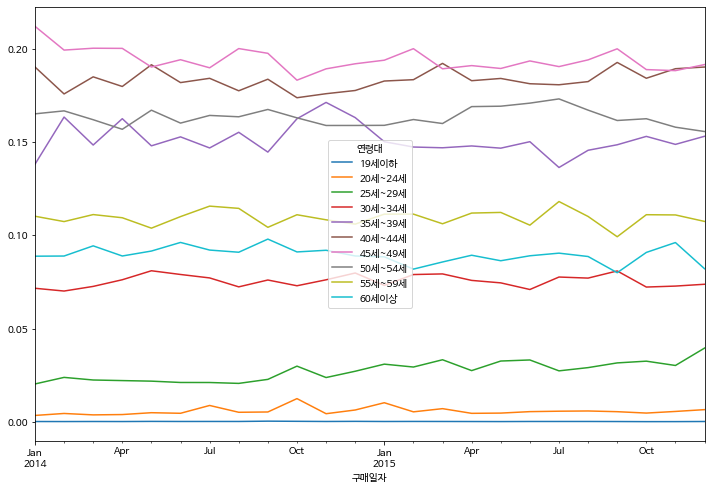

In [ ]:
#평활화 후 비율 표시
age.div(age.sum(axis = 1),axis = 0).plot();

## 멤버십 종류(유무)

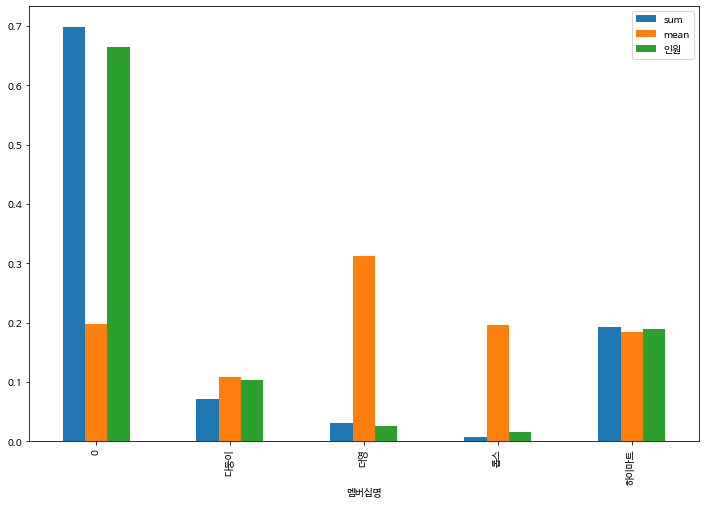

In [ ]:
# 멤버십 종류(유무)에 따른 1인당 매출액, 합계매출액, 인원

membership = df_members[['고객번호','멤버십명']].drop_duplicates(subset=['고객번호'])
membership = membership.fillna(0)  # null값 존재시 채우기
membership_hist = pd.DataFrame(membership.멤버십명.value_counts())
membership_hist.reset_index(inplace = True)
membership_hist.rename(columns = {'index': '멤버십명', '멤버십명':'인원'},inplace = True)
membership = pd.merge( membership,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
membershipdisp = membership.groupby('멤버십명').구매금액.agg(['sum','mean'])
membershipdisp = pd.merge( membershipdisp,membership_hist, on='멤버십명', how='left')
membershipdisp.set_index('멤버십명',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
membershipdisp = (membershipdisp/membershipdisp.sum())
membershipdisp.plot(kind = 'bar',figsize=(12,8));

* 매출액 자체는 멤버십이 없는 사람, 하이마트 순서임
* 멤버십에 의한 lock-in이 크게 강한건지?는 잘 모르겠음.
* 그러나 객단가는 더영, 롭스 멤버십은 확실히 객단가가 높아지는 모습




### 멤버쉽 종류(유무)에 따른 시계열

- 멤버쉽 유무에 따른 뚜렷한 경향성 찾기 어려움

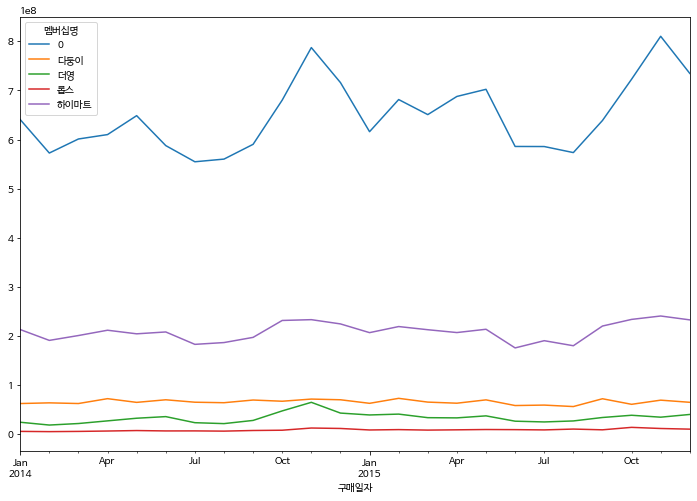

In [ ]:
# 멤버쉽에 따른 매출 시계열 분포

membership = df_members[['고객번호','멤버십명']].drop_duplicates()
membership = membership.fillna(0)  # null값 존재시 채우기
membership = pd.merge(membership,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
membership.drop(columns ='고객번호',inplace = True)
membership = pd.DataFrame(membership.groupby(['멤버십명','구매일자']).구매금액.sum()).fillna(0)
membership = membership.unstack()['구매금액'].fillna(0).T
membership = membership.resample('MS').mean().fillna(0)
membership.plot(); 

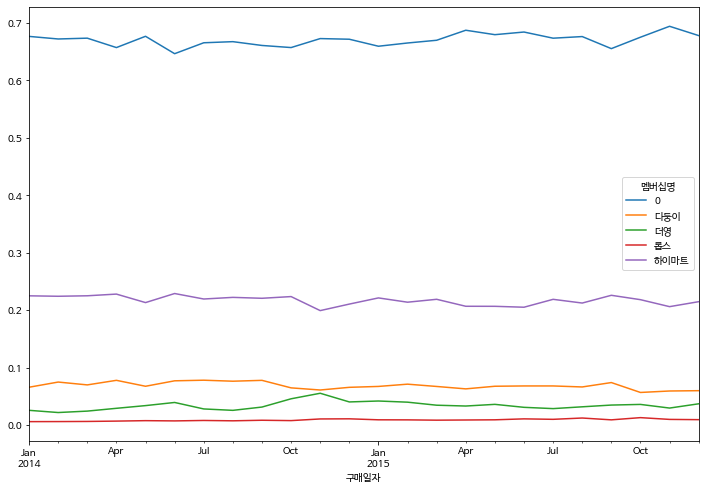

In [ ]:
#평활화 후 비율 표시
membership.div(membership.sum(axis = 1),axis = 0).plot();

## 채널유무(online,mobile)

  사용(모바일/온라인) 채널     인원
0              0  12617
1   B_MOBILE/APP   5170
2   A_MOBILE/APP   1435
3   B_ONLINEMALL   1328
4   C_ONLINEMALL    618
5   D_MOBILE/APP    227
6   C_MOBILE/APP     46


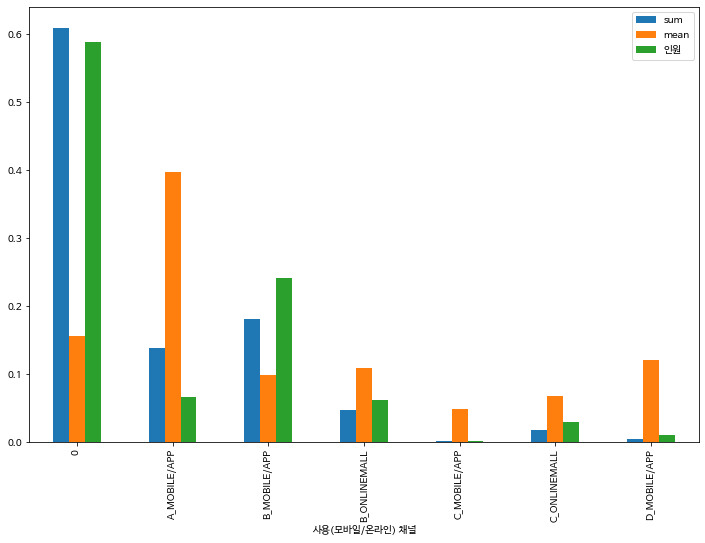

In [ ]:
# 채널 종류(online,mobile)(유무)에 따른 1인당 매출액, 합계매출액, 인원

channel = df_members[['고객번호','사용(모바일/온라인) 채널']].drop_duplicates()
channel = channel.fillna(0)  # null값 존재시 채우기
channel_hist = pd.DataFrame(channel['사용(모바일/온라인) 채널'].value_counts())
channel_hist.reset_index(inplace = True)
channel_hist.rename(columns = {'index': '사용(모바일/온라인) 채널', '사용(모바일/온라인) 채널':'인원'},inplace = True)
channel = pd.merge( channel,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
channel = channel.groupby('사용(모바일/온라인) 채널').구매금액.agg(['sum','mean'])
channel = pd.merge( channel,channel_hist, on='사용(모바일/온라인) 채널', how='left')
channel.set_index('사용(모바일/온라인) 채널',inplace = True)
print(channel_hist)
# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
channel = (channel/channel.sum())
channel.plot(kind = 'bar',figsize=(12,8));

- 아마 B가 롯데마트일것인데 B online mall의 객단가가 매우 높음
- 대량으로 주문하는 업체/자영업자일 확률이 높지 않을까?
- 전반적으로 온라인/모바일 이용 고객들이 객단가가 높음
- 적극적으로 온라인/모바일 채널 홍보,가입 유도가 필요?

### 채널 유무(online,mobile)에 따른 시계열

- 큰 경향성 찾기 어려움

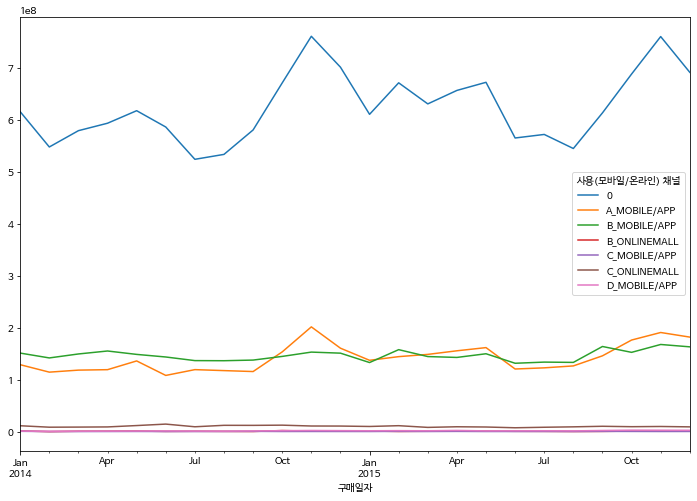

In [ ]:
# 채널 유무(online,mobile)에 따른 시계열 분포

channel = df_members[['고객번호','사용(모바일/온라인) 채널']].drop_duplicates(subset=['고객번호'])
channel = channel.fillna(0)  # null값 존재시 채우기
channel = pd.merge(channel,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
channel.drop(columns ='고객번호',inplace = True)
channel = pd.DataFrame(channel.groupby(['사용(모바일/온라인) 채널','구매일자']).구매금액.sum()).fillna(0)
channel = channel.unstack()['구매금액'].fillna(0).T
channel = channel.resample('MS').mean().fillna(0)
channel.plot(); 

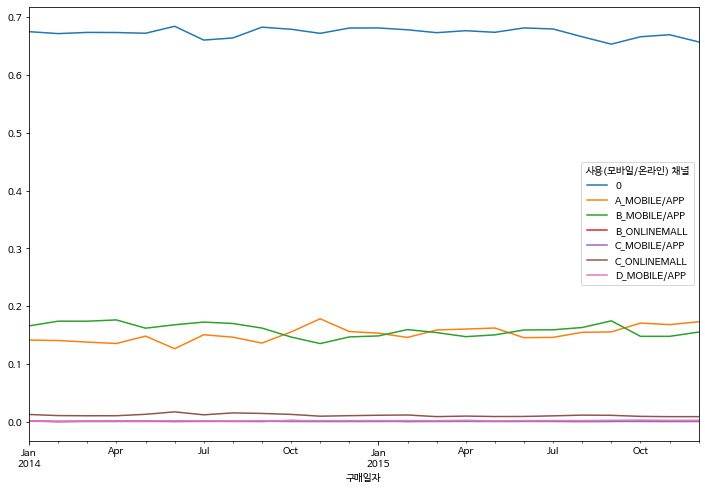

In [ ]:
#평활화 후 비율 표시
channel.div(channel.sum(axis = 1),axis = 0).plot();

## 경쟁사 이용 종류(유무)

- 경쟁사 쓰면 상대적으로 l사 이용이 줄어드는가? 확인필요

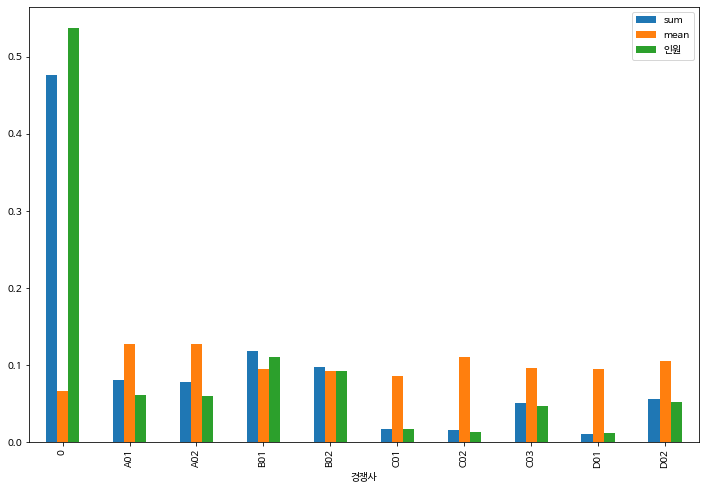

In [ ]:
# 경쟁사 이용 종류(유무)에 따른 1인당 매출액, 합계매출액, 인원

compet = df_members[['고객번호','경쟁사']].drop_duplicates()
compet = compet.fillna(0)  # null값 존재시 채우기
compet_hist = pd.DataFrame(compet['경쟁사'].value_counts())
compet_hist.reset_index(inplace = True)
compet_hist.rename(columns = {'index': '경쟁사', '경쟁사':'인원'},inplace = True)
compet = pd.merge( compet,df_purchase_tr[['고객번호','구매금액']], on='고객번호', how='left')
compet = compet.groupby('경쟁사').구매금액.agg(['sum','mean'])
compet = pd.merge( compet,compet_hist, on='경쟁사', how='left')
compet.set_index('경쟁사',inplace = True)

# 그래프를 위한 scale, 원본데이터는 위에서 저장해야됨
compet = (compet/compet.sum())
compet.plot(kind = 'bar',figsize=(12,8));

### 경쟁사 이용 종류(유무)에 따른 시계열

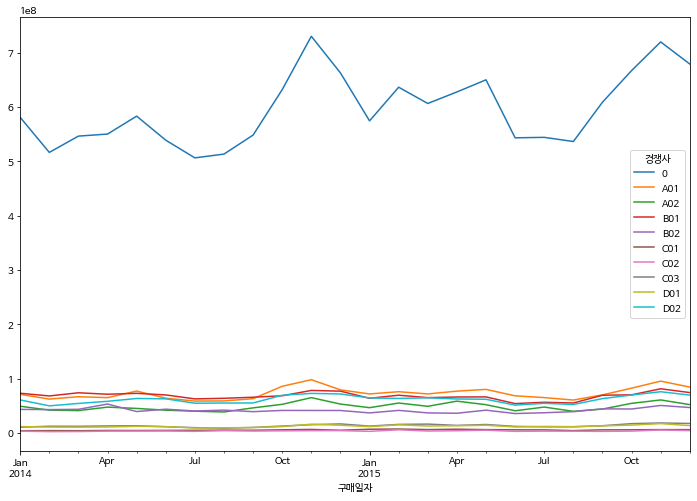

In [ ]:
# 경쟁사 이용 종류(유무)에 따른 시계열 분포

compet = df_members[['고객번호','경쟁사']].drop_duplicates(subset=['고객번호'])
compet = compet.fillna(0)  # null값 존재시 채우기
compet = pd.merge(compet,df_purchase_tr[['고객번호','구매일자','구매금액']], on='고객번호', how='left')
compet.drop(columns ='고객번호',inplace = True)
compet = pd.DataFrame(compet.groupby(['경쟁사','구매일자']).구매금액.sum()).fillna(0)
compet = compet.unstack()['구매금액'].fillna(0).T
compet = compet.resample('MS').mean().fillna(0)
compet.plot(); 

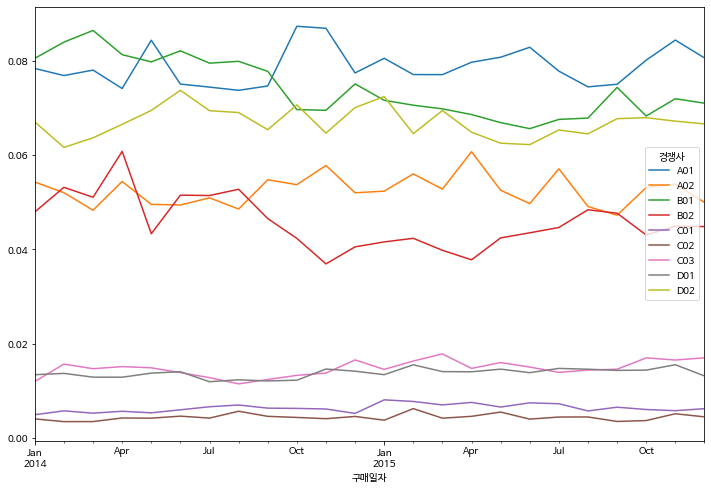

In [ ]:
#평활화 후 비율 표시
compet.div(compet.sum(axis = 1),axis = 0).iloc[:,1:].plot();  #경쟁사 이용 없는 경우 그래프에 제외

- 뚜렷한 경향은 보이는거 같지 않은데.. 약간 주는거 같기도 하고

# Feature engineering(고객에 따라) - Train

## feature:6분기 만큼의 데이터, 예측 데이터: 그다음 1분기

- 1~6분기로 7분기 예측하는 모델 training,
- 같은 모델로 2~7분기 데이터를 사용해서 8분기 예측
- 주어진 데이터는 1~8분기임, 따라서 데이터를 mask 처리하여 일부만 사용

In [ ]:
# 1~6분기 데이터 뽑기
df_purchase_tr_masked = df_purchase_tr[df_purchase_tr.구매일자  < datetime(2015,7,1)]  
# 2~7분기 데이터 뽑기
# df_purchase_tr_masked =  df_purchase_tr[(datetime(2014,3,31) < df_purchase_tr.구매일자) & (df_purchase_tr.구매일자 < datetime(2015,10,1))]   

user_df_masked = pd.DataFrame(df_purchase_tr_masked.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_masked = user_df_masked.unstack()['구매금액'].fillna(0).T

In [ ]:
sum_purchased_masked = pd.DataFrame(df_purchase_tr_masked.groupby('구매일자').구매금액.sum().fillna(0))

# 연도, 분기, 월별 구매금액
sum_Y_df_masked = sum_purchased_masked.resample('YS').mean().fillna(0)
sum_3Q_df_masked = sum_purchased_masked.resample('3QS').mean().fillna(0)
# sum_Y_df.plot(kind = 'bar');
sum_6m_df_masked = sum_purchased_masked.resample('2QS').mean().fillna(0)
# sum_6m_df.plot(kind = 'bar');
sum_Q_df_masked = sum_purchased_masked.resample('QS').mean().fillna(0)
# sum_Q_df.plot(kind = 'bar');
sum_m_df_masked = sum_purchased_masked.resample('MS').mean().fillna(0)
# sum_m_df.plot(kind = 'bar');

## RFM, 성별, 연령대, 거주지역 (기본 feature)

In [ ]:
# 구매금액이 큰 고객 분류
user_rev_sum_masked = user_df_masked.sum()
user_rev_sum_masked.sort_values(ascending = False, inplace = True)
user_rev_sum_masked = pd.DataFrame(user_rev_sum_masked)
# 구매횟수, 최근 구매일자 구하기
user_freq_recency_masked = df_purchase_tr_masked[['제휴사','고객번호','구매일자']].drop_duplicates()
# 영수증번호를 기준으로 frequency를 찾아도 되지만 한 제휴사에서 여러군데 쇼핑한 경우가 있어서 다른 방식으로 함
# df_purchase_tr[['고객번호','영수증번호']].drop_duplicates().groupby('고객번호').영수증번호.count() 
user_freq_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.count())
user_recency_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.max())

user_freq_masked.rename(columns = {'구매일자':'Frequency'}, inplace = True)
user_recency_masked.rename(columns = {'구매일자':'Recency'}, inplace = True)
user_rev_sum_masked.rename(columns = {0:'Monetary'}, inplace = True)

user_rfm_masked = pd.merge(user_recency_masked, user_freq_masked,left_index=True, right_index=True,how='left')
user_rfm_masked = pd.merge(user_rfm_masked, user_rev_sum_masked,left_index=True, right_index=True,how='left')
  
d1 = datetime(2013, 12, 31)
user_rfm_masked['Recency']  = user_rfm_masked['Recency'].apply(lambda x : (x-d1).days) 

In [ ]:
user_clr_df = pd.merge(user_rfm_masked.reset_index(), df_members[['고객번호','성별','연령대','거주지역']].drop_duplicates(), on='고객번호',how = 'left')
user_clr_df.성별 = user_clr_df.성별.apply(lambda x : 1 if x == 'M' else 0) # 성별 M/F -> 1/0 
user_clr_df.연령대 = user_clr_df.연령대.apply(lambda x : int(x[:2])) # 연령대 -> 숫자로
user_clr_df.describe()

고객번호       Recency     Frequency      Monetary            성별  \
count  19372.000000  19372.000000  19372.000000  1.937200e+04  19372.000000   
mean    9687.984978    543.131633    244.454935  2.575320e+07      0.179796   
std     5593.595616     17.219410     90.384098  4.792232e+07      0.384027   
min        1.000000      3.000000      1.000000  1.000000e+03      0.000000   
25%     4843.750000    544.000000    179.000000  8.042270e+06      0.000000   
50%     9688.500000    545.000000    241.000000  1.275611e+07      0.000000   
75%    14531.250000    546.000000    307.000000  2.891620e+07      0.000000   
max    19383.000000    546.000000    788.000000  2.323903e+09      1.000000   

                연령대          거주지역  
count  19372.000000  19372.000000  
mean      42.956484    203.864031  
std        9.299507    187.475099  
min       19.000000      0.000000  
25%       35.000000     60.000000  
50%       45.000000    100.000000  
75%       50.000000    360.000000  
max       60.000000    630.000000

In [ ]:
del user_rfm_masked; del user_freq_masked;  del user_rev_sum_masked;

## 6개 분기 중 전반 3분기 vs 후반 3분기


In [ ]:
user_3Q_df = user_df_masked.resample('3QS').mean().fillna(0)
user_3Q_df
Q3_ratio = sum_3Q_df_masked['구매금액']/sum_3Q_df_masked['구매금액'].max()
user_3Q_df = (user_3Q_df).div(Q3_ratio, axis = 0) # weight scale
user_3Q_df  = user_3Q_df.T

user_3Q_df["3개분기매출증가감소"] = np.where(user_3Q_df.iloc[:,1] >= user_3Q_df.iloc[:,0], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_3Q_df[['3개분기매출증가감소']].reset_index(), on='고객번호',how = 'left')

user_clr_df['3개분기매출증가감소'].value_counts()

0    10480
1     8892
Name: 3개분기매출증가감소, dtype: int64


## 6개분기 3등분 (2Q씩), 두번째 vs 세번째 

In [ ]:
user_6m_df = user_df_masked.resample('2QS').mean().fillna(0)
half_year_ratio = sum_6m_df_masked['구매금액']/sum_6m_df_masked['구매금액'].max()
user_6m_df = (user_6m_df).div(half_year_ratio, axis = 0) # weight scale
user_6m_df  = user_6m_df.T

user_6m_df["반기매출증가"] = np.where(user_6m_df.iloc[:,2] >= user_6m_df.iloc[:,1], 1 ,0)

user_clr_df = pd.merge(user_clr_df,user_6m_df[['반기매출증가']].reset_index(), on='고객번호',how = 'left')

print(user_clr_df['반기매출증가'].value_counts())

1    10148
0     9224
Name: 반기매출증가, dtype: int64


## 6개분기중 5분기와 6분기 비교 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_Q_df = user_df_masked.resample('QS').mean().fillna(0)
Q_ratio = sum_Q_df_masked['구매금액']/sum_Q_df_masked['구매금액'].max()
user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T

user_Q_df["전분기매출증가"] = np.where(user_Q_df.iloc[:,5] >= user_Q_df.iloc[:,4], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_Q_df[['전분기매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['전분기매출증가'].value_counts()

1    9902
0    9470
Name: 전분기매출증가, dtype: int64

## 17개월째 매출 vs 18개월째 매출 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_m_df = user_df_masked.resample('MS').mean().fillna(0)
m_ratio = sum_m_df_masked['구매금액']/sum_m_df_masked['구매금액'].max()
user_m_df = (user_m_df).div(m_ratio, axis = 0) # weight scale
user_m_df  = user_m_df.T

user_m_df
user_m_df["직전달매출증가"] = np.where(user_m_df.iloc[:,17] >= user_m_df.iloc[:,16], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_m_df[['직전달매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['직전달매출증가'].value_counts()

1    10923
0     8449
Name: 직전달매출증가, dtype: int64

In [ ]:
del user_m_df; del user_Q_df; del user_6m_df; del user_3Q_df;

##  일반 제품 매출 시계열 변화 추가(2Q씩)

In [ ]:
# st = '비내구'

# exp_cheap_df = df_purchase_tr[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
# exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','내구/준내구/비내구']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
# exp_cheap_df = exp_cheap_df[exp_cheap_df['내구/준내구/비내구'] == st]
# exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T
# exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
# exp_cheapQ_df.T.to_csv(st+'.csv')

In [ ]:
exp_cheap_df = df_purchase_tr_masked[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','고급/일반']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
exp_cheap_df = exp_cheap_df[exp_cheap_df['고급/일반'] == '일반']
exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T

exp_cheap6m_df = exp_cheap_df.resample('2QS').mean().fillna(0)
exp_cheap6m_df  = exp_cheap6m_df.T

exp_cheap6m_df["일반제품반기매출증가"] = np.where(exp_cheap6m_df.iloc[:,2] >= exp_cheap6m_df.iloc[:,1], 1 ,0)

user_clr_df = pd.merge(user_clr_df,exp_cheap6m_df[['일반제품반기매출증가']].reset_index(), on='고객번호',how = 'left')
print(user_clr_df['일반제품반기매출증가'].value_counts())

1.0    10958
0.0     8405
Name: 일반제품반기매출증가, dtype: int64


##  일반 제품 매출 시계열 변화 추가(Q비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df["일반제품전분기매출증가"] = np.where(exp_cheapQ_df.iloc[:,5] >= exp_cheapQ_df.iloc[:,4], 1 ,0)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품전분기매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['일반제품전분기매출증가'].value_counts()

0.0    10122
1.0     9241
Name: 일반제품전분기매출증가, dtype: int64

## 일반 제품 매출 시계열 변화 추가(직전달 비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('MS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df
exp_cheapQ_df["일반제품직전달매출증가"] = np.where(exp_cheapQ_df.iloc[:,17] >= exp_cheapQ_df.iloc[:,16], 1 ,0)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품직전달매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['일반제품직전달매출증가'].value_counts()

0.0    9834
1.0    9529
Name: 일반제품직전달매출증가, dtype: int64

## CAGR 지수

In [ ]:
# 고객별 일별 구매금액
user_df_cagr = pd.DataFrame(df_purchase_tr_masked.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_cagr = user_df_cagr.unstack()['구매금액'].fillna(0).T

idx = pd.to_datetime(user_df_cagr.index)
user_df_cagr['col'] = idx

cagr_df = user_df_cagr.set_index('col').resample('QS').sum().T
cagr_df

# train 적용
cagr_df['cagr'] = ((cagr_df.iloc[:,5]/cagr_df.iloc[:,0])**(1/5))-1
cagr_df

# 무한대 제거
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,1])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,2])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,3])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,4])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,5])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'].value_counts()
cagr_df
cagr_df = cagr_df.drop(cagr_df.columns[[0,1,2,3,4,5]], axis=1)
# cagr_df = cagr_df.drop(cagr_df.columns[0], axis=1)

user_clr_df = pd.merge(user_clr_df,cagr_df.reset_index(), on='고객번호',how = 'left')

## 고급/일반 구매 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','고급/일반']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','고급/일반']).구매금액.mean()).unstack()['구매금액']
temp.fillna(0, inplace = True)
temp['고급일반비율'] = temp.고급/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','고급일반비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  직전달매출증가  일반제품반기매출증가  일반제품전분기매출증가  일반제품직전달매출증가  \
0           0        0        1         1.0          0.0          1.0   
1           1        0        0         0.0          0.0          0.0   
2           0        1        1         0.0          1.0          1.0   
3           0        1        1         1.0          1.0          0.0   
4           1        0        0         0.0          0.0          0.0   
...       ...      ...      ...         ...          ...          ...   
19367       1        1        1         0.0          0.0          0.0   
19368       1        0        1         1.0          0.0          0.0   
19369       1        1        1         1.0          1.0          1.0   
19370       1        1        0         1.0          1.0          0.0   
19371       1        1        1         1.0          1.0          1.0   

           cagr    고급일반비율  
0     -0.012246  0.499614  
1     -0.079968  0.490591  
2      0.006641  0.472536  
3      0.079478  0.491090  
4     -0.237539  0.538824  
...         ...       ...  
19367  0.575514  0.494090  
19368 -0.076492  0.613768  
19369  0.082575  0.569052  
19370  0.057564  0.533629  
19371  0.000000  0.536481  

[19372 rows x 16 columns]

## 내구/준내구/비내구 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','내구/준내구/비내구']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','내구/준내구/비내구']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['내구비율'] = temp.내구/temp.sum(axis = 1)
temp['비내구비율'] = temp.비내구/temp.sum(axis = 1)
temp['준내구비율'] = temp.준내구/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','내구비율','비내구비율','준내구비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  직전달매출증가  일반제품반기매출증가  일반제품전분기매출증가  일반제품직전달매출증가  \
0           0        0        1         1.0          0.0          1.0   
1           1        0        0         0.0          0.0          0.0   
2           0        1        1         0.0          1.0          1.0   
3           0        1        1         1.0          1.0          0.0   
4           1        0        0         0.0          0.0          0.0   
...       ...      ...      ...         ...          ...          ...   
19367       1        1        1         0.0          0.0          0.0   
19368       1        0        1         1.0          0.0          0.0   
19369       1        1        1         1.0          1.0          1.0   
19370       1        1        0         1.0          1.0          0.0   
19371       1        1        1         1.0          1.0          1.0   

           cagr    고급일반비율      내구비율     비내구비율     준내구비율  
0     -0.012246  0.499614  0.150339  0.497567  0.352093  
1     -0.079968  0.490591  0.135236  0.548617  0.316146  
2      0.006641  0.472536  0.143747  0.703714  0.152538  
3      0.079478  0.491090  0.040747  0.561259  0.397994  
4     -0.237539  0.538824  0.055103  0.796135  0.148762  
...         ...       ...       ...       ...       ...  
19367  0.575514  0.494090  0.066277  0.522526  0.411197  
19368 -0.076492  0.613768  0.081747  0.562567  0.355686  
19369  0.082575  0.569052  0.100057  0.498783  0.401159  
19370  0.057564  0.533629  0.025241  0.738807  0.235952  
19371  0.000000  0.536481  0.000000  0.931034  0.068963  

[19372 rows x 19 columns]

## 편의/선매/전문 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','편의/선매/전문']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','편의/선매/전문']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['편의비율'] = temp.편의/temp.sum(axis = 1)
temp['선매비율'] = temp.선매/temp.sum(axis = 1)
temp['전문비율'] = temp.전문/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','편의비율','선매비율','전문비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  일반제품전분기매출증가  일반제품직전달매출증가      cagr    고급일반비율  \
0           0        0  ...          0.0          1.0 -0.012246  0.499614   
1           1        0  ...          0.0          0.0 -0.079968  0.490591   
2           0        1  ...          1.0          1.0  0.006641  0.472536   
3           0        1  ...          1.0          0.0  0.079478  0.491090   
4           1        0  ...          0.0          0.0 -0.237539  0.538824   
...       ...      ...  ...          ...          ...       ...       ...   
19367       1        1  ...          0.0          0.0  0.575514  0.494090   
19368       1        0  ...          0.0          0.0 -0.076492  0.613768   
19369       1        1  ...          1.0          1.0  0.082575  0.569052   
19370       1        1  ...          1.0          0.0  0.057564  0.533629   
19371       1        1  ...          1.0          1.0  0.000000  0.536481   

           내구비율     비내구비율     준내구비율      편의비율      선매비율      전문비율  
0      0.150339  0.497567  0.352093  0.484467  0.477437  0.038096  
1      0.135236  0.548617  0.316146  0.473871  0.469483  0.056646  
2      0.143747  0.703714  0.152538  0.722031  0.220204  0.057765  
3      0.040747  0.561259  0.397994  0.500048  0.462150  0.037802  
4      0.055103  0.796135  0.148762  0.463075  0.445371  0.091555  
...         ...       ...       ...       ...       ...       ...  
19367  0.066277  0.522526  0.411197  0.451474  0.514118  0.034407  
19368  0.081747  0.562567  0.355686  0.487520  0.436155  0.076325  
19369  0.100057  0.498783  0.401159  0.760926  0.239074  0.000000  
19370  0.025241  0.738807  0.235952  0.777238  0.217449  0.005313  
19371  0.000000  0.931034  0.068963  0.519231  0.480764  0.000000  

[19372 rows x 22 columns]

## 멤버쉽 종류(유무)

In [ ]:
member_df = df_members[['고객번호','멤버십명']].drop_duplicates()
member_df = member_df.pivot(index = '고객번호', columns ='멤버십명', values = '멤버십명')
member_df = member_df[['다둥이', '더영', '롭스', '하이마트']].fillna(0)
member_df = member_df.replace(['다둥이', '더영', '롭스', '하이마트'], 1).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, member_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...      내구비율     비내구비율     준내구비율      편의비율      선매비율  \
0           0        0  ...  0.150339  0.497567  0.352093  0.484467  0.477437   
1           1        0  ...  0.135236  0.548617  0.316146  0.473871  0.469483   
2           0        1  ...  0.143747  0.703714  0.152538  0.722031  0.220204   
3           0        1  ...  0.040747  0.561259  0.397994  0.500048  0.462150   
4           1        0  ...  0.055103  0.796135  0.148762  0.463075  0.445371   
...       ...      ...  ...       ...       ...       ...       ...       ...   
19367       1        1  ...  0.066277  0.522526  0.411197  0.451474  0.514118   
19368       1        0  ...  0.081747  0.562567  0.355686  0.487520  0.436155   
19369       1        1  ...  0.100057  0.498783  0.401159  0.760926  0.239074   
19370       1        1  ...  0.025241  0.738807  0.235952  0.777238  0.217449   
19371       1        1  ...  0.000000  0.931034  0.068963  0.519231  0.480764   

           전문비율  다둥이  더영  롭스  하이마트  
0      0.038096    0   0   0     0  
1      0.056646    0   0   0     0  
2      0.057765    0   0   0     0  
3      0.037802    0   0   0     0  
4      0.091555    0   0   0     0  
...         ...  ...  ..  ..   ...  
19367  0.034407    0   0   1     0  
19368  0.076325    0   0   1     0  
19369  0.000000    1   0   0     0  
19370  0.005313    0   0   0     0  
19371  0.000000    0   0   1     0  

[19372 rows x 26 columns]

## 채널유무

In [ ]:
channel_df = df_members[['고객번호','사용(모바일/온라인) 채널','채널이용횟수']].drop_duplicates()
channel_df = channel_df.pivot(index = '고객번호', columns ='사용(모바일/온라인) 채널', values = '채널이용횟수').fillna(0)
channel_df = channel_df[['A_MOBILE/APP',	'B_MOBILE/APP',	'B_ONLINEMALL',	'C_MOBILE/APP',	'C_ONLINEMALL',	'D_MOBILE/APP']].fillna(0).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, channel_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  다둥이  더영  롭스  하이마트  A_MOBILE/APP  B_MOBILE/APP  \
0           0        0  ...    0   0   0     0           0.0           0.0   
1           1        0  ...    0   0   0     0           0.0           0.0   
2           0        1  ...    0   0   0     0           0.0           0.0   
3           0        1  ...    0   0   0     0           0.0           0.0   
4           1        0  ...    0   0   0     0           0.0           0.0   
...       ...      ...  ...  ...  ..  ..   ...           ...           ...   
19367       1        1  ...    0   0   1     0           0.0           0.0   
19368       1        0  ...    0   0   1     0           0.0           0.0   
19369       1        1  ...    1   0   0     0           0.0           5.0   
19370       1        1  ...    0   0   0     0           0.0           9.0   
19371       1        1  ...    0   0   1     0           0.0           0.0   

       B_ONLINEMALL  C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  
0               0.0           0.0           0.0           0.0  
1               0.0           0.0           0.0           0.0  
2               0.0           0.0           0.0           0.0  
3               0.0           0.0           0.0           0.0  
4               0.0           0.0           0.0           0.0  
...             ...           ...           ...           ...  
19367           0.0           0.0           0.0           0.0  
19368           0.0           0.0           0.0           1.0  
19369           0.0           0.0           0.0           0.0  
19370           0.0           0.0           0.0           0.0  
19371           0.0           0.0           0.0           0.0  

[19372 rows x 32 columns]

## 경쟁사 이용 유무 및 이용횟수

In [ ]:
compet_df = df_members[['고객번호','경쟁사','경쟁사이용년월']].drop_duplicates()
compet_df = pd.pivot_table(compet_df, index = '고객번호', columns ='경쟁사', values = '경쟁사이용년월', aggfunc = 'count').fillna(0)
compet_df = compet_df[[ 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02']].reset_index()
compet_df['A경쟁사이용횟수'] =compet_df.A01+compet_df.A02
compet_df['B경쟁사이용횟수'] =compet_df.B01+compet_df.B02
compet_df['C경쟁사이용횟수'] =compet_df.C01+compet_df.C02+compet_df.C03
compet_df['D경쟁사이용횟수'] =compet_df.D01+compet_df.D02
compet_df = compet_df[['고객번호','A경쟁사이용횟수',	'B경쟁사이용횟수',	'C경쟁사이용횟수',	'D경쟁사이용횟수']]
compet_df

경쟁사    고객번호  A경쟁사이용횟수  B경쟁사이용횟수  C경쟁사이용횟수  D경쟁사이용횟수
0         1       2.0       8.0       5.0       0.0
1         2       2.0       3.0       2.0       1.0
2         4       2.0       0.0       1.0       0.0
3         7       1.0       0.0       0.0       0.0
4         8       1.0       2.0       0.0       0.0
...     ...       ...       ...       ...       ...
5876  19370       0.0      11.0       0.0      13.0
5877  19372       0.0       2.0       2.0       0.0
5878  19375       1.0       2.0       1.0       2.0
5879  19376       0.0       1.0       0.0       0.0
5880  19377       0.0       1.0       0.0       0.0

[5881 rows x 5 columns]

In [ ]:
user_clr_df= pd.merge(user_clr_df, compet_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      543        192  71940032.0   1   60   60.0           1   
1          2      540        227  74036940.0   1   60  100.0           0   
2          3      545        314   2486049.0   1   60   33.0           0   
3          4      546        189  12956553.0   0   60   16.0           0   
4          5      506        203  10620810.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19367  19379      546        154   3586540.0   0   20   69.0           1   
19368  19380      546         59   1360650.0   0   20   39.0           1   
19369  19381      545         93   2797171.0   0   40  460.0           1   
19370  19382      546         88   1826739.0   0   45  460.0           1   
19371  19383      542          3     27000.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  A_MOBILE/APP  B_MOBILE/APP  B_ONLINEMALL  \
0           0        0  ...           0.0           0.0           0.0   
1           1        0  ...           0.0           0.0           0.0   
2           0        1  ...           0.0           0.0           0.0   
3           0        1  ...           0.0           0.0           0.0   
4           1        0  ...           0.0           0.0           0.0   
...       ...      ...  ...           ...           ...           ...   
19367       1        1  ...           0.0           0.0           0.0   
19368       1        0  ...           0.0           0.0           0.0   
19369       1        1  ...           0.0           5.0           0.0   
19370       1        1  ...           0.0           9.0           0.0   
19371       1        1  ...           0.0           0.0           0.0   

       C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  A경쟁사이용횟수  B경쟁사이용횟수  C경쟁사이용횟수  \
0               0.0           0.0           0.0       2.0       8.0       5.0   
1               0.0           0.0           0.0       2.0       3.0       2.0   
2               0.0           0.0           0.0       NaN       NaN       NaN   
3               0.0           0.0           0.0       2.0       0.0       1.0   
4               0.0           0.0           0.0       NaN       NaN       NaN   
...             ...           ...           ...       ...       ...       ...   
19367           0.0           0.0           0.0       NaN       NaN       NaN   
19368           0.0           0.0           1.0       NaN       NaN       NaN   
19369           0.0           0.0           0.0       NaN       NaN       NaN   
19370           0.0           0.0           0.0       NaN       NaN       NaN   
19371           0.0           0.0           0.0       NaN       NaN       NaN   

       D경쟁사이용횟수  
0           0.0  
1           1.0  
2           NaN  
3           0.0  
4           NaN  
...         ...  
19367       NaN  
19368       NaN  
19369       NaN  
19370       NaN  
19371       NaN  

[19372 rows x 36 columns]

In [ ]:
user_clr_df = user_clr_df.fillna(0)

## 제휴사별 RFM

In [ ]:
user_clr_df = pd.merge(user_clr_df, main_cat_df, left_on = '고객번호', right_index = True, how = 'left')  # 주 이용 제휴사(A,B,C,D 중 어디에 돈을 많이 썼는가?)
user_clr_df = pd.merge(user_clr_df, freq_jehyu_df, left_on = '고객번호', right_index = True, how = 'left') # 주 이용 제휴사(A,B,C,D 중 어디에 가장 자주 방문했는가?)
user_clr_df = pd.merge(user_clr_df, jehyu_frequency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 frequency
user_clr_df = pd.merge(user_clr_df, jehyu_Monetary, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 Monetary 
user_clr_df = pd.merge(user_clr_df, jehyu_recency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 recency

## Feature 추가 및 정리

In [ ]:
import re
import os

path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/'

# 공사님 feature
addtional_feature_df = pd.read_csv(path+'sa_group.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

# 훈님 feature
addtional_feature_df = pd.read_csv(path+'train_data_훈.csv', encoding='cp949')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df, on='고객번호',how = 'left')

# 짱제님 feature
addtional_feature_df = pd.read_csv(path+'train_1_to_6_짱제.csv')
# addtional_feature_df = pd.read_csv(path+'train_2_to_7_짱제.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

#카스님 feature
addtional_feature_df = pd.read_csv(path+'train_fluctuation_total.csv')
addtional_feature_df1 = pd.read_excel(path+'train_fluctuation_중분류별.xlsx')
addtional_feature_df1 = addtional_feature_df1.fillna(1000)
addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')

# addtional_feature_df = pd.read_csv(path+'test_fluctuation_total.csv')
# addtional_feature_df1 = pd.read_excel(path+'test_fluctuation_중분류별.xlsx')
# addtional_feature_df1 = addtional_feature_df1.fillna(1000)
# addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
# user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')


# path_dir = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/etc./'+'/train/'
 
p = re.compile('(?<=fluctuation_).+(?=.csv)')

file_list = os.listdir(path_dir)
for filename in file_list :
  fluc_df  = pd.read_csv(path_dir+filename)
  fluc_df = fluc_df.set_index('고객번호')
  colname = re.findall(p, filename)
  if len(fluc_df.columns) == 2 :
    fluc_df.drop(columns ='Unnamed: 0', inplace = True)
    fluc_df.columns = [colname[0]+'_fluctuation']
  else :
    fluc_df.columns = [colname[0]+'_fluctuation']
  user_clr_df  = pd.merge(user_clr_df,fluc_df, left_index = True, right_index = True, how = 'left')

user_clr_df.fillna(0.001, inplace = True)  

user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]]= user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]].replace(1000,0.0001)

## label값
 2014년 1분기 부터 2015년 2분기까지 대비 2015년 3분기 매출 증가 or 감소
 
 2014년 2분기 부터 2015년 3분기까지 대비 2015년 4분기 매출 증가 or 감소
 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_Q_df = user_df.resample('QS').mean().fillna(0)
Q_ratio = sum_Q_df['구매금액']/sum_Q_df['구매금액'].max()
user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T


# 1~6분기로 7분기 예측 label
comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,6] - user_Q_df.iloc[:,7])/6
comp = comp.clip(0.00001, comp)
user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,6] >= user_Q_df.iloc[:,0], 1 ,0)
user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,6])/comp
# user_Q_df['분기매출증가'] = np.select([user_Q_df.iloc[:,6] > 1.10 * comp, user_Q_df.iloc[:,6] < 0.90 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,6] < 0.95 * comp,1, 0)

# # 2~7분기로 8분기 예측 label
# comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,0] - user_Q_df.iloc[:,7])/6
# comp = comp.clip(0.00001, comp)
# user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,7] >= comp, 1 ,0)
# user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,7])/comp
# user_Q_df['분기매출증가test'] = np.select([user_Q_df.iloc[:,7] > 1.05 * comp, user_Q_df.iloc[:,7] < 0.95 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,7] < 0.95 * comp,1, 0)
  
user_clr_df = pd.merge(user_clr_df,user_Q_df[['분기매출증가',"분기매출비율"]].reset_index(), on='고객번호',how = 'left')

user_clr_df["분기매출증가"].value_counts()

1    10494
0     8878
Name: 분기매출증가, dtype: int64

In [ ]:
# # 구매증가/감소 고객 분포
# cust_hist_df = user_Q_df.iloc[:,6]/ comp
# cust_hist_df = round(cust_hist_df.fillna(2),5)
# cust_hist_df = cust_hist_df.clip(0,2)
# plt.hist(cust_hist_df.values, bins = 50);

In [ ]:
user_clr_origin_df = user_clr_df.copy()
user_clr_df.set_index('고객번호',inplace = True)

# # 비내구재 비율
# user_clr_df.비내구비율 = (user_clr_df.비내구비율)/(user_clr_df.비내구비율+user_clr_df.내구비율+user_clr_df.준내구비율)
# # 편의비율
# user_clr_df.편의비율 = (user_clr_df.편의비율)/(user_clr_df.선매비율+user_clr_df.편의비율+user_clr_df.전문비율)

# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.구매금액이큰제휴사 =user_clr_df.구매금액이큰제휴사.map(map_)
# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.방문빈도가높은제휴사 =user_clr_df.방문빈도가높은제휴사.map(map_)

# 어떤 feature를 쓸것인가 결정

#user_clr_df = user_clr_df.drop(columns = ['Recency','성별', '연령대', '거주지역', '내구비율', '선매비율', '준내구비율','고급일반비율','전문비율','구매금액이큰제휴사'])

## Feature correlation

Index(['분기매출증가', 'fluctuation', 'cagr', '3개분기매출증가감소', 'f_가공식품',
       'f_농산물', 'f_육류', 'f_캐주얼', 'f_화장품', 'f_차커피'],
      dtype='object')

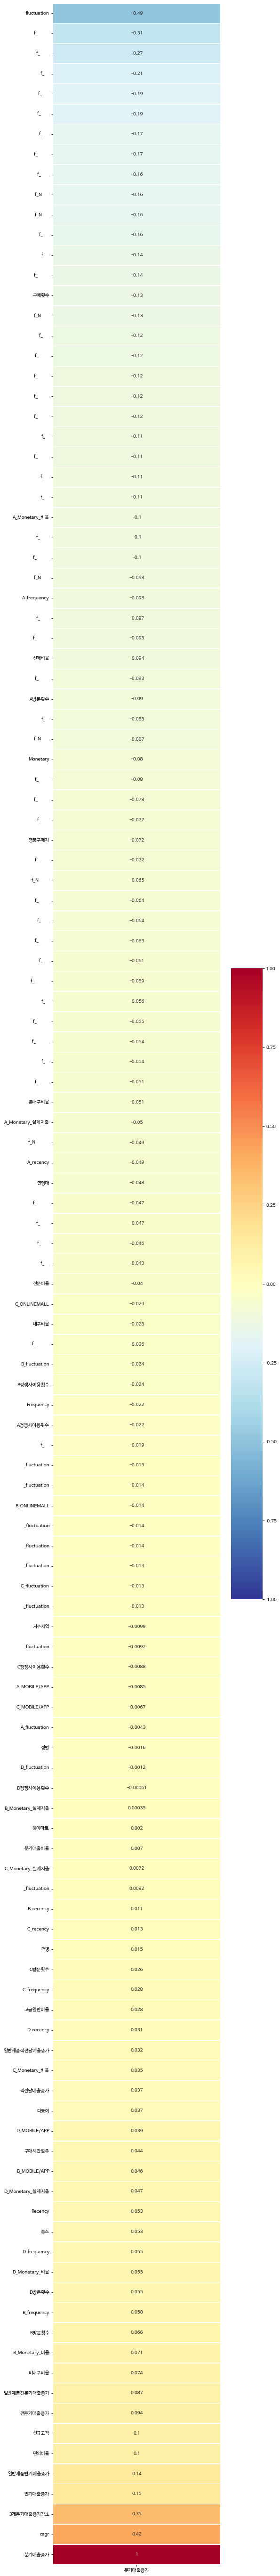

In [ ]:
cor = user_clr_df.corr();
#sns.heatmap(cor, annot = True, cmap = 'RdBu');

# mask = np.zeros_like(cor, dtype=bool);
# mask[np.triu_indices_from(mask)] = True;

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (8,100));

sns.heatmap(cor[['분기매출증가']].sort_values(by = '분기매출증가'),  
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           );

temp = cor[['분기매출증가']]
temp.분기매출증가 = temp.분기매출증가.apply(abs)
temp.sort_values(by = '분기매출증가', ascending = False).index[:10]           

In [ ]:
user_clr_df.drop(columns = '분기매출비율', inplace = True )

In [ ]:
user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

In [ ]:
# user_clr_df.to_csv("/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/train.csv",encoding='utf-8')

# Feature engineering(고객에 따라) - Test

## feature:6분기 만큼의 데이터, 예측 데이터: 그다음 1분기

- 1~6분기로 7분기 예측하는 모델 training,
- 같은 모델로 2~7분기 데이터를 사용해서 8분기 예측
- 주어진 데이터는 1~8분기임, 따라서 데이터를 mask 처리하여 일부만 사용

In [ ]:
# 1~6분기 데이터 뽑기
# df_purchase_tr_masked = df_purchase_tr[df_purchase_tr.구매일자  < datetime(2015,7,1)]  
# 2~7분기 데이터 뽑기
df_purchase_tr_masked =  df_purchase_tr[(datetime(2014,3,31) < df_purchase_tr.구매일자) & (df_purchase_tr.구매일자 < datetime(2015,10,1))]   

user_df_masked = pd.DataFrame(df_purchase_tr_masked.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_masked = user_df_masked.unstack()['구매금액'].fillna(0).T

In [ ]:
sum_purchased_masked = pd.DataFrame(df_purchase_tr_masked.groupby('구매일자').구매금액.sum().fillna(0))

# 연도, 분기, 월별 구매금액
sum_Y_df_masked = sum_purchased_masked.resample('YS').mean().fillna(0)
sum_3Q_df_masked = sum_purchased_masked.resample('3QS').mean().fillna(0)
# sum_Y_df.plot(kind = 'bar');
sum_6m_df_masked = sum_purchased_masked.resample('2QS').mean().fillna(0)
# sum_6m_df.plot(kind = 'bar');
sum_Q_df_masked = sum_purchased_masked.resample('QS').mean().fillna(0)
# sum_Q_df.plot(kind = 'bar');
sum_m_df_masked = sum_purchased_masked.resample('MS').mean().fillna(0)
# sum_m_df.plot(kind = 'bar');

## RFM, 성별, 연령대, 거주지역 (기본 feature)

In [ ]:
# 구매금액이 큰 고객 분류
user_rev_sum_masked = user_df_masked.sum()
user_rev_sum_masked.sort_values(ascending = False, inplace = True)
user_rev_sum_masked = pd.DataFrame(user_rev_sum_masked)
# 구매횟수, 최근 구매일자 구하기
user_freq_recency_masked = df_purchase_tr_masked[['제휴사','고객번호','구매일자']].drop_duplicates()
# 영수증번호를 기준으로 frequency를 찾아도 되지만 한 제휴사에서 여러군데 쇼핑한 경우가 있어서 다른 방식으로 함
# df_purchase_tr[['고객번호','영수증번호']].drop_duplicates().groupby('고객번호').영수증번호.count() 
user_freq_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.count())
user_recency_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.max())

user_freq_masked.rename(columns = {'구매일자':'Frequency'}, inplace = True)
user_recency_masked.rename(columns = {'구매일자':'Recency'}, inplace = True)
user_rev_sum_masked.rename(columns = {0:'Monetary'}, inplace = True)

user_rfm_masked = pd.merge(user_recency_masked, user_freq_masked,left_index=True, right_index=True,how='left')
user_rfm_masked = pd.merge(user_rfm_masked, user_rev_sum_masked,left_index=True, right_index=True,how='left')
  
d1 = datetime(2013, 12, 31)
user_rfm_masked['Recency']  = user_rfm_masked['Recency'].apply(lambda x : (x-d1).days) 

In [ ]:
user_clr_df = pd.merge(user_rfm_masked.reset_index(), df_members[['고객번호','성별','연령대','거주지역']].drop_duplicates(), on='고객번호',how = 'left')
user_clr_df.성별 = user_clr_df.성별.apply(lambda x : 1 if x == 'M' else 0) # 성별 M/F -> 1/0 
user_clr_df.연령대 = user_clr_df.연령대.apply(lambda x : int(x[:2])) # 연령대 -> 숫자로
user_clr_df.describe()

고객번호      Recency     Frequency      Monetary            성별  \
count  19371.000000  19371.00000  19371.000000  1.937100e+04  19371.000000   
mean    9686.950958    634.90873    250.701616  2.584961e+07      0.179598   
std     5593.057525     13.55285     91.207987  4.706283e+07      0.383862   
min        1.000000    140.00000      1.000000  8.990000e+03      0.000000   
25%     4843.500000    634.00000    185.000000  8.252026e+06      0.000000   
50%     9687.000000    637.00000    248.000000  1.295016e+07      0.000000   
75%    14529.500000    638.00000    314.000000  2.899510e+07      0.000000   
max    19383.000000    638.00000    807.000000  2.245034e+09      1.000000   

                연령대          거주지역  
count  19371.000000  19371.000000  
mean      42.953281    203.933612  
std        9.300581    187.499826  
min       19.000000      0.000000  
25%       35.000000     60.000000  
50%       45.000000    100.000000  
75%       50.000000    360.000000  
max       60.000000    630.000000

## 6개 분기 중 전반 3분기 vs 후반 3분기


In [ ]:
user_3Q_df = user_df_masked.resample('3QS').mean().fillna(0)
user_3Q_df
Q3_ratio = sum_3Q_df_masked['구매금액']/sum_3Q_df_masked['구매금액'].max()
user_3Q_df = (user_3Q_df).div(Q3_ratio, axis = 0) # weight scale
user_3Q_df  = user_3Q_df.T

user_3Q_df["3개분기매출증가감소"] = np.where(user_3Q_df.iloc[:,1] >= user_3Q_df.iloc[:,0], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_3Q_df[['3개분기매출증가감소']].reset_index(), on='고객번호',how = 'left')

user_clr_df['3개분기매출증가감소'].value_counts()

1    10538
0     8833
Name: 3개분기매출증가감소, dtype: int64


## 6개분기 3등분 (2Q씩), 두번째 vs 세번째 

In [ ]:
user_6m_df = user_df_masked.resample('2QS').mean().fillna(0)
half_year_ratio = sum_6m_df_masked['구매금액']/sum_6m_df_masked['구매금액'].max()
user_6m_df = (user_6m_df).div(half_year_ratio, axis = 0) # weight scale
user_6m_df  = user_6m_df.T

user_6m_df["반기매출증가"] = np.where(user_6m_df.iloc[:,2] >= user_6m_df.iloc[:,1], 1 ,0)

user_clr_df = pd.merge(user_clr_df,user_6m_df[['반기매출증가']].reset_index(), on='고객번호',how = 'left')

print(user_clr_df['반기매출증가'].value_counts())

1    11143
0     8228
Name: 반기매출증가, dtype: int64


## 6개분기중 5분기와 6분기 비교 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_Q_df = user_df_masked.resample('QS').mean().fillna(0)
Q_ratio = sum_Q_df_masked['구매금액']/sum_Q_df_masked['구매금액'].max()
user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T

user_Q_df["전분기매출증가"] = np.where(user_Q_df.iloc[:,5] >= user_Q_df.iloc[:,4], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_Q_df[['전분기매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['전분기매출증가'].value_counts()

1    10416
0     8955
Name: 전분기매출증가, dtype: int64

## 17개월째 매출 vs 18개월째 매출 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_m_df = user_df_masked.resample('MS').mean().fillna(0)
m_ratio = sum_m_df_masked['구매금액']/sum_m_df_masked['구매금액'].max()
user_m_df = (user_m_df).div(m_ratio, axis = 0) # weight scale
user_m_df  = user_m_df.T

user_m_df
user_m_df["직전달매출증가"] = np.where(user_m_df.iloc[:,17] >= user_m_df.iloc[:,16], 1 ,0)
user_clr_df = pd.merge(user_clr_df,user_m_df[['직전달매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['직전달매출증가'].value_counts()

0    10393
1     8978
Name: 직전달매출증가, dtype: int64

##  일반 제품 매출 시계열 변화 추가(2Q씩)

In [ ]:
# st = '비내구'

# exp_cheap_df = df_purchase_tr[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
# exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','내구/준내구/비내구']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
# exp_cheap_df = exp_cheap_df[exp_cheap_df['내구/준내구/비내구'] == st]
# exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T
# exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
# exp_cheapQ_df.T.to_csv(st+'.csv')

In [ ]:
exp_cheap_df = df_purchase_tr_masked[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','고급/일반']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
exp_cheap_df = exp_cheap_df[exp_cheap_df['고급/일반'] == '고급']
exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T

exp_cheap6m_df = exp_cheap_df.resample('2QS').mean().fillna(0)
exp_cheap6m_df  = exp_cheap6m_df.T

exp_cheap6m_df["일반제품반기매출증가"] = np.where(exp_cheap6m_df.iloc[:,2] >= exp_cheap6m_df.iloc[:,1], 1 ,0)

user_clr_df = pd.merge(user_clr_df,exp_cheap6m_df[['일반제품반기매출증가']].reset_index(), on='고객번호',how = 'left')
print(user_clr_df['일반제품반기매출증가'].value_counts())

0.0    10945
1.0     8419
Name: 일반제품반기매출증가, dtype: int64


##  일반 제품 매출 시계열 변화 추가(Q비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df["일반제품전분기매출증가"] = np.where(exp_cheapQ_df.iloc[:,5] >= exp_cheapQ_df.iloc[:,4], 1 ,0)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품전분기매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['일반제품전분기매출증가'].value_counts()

0.0    10732
1.0     8632
Name: 일반제품전분기매출증가, dtype: int64

## 일반 제품 매출 시계열 변화 추가(직전달 비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('MS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df
exp_cheapQ_df["일반제품직전달매출증가"] = np.where(exp_cheapQ_df.iloc[:,17] >= exp_cheapQ_df.iloc[:,16], 1 ,0)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품직전달매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['일반제품직전달매출증가'].value_counts()

1.0    10657
0.0     8707
Name: 일반제품직전달매출증가, dtype: int64

## CAGR 지수

In [ ]:
# 고객별 일별 구매금액
user_df_cagr = pd.DataFrame(df_purchase_tr_masked.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_cagr = user_df_cagr.unstack()['구매금액'].fillna(0).T

idx = pd.to_datetime(user_df_cagr.index)
user_df_cagr['col'] = idx

cagr_df = user_df_cagr.set_index('col').resample('QS').sum().T
cagr_df

# train 적용
cagr_df['cagr'] = ((cagr_df.iloc[:,5]/cagr_df.iloc[:,0])**(1/5))-1
cagr_df

# 무한대 제거
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,1])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,2])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,3])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,4])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'] = np.where(cagr_df['cagr'] == np.inf, ((cagr_df.iloc[:,5]/cagr_df.iloc[:,5])**(1/5))-1, cagr_df['cagr'])
cagr_df['cagr'].value_counts()
cagr_df
cagr_df = cagr_df.drop(cagr_df.columns[[0,1,2,3,4,5]], axis=1)
# cagr_df = cagr_df.drop(cagr_df.columns[0], axis=1)

user_clr_df = pd.merge(user_clr_df,cagr_df.reset_index(), on='고객번호',how = 'left')

## 고급/일반 구매 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','고급/일반']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','고급/일반']).구매금액.mean()).unstack()['구매금액']
temp.fillna(0, inplace = True)
temp['고급일반비율'] = temp.고급/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','고급일반비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  직전달매출증가  일반제품반기매출증가  일반제품전분기매출증가  일반제품직전달매출증가  \
0           0        0        0         0.0          0.0          1.0   
1           0        1        1         0.0          1.0          1.0   
2           1        1        1         0.0          1.0          1.0   
3           1        1        1         1.0          1.0          1.0   
4           0        0        1         0.0          0.0          1.0   
...       ...      ...      ...         ...          ...          ...   
19366       1        0        0         1.0          0.0          0.0   
19367       0        1        0         0.0          0.0          0.0   
19368       1        1        1         1.0          1.0          1.0   
19369       1        1        0         1.0          1.0          1.0   
19370       1        1        1         1.0          1.0          1.0   

           cagr    고급일반비율  
0     -0.062572  0.499294  
1      0.062981  0.487984  
2     -0.051505  0.477819  
3     -0.106367  0.501408  
4     -1.000000  0.550520  
...         ...       ...  
19366  0.439559  0.501339  
19367 -0.067320  0.584224  
19368  0.106728  0.614011  
19369  0.099945  0.534319  
19370  1.096044  0.509097  

[19371 rows x 16 columns]

## 내구/준내구/비내구 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','내구/준내구/비내구']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','내구/준내구/비내구']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['내구비율'] = temp.내구/temp.sum(axis = 1)
temp['비내구비율'] = temp.비내구/temp.sum(axis = 1)
temp['준내구비율'] = temp.준내구/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','내구비율','비내구비율','준내구비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  직전달매출증가  일반제품반기매출증가  일반제품전분기매출증가  일반제품직전달매출증가  \
0           0        0        0         0.0          0.0          1.0   
1           0        1        1         0.0          1.0          1.0   
2           1        1        1         0.0          1.0          1.0   
3           1        1        1         1.0          1.0          1.0   
4           0        0        1         0.0          0.0          1.0   
...       ...      ...      ...         ...          ...          ...   
19366       1        0        0         1.0          0.0          0.0   
19367       0        1        0         0.0          0.0          0.0   
19368       1        1        1         1.0          1.0          1.0   
19369       1        1        0         1.0          1.0          1.0   
19370       1        1        1         1.0          1.0          1.0   

           cagr    고급일반비율      내구비율     비내구비율     준내구비율  
0     -0.062572  0.499294  0.158866  0.491853  0.349280  
1      0.062981  0.487984  0.143724  0.539087  0.317189  
2     -0.051505  0.477819  0.144533  0.674035  0.181432  
3     -0.106367  0.501408  0.047699  0.550256  0.402045  
4     -1.000000  0.550520  0.044310  0.783083  0.172607  
...         ...       ...       ...       ...       ...  
19366  0.439559  0.501339  0.068401  0.534395  0.397204  
19367 -0.067320  0.584224  0.087759  0.562327  0.349914  
19368  0.106728  0.614011  0.073115  0.547772  0.379113  
19369  0.099945  0.534319  0.039491  0.706171  0.254338  
19370  1.096044  0.509097  0.059927  0.530615  0.409457  

[19371 rows x 19 columns]

## 편의/선매/전문 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','편의/선매/전문']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','편의/선매/전문']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['편의비율'] = temp.편의/temp.sum(axis = 1)
temp['선매비율'] = temp.선매/temp.sum(axis = 1)
temp['전문비율'] = temp.전문/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','편의비율','선매비율','전문비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  일반제품전분기매출증가  일반제품직전달매출증가      cagr    고급일반비율  \
0           0        0  ...          0.0          1.0 -0.062572  0.499294   
1           0        1  ...          1.0          1.0  0.062981  0.487984   
2           1        1  ...          1.0          1.0 -0.051505  0.477819   
3           1        1  ...          1.0          1.0 -0.106367  0.501408   
4           0        0  ...          0.0          1.0 -1.000000  0.550520   
...       ...      ...  ...          ...          ...       ...       ...   
19366       1        0  ...          0.0          0.0  0.439559  0.501339   
19367       0        1  ...          0.0          0.0 -0.067320  0.584224   
19368       1        1  ...          1.0          1.0  0.106728  0.614011   
19369       1        1  ...          1.0          1.0  0.099945  0.534319   
19370       1        1  ...          1.0          1.0  1.096044  0.509097   

           내구비율     비내구비율     준내구비율      편의비율      선매비율      전문비율  
0      0.158866  0.491853  0.349280  0.486734  0.484125  0.029141  
1      0.143724  0.539087  0.317189  0.477004  0.471926  0.051069  
2      0.144533  0.674035  0.181432  0.701840  0.237123  0.061037  
3      0.047699  0.550256  0.402045  0.497562  0.458805  0.043633  
4      0.044310  0.783083  0.172607  0.449380  0.435740  0.114880  
...         ...       ...       ...       ...       ...       ...  
19366  0.068401  0.534395  0.397204  0.455742  0.513464  0.030794  
19367  0.087759  0.562327  0.349914  0.486838  0.431265  0.081897  
19368  0.073115  0.547772  0.379113  0.718304  0.213913  0.067782  
19369  0.039491  0.706171  0.254338  0.781689  0.185390  0.032921  
19370  0.059927  0.530615  0.409457  0.476315  0.500324  0.023361  

[19371 rows x 22 columns]

## 멤버쉽 종류(유무)

In [ ]:
member_df = df_members[['고객번호','멤버십명']].drop_duplicates()
member_df = member_df.pivot(index = '고객번호', columns ='멤버십명', values = '멤버십명')
member_df = member_df[['다둥이', '더영', '롭스', '하이마트']].fillna(0)
member_df = member_df.replace(['다둥이', '더영', '롭스', '하이마트'], 1).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, member_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...      내구비율     비내구비율     준내구비율      편의비율      선매비율  \
0           0        0  ...  0.158866  0.491853  0.349280  0.486734  0.484125   
1           0        1  ...  0.143724  0.539087  0.317189  0.477004  0.471926   
2           1        1  ...  0.144533  0.674035  0.181432  0.701840  0.237123   
3           1        1  ...  0.047699  0.550256  0.402045  0.497562  0.458805   
4           0        0  ...  0.044310  0.783083  0.172607  0.449380  0.435740   
...       ...      ...  ...       ...       ...       ...       ...       ...   
19366       1        0  ...  0.068401  0.534395  0.397204  0.455742  0.513464   
19367       0        1  ...  0.087759  0.562327  0.349914  0.486838  0.431265   
19368       1        1  ...  0.073115  0.547772  0.379113  0.718304  0.213913   
19369       1        1  ...  0.039491  0.706171  0.254338  0.781689  0.185390   
19370       1        1  ...  0.059927  0.530615  0.409457  0.476315  0.500324   

           전문비율  다둥이  더영  롭스  하이마트  
0      0.029141    0   0   0     0  
1      0.051069    0   0   0     0  
2      0.061037    0   0   0     0  
3      0.043633    0   0   0     0  
4      0.114880    0   0   0     0  
...         ...  ...  ..  ..   ...  
19366  0.030794    0   0   1     0  
19367  0.081897    0   0   1     0  
19368  0.067782    1   0   0     0  
19369  0.032921    0   0   0     0  
19370  0.023361    0   0   1     0  

[19371 rows x 26 columns]

## 채널유무

In [ ]:
channel_df = df_members[['고객번호','사용(모바일/온라인) 채널','채널이용횟수']].drop_duplicates()
channel_df = channel_df.pivot(index = '고객번호', columns ='사용(모바일/온라인) 채널', values = '채널이용횟수').fillna(0)
channel_df = channel_df[['A_MOBILE/APP',	'B_MOBILE/APP',	'B_ONLINEMALL',	'C_MOBILE/APP',	'C_ONLINEMALL',	'D_MOBILE/APP']].fillna(0).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, channel_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  다둥이  더영  롭스  하이마트  A_MOBILE/APP  B_MOBILE/APP  \
0           0        0  ...    0   0   0     0           0.0           0.0   
1           0        1  ...    0   0   0     0           0.0           0.0   
2           1        1  ...    0   0   0     0           0.0           0.0   
3           1        1  ...    0   0   0     0           0.0           0.0   
4           0        0  ...    0   0   0     0           0.0           0.0   
...       ...      ...  ...  ...  ..  ..   ...           ...           ...   
19366       1        0  ...    0   0   1     0           0.0           0.0   
19367       0        1  ...    0   0   1     0           0.0           0.0   
19368       1        1  ...    1   0   0     0           0.0           5.0   
19369       1        1  ...    0   0   0     0           0.0           9.0   
19370       1        1  ...    0   0   1     0           0.0           0.0   

       B_ONLINEMALL  C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  
0               0.0           0.0           0.0           0.0  
1               0.0           0.0           0.0           0.0  
2               0.0           0.0           0.0           0.0  
3               0.0           0.0           0.0           0.0  
4               0.0           0.0           0.0           0.0  
...             ...           ...           ...           ...  
19366           0.0           0.0           0.0           0.0  
19367           0.0           0.0           0.0           1.0  
19368           0.0           0.0           0.0           0.0  
19369           0.0           0.0           0.0           0.0  
19370           0.0           0.0           0.0           0.0  

[19371 rows x 32 columns]

## 경쟁사 이용 유무 및 이용횟수

In [ ]:
compet_df = df_members[['고객번호','경쟁사','경쟁사이용년월']].drop_duplicates()
compet_df = pd.pivot_table(compet_df, index = '고객번호', columns ='경쟁사', values = '경쟁사이용년월', aggfunc = 'count').fillna(0)
compet_df = compet_df[[ 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02']].reset_index()
compet_df['A경쟁사이용횟수'] =compet_df.A01+compet_df.A02
compet_df['B경쟁사이용횟수'] =compet_df.B01+compet_df.B02
compet_df['C경쟁사이용횟수'] =compet_df.C01+compet_df.C02+compet_df.C03
compet_df['D경쟁사이용횟수'] =compet_df.D01+compet_df.D02
compet_df = compet_df[['고객번호','A경쟁사이용횟수',	'B경쟁사이용횟수',	'C경쟁사이용횟수',	'D경쟁사이용횟수']]
compet_df

경쟁사    고객번호  A경쟁사이용횟수  B경쟁사이용횟수  C경쟁사이용횟수  D경쟁사이용횟수
0         1       2.0       8.0       5.0       0.0
1         2       2.0       3.0       2.0       1.0
2         4       2.0       0.0       1.0       0.0
3         7       1.0       0.0       0.0       0.0
4         8       1.0       2.0       0.0       0.0
...     ...       ...       ...       ...       ...
5876  19370       0.0      11.0       0.0      13.0
5877  19372       0.0       2.0       2.0       0.0
5878  19375       1.0       2.0       1.0       2.0
5879  19376       0.0       1.0       0.0       0.0
5880  19377       0.0       1.0       0.0       0.0

[5881 rows x 5 columns]

In [ ]:
user_clr_df= pd.merge(user_clr_df, compet_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역  3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0           0   
1          2      637        221  73756070.0   1   60  100.0           1   
2          3      630        307   2604284.0   1   60   33.0           0   
3          4      638        204  13774022.0   0   60   16.0           0   
4          5      506        146   7475480.0   1   60  100.0           0   
...      ...      ...        ...         ...  ..  ...    ...         ...   
19366  19379      637        205   4392090.0   0   20   69.0           1   
19367  19380      637         78   1729557.0   0   20   39.0           1   
19368  19381      637        145   4664672.0   0   40  460.0           1   
19369  19382      636        143   3092926.0   0   45  460.0           1   
19370  19383      636         56   1119360.0   0   25  500.0           1   

       반기매출증가  전분기매출증가  ...  A_MOBILE/APP  B_MOBILE/APP  B_ONLINEMALL  \
0           0        0  ...           0.0           0.0           0.0   
1           0        1  ...           0.0           0.0           0.0   
2           1        1  ...           0.0           0.0           0.0   
3           1        1  ...           0.0           0.0           0.0   
4           0        0  ...           0.0           0.0           0.0   
...       ...      ...  ...           ...           ...           ...   
19366       1        0  ...           0.0           0.0           0.0   
19367       0        1  ...           0.0           0.0           0.0   
19368       1        1  ...           0.0           5.0           0.0   
19369       1        1  ...           0.0           9.0           0.0   
19370       1        1  ...           0.0           0.0           0.0   

       C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  A경쟁사이용횟수  B경쟁사이용횟수  C경쟁사이용횟수  \
0               0.0           0.0           0.0       2.0       8.0       5.0   
1               0.0           0.0           0.0       2.0       3.0       2.0   
2               0.0           0.0           0.0       NaN       NaN       NaN   
3               0.0           0.0           0.0       2.0       0.0       1.0   
4               0.0           0.0           0.0       NaN       NaN       NaN   
...             ...           ...           ...       ...       ...       ...   
19366           0.0           0.0           0.0       NaN       NaN       NaN   
19367           0.0           0.0           1.0       NaN       NaN       NaN   
19368           0.0           0.0           0.0       NaN       NaN       NaN   
19369           0.0           0.0           0.0       NaN       NaN       NaN   
19370           0.0           0.0           0.0       NaN       NaN       NaN   

       D경쟁사이용횟수  
0           0.0  
1           1.0  
2           NaN  
3           0.0  
4           NaN  
...         ...  
19366       NaN  
19367       NaN  
19368       NaN  
19369       NaN  
19370       NaN  

[19371 rows x 36 columns]

In [ ]:
user_clr_df = user_clr_df.fillna(0)

## 제휴사별 RFM

In [ ]:
user_clr_df = pd.merge(user_clr_df, main_cat_df, left_on = '고객번호', right_index = True, how = 'left')  # 주 이용 제휴사(A,B,C,D 중 어디에 돈을 많이 썼는가?)
user_clr_df = pd.merge(user_clr_df, freq_jehyu_df, left_on = '고객번호', right_index = True, how = 'left') # 주 이용 제휴사(A,B,C,D 중 어디에 가장 자주 방문했는가?)
user_clr_df = pd.merge(user_clr_df, jehyu_frequency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 frequency
user_clr_df = pd.merge(user_clr_df, jehyu_Monetary, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 Monetary 
user_clr_df = pd.merge(user_clr_df, jehyu_recency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 recency

## Feature 추가 및 정리

In [ ]:
import re

path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/'

# 공사님 feature
addtional_feature_df = pd.read_csv(path+'sa_group.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

# 훈님 feature
addtional_feature_df = pd.read_csv(path+'train_data_훈.csv', encoding='cp949')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df, on='고객번호',how = 'left')

# 짱제님 feature
# addtional_feature_df = pd.read_csv(path+'train_1_to_6_짱제.csv')
addtional_feature_df = pd.read_csv(path+'train_2_to_7_짱제.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

#카스님 feature
# addtional_feature_df = pd.read_csv(path+'train_fluctuation_total.csv')
# addtional_feature_df1 = pd.read_excel(path+'train_fluctuation_중분류별.xlsx')
# addtional_feature_df1 = addtional_feature_df1.fillna(1000)
# addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
# user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')

addtional_feature_df = pd.read_csv(path+'test_fluctuation_total.csv')
addtional_feature_df1 = pd.read_excel(path+'test_fluctuation_중분류별.xlsx')
addtional_feature_df1 = addtional_feature_df1.fillna(1000)
addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')

p = re.compile('(?<=fluctuation_).+(?=.csv)')

path_dir = path+'/test/'

file_list = os.listdir(path_dir)
for filename in file_list :
  fluc_df  = pd.read_csv(path_dir+filename)
  fluc_df = fluc_df.set_index('고객번호')
  colname = re.findall(p, filename)
  if len(fluc_df.columns) == 2 :
    fluc_df.drop(columns ='Unnamed: 0', inplace = True)
    fluc_df.columns = [colname[0]+'_fluctuation']
  else :
    fluc_df.columns = [colname[0]+'_fluctuation']
  user_clr_df  = pd.merge(user_clr_df,fluc_df, left_index = True, right_index = True, how = 'left')

user_clr_df.fillna(0.001, inplace = True)  

user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]]= user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]].replace(1000,0.0001)

## label값
 2014년 1분기 부터 2015년 2분기까지 대비 2015년 3분기 매출 증가 or 감소
 
 2014년 2분기 부터 2015년 3분기까지 대비 2015년 4분기 매출 증가 or 감소
 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_Q_df = user_df.resample('QS').mean().fillna(0)
Q_ratio = sum_Q_df['구매금액']/sum_Q_df['구매금액'].max()
user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T

# 1~6분기로 7분기 예측 label
# comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,6] - user_Q_df.iloc[:,7])/6
# comp = comp.clip(0.00001, comp)
# user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,6] >= comp, 1 ,0)
# user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,6])/comp
# user_Q_df['분기매출증가'] = np.select([user_Q_df.iloc[:,6] > 1.05 * comp, user_Q_df.iloc[:,6] < 0.95 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,6] < 0.95 * comp,1, 0)

# # 2~7분기로 8분기 예측 label
comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,0] - user_Q_df.iloc[:,7])/6
comp = comp.clip(0.00001, comp)
user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,7] >= user_Q_df.iloc[:,1], 1 ,0)
user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,7])/comp
# user_Q_df['분기매출증가'] = np.select([user_Q_df.iloc[:,7] > 1.10 * comp, user_Q_df.iloc[:,7] < 0.90 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,7] < 0.95 * comp,1, 0)
  
user_clr_df = pd.merge(user_clr_df,user_Q_df[['분기매출증가',"분기매출비율"]].reset_index(), on='고객번호',how = 'left')

user_clr_df["분기매출증가"].value_counts()

0    11214
1     8157
Name: 분기매출증가, dtype: int64

In [ ]:
# # 구매증가/감소 고객 분포
# cust_hist_df = user_Q_df.iloc[:,6]/ comp
# cust_hist_df = round(cust_hist_df.fillna(2),5)
# cust_hist_df = cust_hist_df.clip(0,2)
# plt.hist(cust_hist_df.values, bins = 50);

In [ ]:
user_clr_origin_df = user_clr_df.copy()
user_clr_df.set_index('고객번호',inplace = True)

# # 비내구재 비율
# user_clr_df.비내구비율 = (user_clr_df.비내구비율)/(user_clr_df.비내구비율+user_clr_df.내구비율+user_clr_df.준내구비율)
# # 편의비율
# user_clr_df.편의비율 = (user_clr_df.편의비율)/(user_clr_df.선매비율+user_clr_df.편의비율+user_clr_df.전문비율)

# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.구매금액이큰제휴사 =user_clr_df.구매금액이큰제휴사.map(map_)
# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.방문빈도가높은제휴사 =user_clr_df.방문빈도가높은제휴사.map(map_)

# 어떤 feature를 쓸것인가 결정

#user_clr_df = user_clr_df.drop(columns = ['Recency','성별', '연령대', '거주지역', '내구비율', '선매비율', '준내구비율','고급일반비율','전문비율','구매금액이큰제휴사'])

## Feature correlation

In [ ]:
user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]]= user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]].replace(1000,0.0001)

Index(['분기매출증가', 'fluctuation', 'cagr', '3개분기매출증가감소', '분기매출비율',
       'f_가공식품', '신규고객', '반기매출증가', 'A_Monetary_비율', 'Frequency'],
      dtype='object')

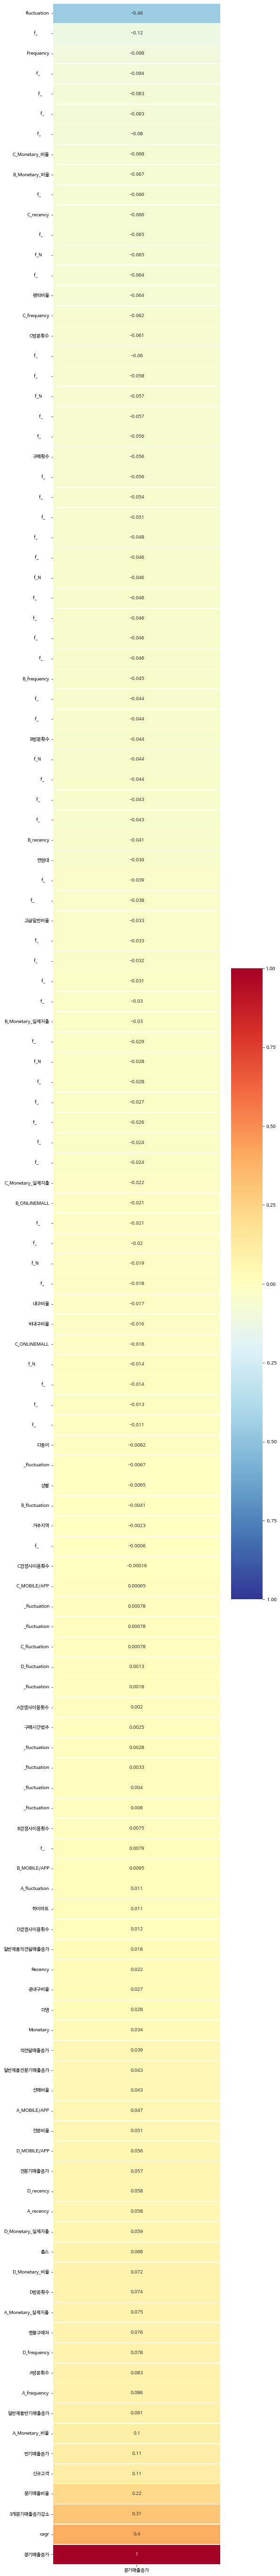

In [ ]:
cor = user_clr_df.corr();
#sns.heatmap(cor, annot = True, cmap = 'RdBu');

# mask = np.zeros_like(cor, dtype=bool);
# mask[np.triu_indices_from(mask)] = True;

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (8,100));

sns.heatmap(cor[['분기매출증가']].sort_values(by = '분기매출증가'),  
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           );

temp = cor[['분기매출증가']]
temp.분기매출증가 = temp.분기매출증가.apply(abs)
temp.sort_values(by = '분기매출증가', ascending = False).index[:10]

In [ ]:
user_clr_df.drop(columns = '분기매출비율', inplace = True )

In [ ]:
user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

In [ ]:
user_clr_df.to_csv("test.csv",encoding='utf-8')

## feature:6분기 만큼의 데이터, 예측 데이터: 그다음 1분기

- 1~6분기로 7분기 예측하는 모델 training,
- 같은 모델로 2~7분기 데이터를 사용해서 8분기 예측
- 주어진 데이터는 1~8분기임, 따라서 데이터를 mask 처리하여 일부만 사용

In [ ]:
# 1~6분기 데이터 뽑기
# df_purchase_tr_masked = df_purchase_tr[df_purchase_tr.구매일자  < datetime(2015,7,1)]  
# 2~7분기 데이터 뽑기
# df_purchase_tr_masked =  df_purchase_tr[df_purchase_tr.제휴사 == 'D'][(datetime(2014,3,31) < df_purchase_tr.구매일자) & (df_purchase_tr.구매일자 < datetime(2015,10,1))]   
df_purchase_tr_masked =  df_purchase_tr[(datetime(2014,3,31) < df_purchase_tr.구매일자) & (df_purchase_tr.구매일자 < datetime(2015,10,1))]   

user_df_masked = pd.DataFrame(df_purchase_tr_masked.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_masked = user_df_masked.unstack()['구매금액'].fillna(0).T

In [ ]:
sum_purchased_masked = pd.DataFrame(df_purchase_tr_masked.groupby('구매일자').구매금액.sum().fillna(0))

# 연도, 분기, 월별 구매금액
sum_Y_df_masked = sum_purchased_masked.resample('YS').mean().fillna(0)
sum_3Q_df_masked = sum_purchased_masked.resample('3QS').mean().fillna(0)
# sum_Y_df.plot(kind = 'bar');
sum_6m_df_masked = sum_purchased_masked.resample('2QS').mean().fillna(0)
# sum_6m_df.plot(kind = 'bar');
sum_Q_df_masked = sum_purchased_masked.resample('QS').mean().fillna(0)
# sum_Q_df.plot(kind = 'bar');
sum_m_df_masked = sum_purchased_masked.resample('MS').mean().fillna(0)
# sum_m_df.plot(kind = 'bar');

## RFM, 성별, 연령대, 거주지역 (기본 feature)

In [ ]:
# 구매금액이 큰 고객 분류
user_rev_sum_masked = user_df_masked.sum()
user_rev_sum_masked.sort_values(ascending = False, inplace = True)
user_rev_sum_masked = pd.DataFrame(user_rev_sum_masked)
# 구매횟수, 최근 구매일자 구하기
user_freq_recency_masked = df_purchase_tr_masked[['제휴사','고객번호','구매일자']].drop_duplicates()
# 영수증번호를 기준으로 frequency를 찾아도 되지만 한 제휴사에서 여러군데 쇼핑한 경우가 있어서 다른 방식으로 함
# df_purchase_tr[['고객번호','영수증번호']].drop_duplicates().groupby('고객번호').영수증번호.count() 
user_freq_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.count())
user_recency_masked = pd.DataFrame(user_freq_recency_masked.groupby('고객번호').구매일자.max())

user_freq_masked.rename(columns = {'구매일자':'Frequency'}, inplace = True)
user_recency_masked.rename(columns = {'구매일자':'Recency'}, inplace = True)
user_rev_sum_masked.rename(columns = {0:'Monetary'}, inplace = True)

user_rfm_masked = pd.merge(user_recency_masked, user_freq_masked,left_index=True, right_index=True,how='left')
user_rfm_masked = pd.merge(user_rfm_masked, user_rev_sum_masked,left_index=True, right_index=True,how='left')
  
d1 = datetime(2013, 12, 31)
user_rfm_masked['Recency']  = user_rfm_masked['Recency'].apply(lambda x : (x-d1).days) 

In [ ]:
user_clr_df = pd.merge(user_rfm_masked.reset_index(), df_members[['고객번호','성별','연령대','거주지역']].drop_duplicates(), on='고객번호',how = 'left')
user_clr_df.성별 = user_clr_df.성별.apply(lambda x : 1 if x == 'M' else 0) # 성별 M/F -> 1/0 
user_clr_df.연령대 = user_clr_df.연령대.apply(lambda x : int(x[:2])) # 연령대 -> 숫자로
user_clr_df.describe()

고객번호      Recency     Frequency      Monetary            성별  \
count  19371.000000  19371.00000  19371.000000  1.937100e+04  19371.000000   
mean    9686.950958    634.90873    250.701616  2.584961e+07      0.179598   
std     5593.057525     13.55285     91.207987  4.706283e+07      0.383862   
min        1.000000    140.00000      1.000000  8.990000e+03      0.000000   
25%     4843.500000    634.00000    185.000000  8.252026e+06      0.000000   
50%     9687.000000    637.00000    248.000000  1.295016e+07      0.000000   
75%    14529.500000    638.00000    314.000000  2.899510e+07      0.000000   
max    19383.000000    638.00000    807.000000  2.245034e+09      1.000000   

                연령대          거주지역  
count  19371.000000  19371.000000  
mean      42.953281    203.933612  
std        9.300581    187.499826  
min       19.000000      0.000000  
25%       35.000000     60.000000  
50%       45.000000    100.000000  
75%       50.000000    360.000000  
max       60.000000    630.000000

## 6개 분기 중 전반 3분기 vs 후반 3분기


In [ ]:
user_3Q_df = user_df_masked.resample('3QS').mean().fillna(0)
user_3Q_df
Q3_ratio = sum_3Q_df_masked['구매금액']/sum_3Q_df_masked['구매금액'].max()
user_3Q_df = (user_3Q_df).div(Q3_ratio, axis = 0) # weight scale
user_3Q_df  = user_3Q_df.T

user_3Q_df["3개분기매출증가감소"] = (user_3Q_df.iloc[:,1])/(user_3Q_df.iloc[:,0]).clip(0,10)
user_clr_df = pd.merge(user_clr_df,user_3Q_df[['3개분기매출증가감소']].reset_index(), on='고객번호',how = 'left')


## 6개분기 3등분 (2Q씩), 두번째 vs 세번째 

In [ ]:
user_6m_df = user_df_masked.resample('2QS').mean().fillna(0)
half_year_ratio = sum_6m_df_masked['구매금액']/sum_6m_df_masked['구매금액'].max()
user_6m_df = (user_6m_df).div(half_year_ratio, axis = 0) # weight scale
user_6m_df  = user_6m_df.T

user_6m_df["반기매출증가"] = (user_6m_df.iloc[:,2])/(user_6m_df.iloc[:,1]).clip(0,10)

user_clr_df = pd.merge(user_clr_df,user_6m_df[['반기매출증가']].reset_index(), on='고객번호',how = 'left')

## 6개분기중 5분기와 6분기 비교 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_Q_df = user_df_masked.resample('QS').mean().fillna(0)
Q_ratio = sum_Q_df_masked['구매금액']/sum_Q_df_masked['구매금액'].max()
user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T

user_Q_df["전분기매출증가"] =(user_Q_df.iloc[:,5])/(user_Q_df.iloc[:,4]).clip(0,10)
user_clr_df = pd.merge(user_clr_df,user_Q_df[['전분기매출증가']].reset_index(), on='고객번호',how = 'left')

## 17개월째 매출 vs 18개월째 매출 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

user_m_df = user_df_masked.resample('MS').mean().fillna(0)
m_ratio = sum_m_df_masked['구매금액']/sum_m_df_masked['구매금액'].max()
user_m_df = (user_m_df).div(m_ratio, axis = 0) # weight scale
user_m_df  = user_m_df.T

user_m_df
user_m_df["직전달매출증가"] = (user_m_df.iloc[:,17])/(user_m_df.iloc[:,16]).clip(0,10)
user_clr_df = pd.merge(user_clr_df,user_m_df[['직전달매출증가']].reset_index(), on='고객번호',how = 'left')
user_clr_df['직전달매출증가'].value_counts()

inf             107
0.000000e+00    102
7.141521e+02      3
1.229170e+03      3
1.637124e+03      3
               ... 
4.129905e+03      1
4.184586e+03      1
1.025060e+04      1
3.016728e+03      1
2.853152e+03      1
Name: 직전달매출증가, Length: 18770, dtype: int64

##  일반 제품 매출 시계열 변화 추가(2Q씩)

In [ ]:
# st = '비내구'

# exp_cheap_df = df_purchase_tr[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
# exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','내구/준내구/비내구']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
# exp_cheap_df = exp_cheap_df[exp_cheap_df['내구/준내구/비내구'] == st]
# exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T
# exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
# exp_cheapQ_df.T.to_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/etc./'+st+'.csv')

In [ ]:
exp_cheap_df = df_purchase_tr_masked[['고객번호','제휴사','중분류코드','구매일자','구매금액']]
exp_cheap_df = pd.merge(exp_cheap_df, df_merchant_cl[['제휴사','중분류코드','고급/일반']].drop_duplicates(), on =['제휴사','중분류코드'], how ='left')
exp_cheap_df = exp_cheap_df[exp_cheap_df['고급/일반'] == '일반']
exp_cheap_df = exp_cheap_df.groupby(['고객번호','구매일자']).구매금액.sum().unstack().fillna(0).T

exp_cheap6m_df = exp_cheap_df.resample('2QS').mean().fillna(0)
exp_cheap6m_df  = exp_cheap6m_df.T

exp_cheap6m_df["일반제품반기매출증가"] = (exp_cheap6m_df.iloc[:,2])/(exp_cheap6m_df.iloc[:,1]).clip(0,10)

user_clr_df = pd.merge(user_clr_df,exp_cheap6m_df[['일반제품반기매출증가']].reset_index(), on='고객번호',how = 'left')


##  일반 제품 매출 시계열 변화 추가(Q비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('QS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df["일반제품전분기매출증가"] = (exp_cheapQ_df.iloc[:,5])/(exp_cheapQ_df.iloc[:,4]).clip(0,10)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품전분기매출증가']].reset_index(), on='고객번호',how = 'left')

## 일반 제품 매출 시계열 변화 추가(직전달 비교)

In [ ]:
exp_cheapQ_df = exp_cheap_df.resample('MS').mean().fillna(0)
exp_cheapQ_df  = exp_cheapQ_df.T

exp_cheapQ_df
exp_cheapQ_df["일반제품직전달매출증가"] = (exp_cheapQ_df.iloc[:,17])/(exp_cheapQ_df.iloc[:,16]).clip(0,10)
user_clr_df = pd.merge(user_clr_df,exp_cheapQ_df[['일반제품직전달매출증가']].reset_index(), on='고객번호',how = 'left')

## 고급/일반 구매 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','고급/일반']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','고급/일반']).구매금액.mean()).unstack()['구매금액']
temp.fillna(0, inplace = True)
temp['고급일반비율'] = temp.고급/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','고급일반비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가       직전달매출증가   일반제품반기매출증가  일반제품전분기매출증가  \
0      9.916426e+03  10285.717762   9946.849355   872.595628   762.793478   
1      1.399786e+04  18238.598296  18576.716951  1273.896175  1440.173913   
2      4.437597e+02    554.719485    663.140705   284.943716   340.214130   
3      2.446620e+03   2802.619544   3316.969469   755.648634   627.197826   
4      4.900185e+02      0.000000           NaN    77.065574     0.000000   
...             ...           ...           ...          ...          ...   
19366  1.251769e+03   1061.368735    773.912656   152.267760   111.434783   
19367  4.353196e+02    486.060898    646.675419    86.861749   109.061957   
19368  2.140194e+03   2460.563807   3714.033240  1436.044809  1268.109783   
19369  1.394498e+03   1668.290354   1776.056603   988.785246  1094.475000   
19370           inf   1439.261066   2853.152366          inf   331.989130   

       일반제품직전달매출증가    고급일반비율  
0       541.000000  0.499294  
1      2252.866667  0.487984  
2       374.190000  0.477819  
3       427.633333  0.501408  
4              NaN  0.550520  
...            ...       ...  
19366   118.466667  0.501339  
19367   126.966667  0.584224  
19368  1494.433333  0.614011  
19369   944.966667  0.534319  
19370   710.800000  0.509097  

[19371 rows x 15 columns]

## 내구/준내구/비내구 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','내구/준내구/비내구']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','내구/준내구/비내구']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['내구비율'] = temp.내구/temp.sum(axis = 1)
temp['비내구비율'] = temp.비내구/temp.sum(axis = 1)
temp['준내구비율'] = temp.준내구/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','내구비율','비내구비율','준내구비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가       직전달매출증가   일반제품반기매출증가  일반제품전분기매출증가  \
0      9.916426e+03  10285.717762   9946.849355   872.595628   762.793478   
1      1.399786e+04  18238.598296  18576.716951  1273.896175  1440.173913   
2      4.437597e+02    554.719485    663.140705   284.943716   340.214130   
3      2.446620e+03   2802.619544   3316.969469   755.648634   627.197826   
4      4.900185e+02      0.000000           NaN    77.065574     0.000000   
...             ...           ...           ...          ...          ...   
19366  1.251769e+03   1061.368735    773.912656   152.267760   111.434783   
19367  4.353196e+02    486.060898    646.675419    86.861749   109.061957   
19368  2.140194e+03   2460.563807   3714.033240  1436.044809  1268.109783   
19369  1.394498e+03   1668.290354   1776.056603   988.785246  1094.475000   
19370           inf   1439.261066   2853.152366          inf   331.989130   

       일반제품직전달매출증가    고급일반비율      내구비율     비내구비율     준내구비율  
0       541.000000  0.499294  0.158866  0.491853  0.349280  
1      2252.866667  0.487984  0.143724  0.539087  0.317189  
2       374.190000  0.477819  0.144533  0.674035  0.181432  
3       427.633333  0.501408  0.047699  0.550256  0.402045  
4              NaN  0.550520  0.044310  0.783083  0.172607  
...            ...       ...       ...       ...       ...  
19366   118.466667  0.501339  0.068401  0.534395  0.397204  
19367   126.966667  0.584224  0.087759  0.562327  0.349914  
19368  1494.433333  0.614011  0.073115  0.547772  0.379113  
19369   944.966667  0.534319  0.039491  0.706171  0.254338  
19370   710.800000  0.509097  0.059927  0.530615  0.409457  

[19371 rows x 18 columns]

## 편의/선매/전문 비율

In [ ]:
temp = pd.DataFrame(pd.merge(df_purchase_tr_masked[['중분류코드','고객번호','구매금액']], df_merchant_cl[['중분류코드','편의/선매/전문']].drop_duplicates(), on = '중분류코드', how = 'left').groupby(['고객번호','편의/선매/전문']).구매금액.sum()).unstack()['구매금액']
temp.fillna(0, inplace = True)

temp['편의비율'] = temp.편의/temp.sum(axis = 1)
temp['선매비율'] = temp.선매/temp.sum(axis = 1)
temp['전문비율'] = temp.전문/temp.sum(axis = 1)
temp.reset_index(inplace = True)

user_clr_df= pd.merge(user_clr_df, temp[['고객번호','편의비율','선매비율','전문비율']], on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가  ...   일반제품반기매출증가  일반제품전분기매출증가  일반제품직전달매출증가  \
0      9.916426e+03  10285.717762  ...   872.595628   762.793478   541.000000   
1      1.399786e+04  18238.598296  ...  1273.896175  1440.173913  2252.866667   
2      4.437597e+02    554.719485  ...   284.943716   340.214130   374.190000   
3      2.446620e+03   2802.619544  ...   755.648634   627.197826   427.633333   
4      4.900185e+02      0.000000  ...    77.065574     0.000000          NaN   
...             ...           ...  ...          ...          ...          ...   
19366  1.251769e+03   1061.368735  ...   152.267760   111.434783   118.466667   
19367  4.353196e+02    486.060898  ...    86.861749   109.061957   126.966667   
19368  2.140194e+03   2460.563807  ...  1436.044809  1268.109783  1494.433333   
19369  1.394498e+03   1668.290354  ...   988.785246  1094.475000   944.966667   
19370           inf   1439.261066  ...          inf   331.989130   710.800000   

         고급일반비율      내구비율     비내구비율     준내구비율      편의비율      선매비율      전문비율  
0      0.499294  0.158866  0.491853  0.349280  0.486734  0.484125  0.029141  
1      0.487984  0.143724  0.539087  0.317189  0.477004  0.471926  0.051069  
2      0.477819  0.144533  0.674035  0.181432  0.701840  0.237123  0.061037  
3      0.501408  0.047699  0.550256  0.402045  0.497562  0.458805  0.043633  
4      0.550520  0.044310  0.783083  0.172607  0.449380  0.435740  0.114880  
...         ...       ...       ...       ...       ...       ...       ...  
19366  0.501339  0.068401  0.534395  0.397204  0.455742  0.513464  0.030794  
19367  0.584224  0.087759  0.562327  0.349914  0.486838  0.431265  0.081897  
19368  0.614011  0.073115  0.547772  0.379113  0.718304  0.213913  0.067782  
19369  0.534319  0.039491  0.706171  0.254338  0.781689  0.185390  0.032921  
19370  0.509097  0.059927  0.530615  0.409457  0.476315  0.500324  0.023361  

[19371 rows x 21 columns]

## 멤버쉽 종류(유무)

In [ ]:
member_df = df_members[['고객번호','멤버십명']].drop_duplicates()
member_df = member_df.pivot(index = '고객번호', columns ='멤버십명', values = '멤버십명')
member_df = member_df[['다둥이', '더영', '롭스', '하이마트']].fillna(0)
member_df = member_df.replace(['다둥이', '더영', '롭스', '하이마트'], 1).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, member_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가  ...      내구비율     비내구비율     준내구비율  \
0      9.916426e+03  10285.717762  ...  0.158866  0.491853  0.349280   
1      1.399786e+04  18238.598296  ...  0.143724  0.539087  0.317189   
2      4.437597e+02    554.719485  ...  0.144533  0.674035  0.181432   
3      2.446620e+03   2802.619544  ...  0.047699  0.550256  0.402045   
4      4.900185e+02      0.000000  ...  0.044310  0.783083  0.172607   
...             ...           ...  ...       ...       ...       ...   
19366  1.251769e+03   1061.368735  ...  0.068401  0.534395  0.397204   
19367  4.353196e+02    486.060898  ...  0.087759  0.562327  0.349914   
19368  2.140194e+03   2460.563807  ...  0.073115  0.547772  0.379113   
19369  1.394498e+03   1668.290354  ...  0.039491  0.706171  0.254338   
19370           inf   1439.261066  ...  0.059927  0.530615  0.409457   

           편의비율      선매비율      전문비율  다둥이  더영  롭스  하이마트  
0      0.486734  0.484125  0.029141    0   0   0     0  
1      0.477004  0.471926  0.051069    0   0   0     0  
2      0.701840  0.237123  0.061037    0   0   0     0  
3      0.497562  0.458805  0.043633    0   0   0     0  
4      0.449380  0.435740  0.114880    0   0   0     0  
...         ...       ...       ...  ...  ..  ..   ...  
19366  0.455742  0.513464  0.030794    0   0   1     0  
19367  0.486838  0.431265  0.081897    0   0   1     0  
19368  0.718304  0.213913  0.067782    1   0   0     0  
19369  0.781689  0.185390  0.032921    0   0   0     0  
19370  0.476315  0.500324  0.023361    0   0   1     0  

[19371 rows x 25 columns]

## 채널유무

In [ ]:
channel_df = df_members[['고객번호','사용(모바일/온라인) 채널','채널이용횟수']].drop_duplicates()
channel_df = channel_df.pivot(index = '고객번호', columns ='사용(모바일/온라인) 채널', values = '채널이용횟수').fillna(0)
channel_df = channel_df[['A_MOBILE/APP',	'B_MOBILE/APP',	'B_ONLINEMALL',	'C_MOBILE/APP',	'C_ONLINEMALL',	'D_MOBILE/APP']].fillna(0).reset_index()

In [ ]:
user_clr_df= pd.merge(user_clr_df, channel_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가  ...  다둥이  더영  롭스  하이마트  A_MOBILE/APP  \
0      9.916426e+03  10285.717762  ...    0   0   0     0           0.0   
1      1.399786e+04  18238.598296  ...    0   0   0     0           0.0   
2      4.437597e+02    554.719485  ...    0   0   0     0           0.0   
3      2.446620e+03   2802.619544  ...    0   0   0     0           0.0   
4      4.900185e+02      0.000000  ...    0   0   0     0           0.0   
...             ...           ...  ...  ...  ..  ..   ...           ...   
19366  1.251769e+03   1061.368735  ...    0   0   1     0           0.0   
19367  4.353196e+02    486.060898  ...    0   0   1     0           0.0   
19368  2.140194e+03   2460.563807  ...    1   0   0     0           0.0   
19369  1.394498e+03   1668.290354  ...    0   0   0     0           0.0   
19370           inf   1439.261066  ...    0   0   1     0           0.0   

       B_MOBILE/APP  B_ONLINEMALL  C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  
0               0.0           0.0           0.0           0.0           0.0  
1               0.0           0.0           0.0           0.0           0.0  
2               0.0           0.0           0.0           0.0           0.0  
3               0.0           0.0           0.0           0.0           0.0  
4               0.0           0.0           0.0           0.0           0.0  
...             ...           ...           ...           ...           ...  
19366           0.0           0.0           0.0           0.0           0.0  
19367           0.0           0.0           0.0           0.0           1.0  
19368           5.0           0.0           0.0           0.0           0.0  
19369           9.0           0.0           0.0           0.0           0.0  
19370           0.0           0.0           0.0           0.0           0.0  

[19371 rows x 31 columns]

## 경쟁사 이용 유무 및 이용횟수

In [ ]:
compet_df = df_members[['고객번호','경쟁사','경쟁사이용년월']].drop_duplicates()
compet_df = pd.pivot_table(compet_df, index = '고객번호', columns ='경쟁사', values = '경쟁사이용년월', aggfunc = 'count').fillna(0)
compet_df = compet_df[[ 'A01', 'A02', 'B01', 'B02', 'C01', 'C02', 'C03', 'D01', 'D02']].reset_index()
compet_df['A경쟁사이용횟수'] =compet_df.A01+compet_df.A02
compet_df['B경쟁사이용횟수'] =compet_df.B01+compet_df.B02
compet_df['C경쟁사이용횟수'] =compet_df.C01+compet_df.C02+compet_df.C03
compet_df['D경쟁사이용횟수'] =compet_df.D01+compet_df.D02
compet_df = compet_df[['고객번호','A경쟁사이용횟수',	'B경쟁사이용횟수',	'C경쟁사이용횟수',	'D경쟁사이용횟수']]
compet_df

경쟁사    고객번호  A경쟁사이용횟수  B경쟁사이용횟수  C경쟁사이용횟수  D경쟁사이용횟수
0         1       2.0       8.0       5.0       0.0
1         2       2.0       3.0       2.0       1.0
2         4       2.0       0.0       1.0       0.0
3         7       1.0       0.0       0.0       0.0
4         8       1.0       2.0       0.0       0.0
...     ...       ...       ...       ...       ...
5876  19370       0.0      11.0       0.0      13.0
5877  19372       0.0       2.0       2.0       0.0
5878  19375       1.0       2.0       1.0       2.0
5879  19376       0.0       1.0       0.0       0.0
5880  19377       0.0       1.0       0.0       0.0

[5881 rows x 5 columns]

In [ ]:
user_clr_df= pd.merge(user_clr_df, compet_df, on = '고객번호', how = 'left')
user_clr_df

고객번호  Recency  Frequency    Monetary  성별  연령대   거주지역    3개분기매출증가감소  \
0          1      630        191  70605022.0   1   60   60.0  9.463006e+03   
1          2      637        221  73756070.0   1   60  100.0  1.532720e+04   
2          3      630        307   2604284.0   1   60   33.0  3.730347e+02   
3          4      638        204  13774022.0   0   60   16.0  2.129337e+03   
4          5      506        146   7475480.0   1   60  100.0  1.080464e+03   
...      ...      ...        ...         ...  ..  ...    ...           ...   
19366  19379      637        205   4392090.0   0   20   69.0  1.178588e+03   
19367  19380      637         78   1729557.0   0   20   39.0  4.442918e+02   
19368  19381      637        145   4664672.0   0   40  460.0           inf   
19369  19382      636        143   3092926.0   0   45  460.0           inf   
19370  19383      636         56   1119360.0   0   25  500.0           inf   

             반기매출증가       전분기매출증가  ...  A_MOBILE/APP  B_MOBILE/APP  \
0      9.916426e+03  10285.717762  ...           0.0           0.0   
1      1.399786e+04  18238.598296  ...           0.0           0.0   
2      4.437597e+02    554.719485  ...           0.0           0.0   
3      2.446620e+03   2802.619544  ...           0.0           0.0   
4      4.900185e+02      0.000000  ...           0.0           0.0   
...             ...           ...  ...           ...           ...   
19366  1.251769e+03   1061.368735  ...           0.0           0.0   
19367  4.353196e+02    486.060898  ...           0.0           0.0   
19368  2.140194e+03   2460.563807  ...           0.0           5.0   
19369  1.394498e+03   1668.290354  ...           0.0           9.0   
19370           inf   1439.261066  ...           0.0           0.0   

       B_ONLINEMALL  C_MOBILE/APP  C_ONLINEMALL  D_MOBILE/APP  A경쟁사이용횟수  \
0               0.0           0.0           0.0           0.0       2.0   
1               0.0           0.0           0.0           0.0       2.0   
2               0.0           0.0           0.0           0.0       NaN   
3               0.0           0.0           0.0           0.0       2.0   
4               0.0           0.0           0.0           0.0       NaN   
...             ...           ...           ...           ...       ...   
19366           0.0           0.0           0.0           0.0       NaN   
19367           0.0           0.0           0.0           1.0       NaN   
19368           0.0           0.0           0.0           0.0       NaN   
19369           0.0           0.0           0.0           0.0       NaN   
19370           0.0           0.0           0.0           0.0       NaN   

       B경쟁사이용횟수  C경쟁사이용횟수  D경쟁사이용횟수  
0           8.0       5.0       0.0  
1           3.0       2.0       1.0  
2           NaN       NaN       NaN  
3           0.0       1.0       0.0  
4           NaN       NaN       NaN  
...         ...       ...       ...  
19366       NaN       NaN       NaN  
19367       NaN       NaN       NaN  
19368       NaN       NaN       NaN  
19369       NaN       NaN       NaN  
19370       NaN       NaN       NaN  

[19371 rows x 35 columns]

In [ ]:
user_clr_df = user_clr_df.fillna(0)

## 제휴사별 RFM

In [ ]:
user_clr_df = pd.merge(user_clr_df, main_cat_df, left_on = '고객번호', right_index = True, how = 'left')  # 주 이용 제휴사(A,B,C,D 중 어디에 돈을 많이 썼는가?)
user_clr_df = pd.merge(user_clr_df, freq_jehyu_df, left_on = '고객번호', right_index = True, how = 'left') # 주 이용 제휴사(A,B,C,D 중 어디에 가장 자주 방문했는가?)
user_clr_df = pd.merge(user_clr_df, jehyu_frequency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 frequency
user_clr_df = pd.merge(user_clr_df, jehyu_Monetary, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 Monetary 
user_clr_df = pd.merge(user_clr_df, jehyu_recency, left_on = '고객번호', right_index = True, how = 'left') # 제휴사별 recency

## Feature 추가 및 정리

In [ ]:
import re
import os

path = '/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/create_feature/'

# 공사님 feature
addtional_feature_df = pd.read_csv(path+'sa_group.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

# 훈님 feature
addtional_feature_df = pd.read_csv(path+'train_data_훈.csv', encoding='cp949')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df, on='고객번호',how = 'left')

# 짱제님 feature
# addtional_feature_df = pd.read_csv(path+'train_1_to_6_짱제.csv')
addtional_feature_df = pd.read_csv(path+'train_2_to_7_짱제.csv')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df.drop(columns='Unnamed: 0'), on='고객번호',how = 'left')

#카스님 feature
# addtional_feature_df = pd.read_csv(path+'train_fluctuation_total.csv')
# addtional_feature_df1 = pd.read_excel(path+'train_fluctuation_중분류별.xlsx')
# addtional_feature_df1 = addtional_feature_df1.fillna(1000)
# addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
# user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')

addtional_feature_df = pd.read_csv(path+'test_fluctuation_total.csv')
addtional_feature_df1 = pd.read_excel(path+'test_fluctuation_중분류별.xlsx')
addtional_feature_df1 = addtional_feature_df1.fillna(1000)
addtional_feature_df1 = pd.merge(addtional_feature_df1,addtional_feature_df[['고객번호','fluctuation']], on='고객번호',how = 'left')
user_clr_df = pd.merge(user_clr_df,addtional_feature_df1, on='고객번호',how = 'left')

p = re.compile('(?<=fluctuation_).+(?=.csv)')

path_dir = path+'/test/'

file_list = os.listdir(path_dir)
for filename in file_list :
  fluc_df  = pd.read_csv(path_dir+filename)
  fluc_df = fluc_df.set_index('고객번호')
  colname = re.findall(p, filename)
  if len(fluc_df.columns) == 2 :
    fluc_df.drop(columns ='Unnamed: 0', inplace = True)
    fluc_df.columns = [colname[0]+'_fluctuation']
  else :
    fluc_df.columns = [colname[0]+'_fluctuation']
  user_clr_df  = pd.merge(user_clr_df,fluc_df, left_index = True, right_index = True, how = 'left')

user_clr_df.fillna(0.001, inplace = True)  

user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]]= user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]].replace(1000,0.0001)

## label값
 2014년 1분기 부터 2015년 2분기까지 대비 2015년 3분기 매출 증가 or 감소
 
 2014년 2분기 부터 2015년 3분기까지 대비 2015년 4분기 매출 증가 or 감소
 

In [ ]:
# mean_m_df : 전체 고객 구매금액 평균치 
# user_m_df:  개인 고객 구매금액 

# df_purchase_tr_ =  df_purchase_tr[df_purchase_tr.제휴사 == 'D']
user_df_ = pd.DataFrame(df_purchase_tr.groupby(['고객번호','구매일자']).구매금액.sum()).fillna(0)
user_df_ = user_df_.unstack()['구매금액'].fillna(0).T


user_Q_df = user_df_.resample('QS').mean().fillna(0)
# Q_ratio = sum_Q_df['구매금액']/sum_Q_df['구매금액'].max()
# user_Q_df = (user_Q_df).div(Q_ratio, axis = 0) # weight scale
user_Q_df  = user_Q_df.T

# 1~6분기로 7분기 예측 label
# comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,6] - user_Q_df.iloc[:,7])/6
# comp = comp.clip(0.00001, comp)
# user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,6] >= comp, 1 ,0)
# user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,6])/comp
# user_Q_df['분기매출증가'] = np.select([user_Q_df.iloc[:,6] > 1.05 * comp, user_Q_df.iloc[:,6] < 0.95 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,6] < 0.95 * comp,1, 0)

# # 2~7분기로 8분기 예측 label
# comp = (user_Q_df.sum(axis = 1) - user_Q_df.iloc[:,0] - user_Q_df.iloc[:,7])/6
# comp = comp.clip(0.00001, comp)
# user_Q_df["분기매출증가"] = np.where(user_Q_df.iloc[:,7] >= user_Q_df.iloc[:,0], 1 ,0)
user_Q_df["분기매출비율"] = (user_Q_df.iloc[:,7])/(user_Q_df.iloc[:,0])
user_Q_df['분기매출증가'] = np.select([user_Q_df.iloc[:,7] > 1.05 * comp, user_Q_df.iloc[:,7] < 0.95 * comp],[2, 0], default=1)
# user_Q_df['분기매출증가'] = np.where(user_Q_df.iloc[:,7] < 0.95 * comp,1, 0)
  
user_clr_df = pd.merge(user_clr_df,user_Q_df[['분기매출증가',"분기매출비율"]].reset_index(), on='고객번호',how = 'left')

user_clr_df["분기매출증가"].value_counts()

0    11952
2     5793
1     1626
Name: 분기매출증가, dtype: int64

In [ ]:
user_clr_df = user_clr_df[ user_clr_df.분기매출비율 !=0 ]

In [ ]:
# # 구매증가/감소 고객 분포
# cust_hist_df = user_Q_df.iloc[:,6]/ comp
# cust_hist_df = round(cust_hist_df.fillna(2),5)
# cust_hist_df = cust_hist_df.clip(0,2)
# plt.hist(cust_hist_df.values, bins = 50);

In [ ]:
user_clr_origin_df = user_clr_df.copy()
user_clr_df.set_index('고객번호',inplace = True)

# # 비내구재 비율
# user_clr_df.비내구비율 = (user_clr_df.비내구비율)/(user_clr_df.비내구비율+user_clr_df.내구비율+user_clr_df.준내구비율)
# # 편의비율
# user_clr_df.편의비율 = (user_clr_df.편의비율)/(user_clr_df.선매비율+user_clr_df.편의비율+user_clr_df.전문비율)

# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.구매금액이큰제휴사 =user_clr_df.구매금액이큰제휴사.map(map_)
# map_ = {'A':0,'B':1,'C':2,'D':3}
# user_clr_df.방문빈도가높은제휴사 =user_clr_df.방문빈도가높은제휴사.map(map_)

# 어떤 feature를 쓸것인가 결정

#user_clr_df = user_clr_df.drop(columns = ['Recency','성별', '연령대', '거주지역', '내구비율', '선매비율', '준내구비율','고급일반비율','전문비율','구매금액이큰제휴사'])

## Feature correlation

In [ ]:
user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]]= user_clr_df[user_clr_df.columns[user_clr_df.columns.str.contains('f_')]].replace(1000,0.0001)

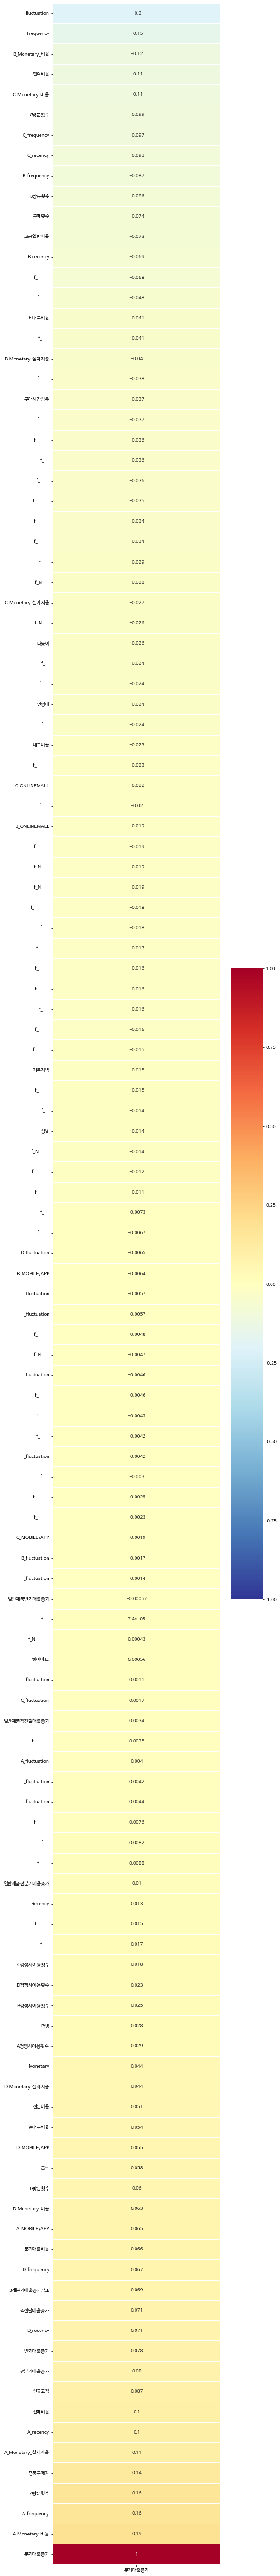

In [ ]:
plt.rcParams['font.family'] = 'Malgun Gothic'

cor = user_clr_df.corr();
#sns.heatmap(cor, annot = True, cmap = 'RdBu');

# mask = np.zeros_like(cor, dtype=bool);
# mask[np.triu_indices_from(mask)] = True;

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (8,100));

sns.heatmap(cor[['분기매출증가']].sort_values(by = '분기매출증가'),  
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           );

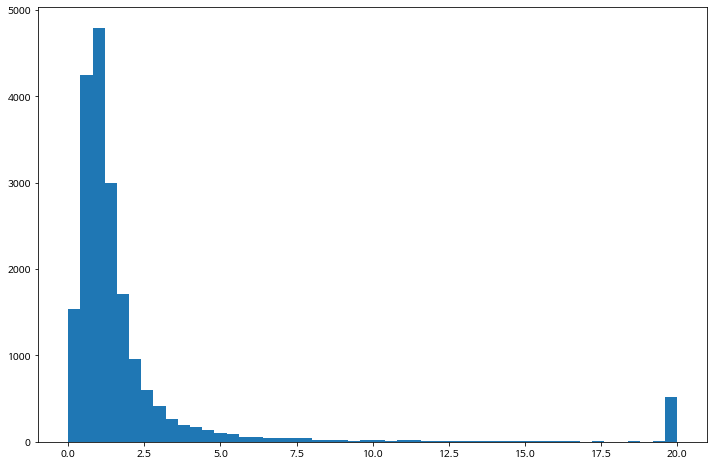

In [ ]:
plt.hist(user_clr_df.분기매출비율.clip(0, 20), bins = 50);

In [ ]:
# user_clr_df.drop(columns = '분기매출비율', inplace = True )

In [ ]:
user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

In [ ]:
user_clr_df.to_csv("test.csv",encoding='utf-8')

# Train Test 가공

In [ ]:
user_clr_df.columns[user_clr_df.columns.str.contains('_fluctuation')]

Index(['A_fluctuation', 'B_fluctuation', 'C_fluctuation', 'D_fluctuation',
       '고급_fluctuation', '일반_fluctuation', '편의_fluctuation',
       '준내구_fluctuation', '내구_fluctuation', '비내구_fluctuation',
       '선매_fluctuation', '전문_fluctuation'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

user_clr_df = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/train/train-new_label.csv')

test_valid = pd.read_csv('/content/drive/MyDrive/데이터분석/2차_프로젝트_lmemdata/5팀_공유폴더/작업결과물/dataset/test/test-new_label.csv')

# user_clr_df = pd.read_csv('train.csv')

# test_valid = pd.read_csv('test.csv')

user_clr_df = user_clr_df.set_index('고객번호')
test_valid = test_valid.set_index('고객번호')

user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = user_clr_df[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')
test_valid[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']] = test_valid[['거주지역','구매금액이큰제휴사','방문빈도가높은제휴사']].astype('category')

y_train = user_clr_df.분기매출증가
X_train = user_clr_df[[ 'fluctuation', 'Monetary','cagr', '3개분기매출증가감소', '반기매출증가', '전분기매출증가', '직전달매출증가',
'A_Monetary_실제지출', 'B_Monetary_실제지출', 'C_Monetary_실제지출','D_Monetary_실제지출','A_fluctuation', 'B_fluctuation', 'C_fluctuation',
  'D_fluctuation','선매_fluctuation', '편의_fluctuation','고급_fluctuation', '일반_fluctuation','전문_fluctuation']]       
X_train = pd.get_dummies(X_train)

y_test_valid = test_valid.분기매출증가
X_test_valid = test_valid[['fluctuation', 'Monetary','cagr', '3개분기매출증가감소', '반기매출증가', '전분기매출증가', '직전달매출증가',
'A_Monetary_실제지출', 'B_Monetary_실제지출', 'C_Monetary_실제지출','D_Monetary_실제지출','A_fluctuation', 'B_fluctuation', 'C_fluctuation',
  'D_fluctuation', '고급_fluctuation', '선매_fluctuation', '편의_fluctuation', '일반_fluctuation','전문_fluctuation']]

X_test_valid = pd.get_dummies(X_test_valid)

# y_train = user_clr_df.분기매출증가
# X_train = user_clr_df.drop(columns =['분기매출증가'])
# X_train = pd.get_dummies(X_train)

# y_test_valid = test_valid.분기매출증가
# X_test_valid = test_valid.drop(columns =['분기매출증가'])
# X_test_valid = pd.get_dummies(X_test_valid)

X_val, X_test, y_val, y_test= train_test_split(X_test_valid, y_test_valid, test_size=0.7 )

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(19372, 20)
(19372,)
(5811, 20)
(5811,)
(13560, 20)
(13560,)
